In [1]:
import sys
sys.path.append("../")
from src import prepro, metrics, run, setup
import src.models.factory as model_factory
import config
import torch

import numpy as np
from src.utils import models
import os.path as osp
import pandas as pd

from xgboost import XGBClassifier
from xgboost import XGBRegressor
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error
from src.utils.data_processing import *

from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt



window_size = 8
predict_at = 8
full = False

tgt_intensity_cat_train = torch.LongTensor(np.load('../data/y_train_intensity_cat_1980_34_20_120_w' + str(window_size) + '_at_' + str(predict_at) + '.npy',
                                      allow_pickle=True))
tgt_intensity_cat_test = torch.LongTensor(np.load('../data/y_test_intensity_cat_1980_34_20_120_w' + str(window_size) + '_at_' + str(predict_at) + '.npy',
                                     allow_pickle=True))

tgt_intensity_train = torch.Tensor(np.load('../data/y_train_intensity_1980_34_20_120_w' + str(window_size) + '_at_' + str(predict_at) + '.npy',
                                  allow_pickle=True))
tgt_intensity_test = torch.Tensor(np.load('../data/y_test_intensity_1980_34_20_120_w' + str(window_size) + '_at_' + str(predict_at) + '.npy',
                                 allow_pickle=True))

tgt_intensity_cat_baseline_train = torch.LongTensor(np.load('../data/y_train_intensity_cat_baseline_1980_34_20_120_w' + str(window_size) + '_at_' + str(predict_at) + '.npy',  allow_pickle = True))
tgt_intensity_cat_baseline_test = torch.LongTensor(np.load('../data/y_test_intensity_cat_baseline_1980_34_20_120_w' + str(window_size) + '_at_' + str(predict_at) + '.npy', allow_pickle=True))

tgt_displacement_train = torch.Tensor(np.load('../data/y_train_displacement_1980_34_20_120_w' + str(window_size) + '_at_' + str(predict_at) + '.npy',
                                     allow_pickle=True))
tgt_displacement_test = torch.Tensor(np.load('../data/y_test_displacement_1980_34_20_120_w' + str(window_size) + '_at_' + str(predict_at) + '.npy',
                                    allow_pickle=True))

tgt_displacement_train_unst = torch.Tensor(np.load('../data/y_train_displacement_1980_34_20_120_w' + str(window_size) + '_at_' + str(predict_at) + '.npy',
                                     allow_pickle=True))
tgt_displacement_test_unst = torch.Tensor(np.load('../data/y_test_displacement_1980_34_20_120_w' + str(window_size) + '_at_' + str(predict_at) + '.npy',
                                    allow_pickle=True))

/state/partition1/llgrid/pkg/anaconda/anaconda3-2020a/lib/python3.6/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/state/partition1/llgrid/pkg/anaconda/anaconda3-2020a/lib/python3.6/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)
/state/partition1/llgrid/pkg/anaconda/anaconda3-2020a/lib/python3.6/site-packages/distributed/utils.py:134: RuntimeWarning: Couldn't detect a suitable IP address for reaching '8.8.8.8', defaulting to '127.0.0.1': [Errno 101] Network is unreachable
  % (host, default, e), RuntimeWarning)


In [2]:
X_test_baseline = pd.DataFrame(np.load('../data/X_test_stat_1980_34_20_120_forecast_24_2012_v2_w' + str(window_size) + '_at_' + str(predict_at) + '.npy', allow_pickle=True))
#X_test_baseline = pd.DataFrame(np.load('../data/X_test_stat_1980_34_20_120_forecast_48_2012_v2_w' + str(window_size) + '_at_' + str(predict_at) + '.npy', allow_pickle=True))


names_baselines = ['YEAR', 'MONTH', 'DAY', 'HOUR', 'LAT', 'LON', 'WMO_WIND', 'WMO_PRES', 'DIST2LAND', 'STORM_SPEED', 'cos_day', 'sin_day', 'COS_STORM_DIR', 'SIN_STORM_DIR', 'COS_LAT', 'SIN_LAT', 'COS_LON', 'SIN_LON', 'wind_category', 'GFDL_24_lat', 'GFDL_24_lon', 'GFDL_24_vmax', 'GFDL_24_mslp', 'GFDL_24_COS_LAT', 'GFDL_24_SIN_LAT', 'GFDL_24_COS_LON', 'GFDL_24_SIN_LON', 'CMC_24_lat', 'CMC_24_lon', 'CMC_24_vmax', 'CMC_24_mslp', 'CMC_24_COS_LAT', 'CMC_24_SIN_LAT', 'CMC_24_COS_LON', 'CMC_24_SIN_LON', 'FSSE_24_lat', 'FSSE_24_lon', 'FSSE_24_vmax', 'FSSE_24_mslp', 'FSSE_24_COS_LAT', 'FSSE_24_SIN_LAT', 'FSSE_24_COS_LON', 'FSSE_24_SIN_LON', 'OFCL_24_lat', 'OFCL_24_lon', 'OFCL_24_vmax', 'OFCL_24_mslp', 'OFCL_24_COS_LAT', 'OFCL_24_SIN_LAT', 'OFCL_24_COS_LON', 'OFCL_24_SIN_LON', 'NGPS_24_lat', 'NGPS_24_lon', 'NGPS_24_vmax', 'NGPS_24_mslp', 'NGPS_24_COS_LAT', 'NGPS_24_SIN_LAT', 'NGPS_24_COS_LON', 'NGPS_24_SIN_LON', 'DSHP_24_lat', 'DSHP_24_lon', 'DSHP_24_vmax', 'DSHP_24_mslp', 'DSHP_24_COS_LAT', 'DSHP_24_SIN_LAT', 'DSHP_24_COS_LON', 'DSHP_24_SIN_LON', 'SHIP_24_lat', 'SHIP_24_lon', 'SHIP_24_vmax', 'SHIP_24_mslp', 'SHIP_24_COS_LAT', 'SHIP_24_SIN_LAT', 'SHIP_24_COS_LON', 'SHIP_24_SIN_LON', 'CLP5_24_lat', 'CLP5_24_lon', 'CLP5_24_vmax', 'CLP5_24_mslp', 'CLP5_24_COS_LAT', 'CLP5_24_SIN_LAT', 'CLP5_24_COS_LON', 'CLP5_24_SIN_LON', 'HWRF_24_lat', 'HWRF_24_lon', 'HWRF_24_vmax', 'HWRF_24_mslp', 'HWRF_24_COS_LAT', 'HWRF_24_SIN_LAT', 'HWRF_24_COS_LON', 'HWRF_24_SIN_LON', 'UKXI_24_lat', 'UKXI_24_lon', 'UKXI_24_vmax', 'UKXI_24_mslp', 'UKXI_24_COS_LAT', 'UKXI_24_SIN_LAT', 'UKXI_24_COS_LON', 'UKXI_24_SIN_LON', 'LBAR_24_lat', 'LBAR_24_lon', 'LBAR_24_vmax', 'LBAR_24_mslp', 'LBAR_24_COS_LAT', 'LBAR_24_SIN_LAT', 'LBAR_24_COS_LON', 'LBAR_24_SIN_LON', 'AEMN_24_lat', 'AEMN_24_lon', 'AEMN_24_vmax', 'AEMN_24_mslp', 'AEMN_24_COS_LAT', 'AEMN_24_SIN_LAT', 'AEMN_24_COS_LON', 'AEMN_24_SIN_LON', 'DISPLACEMENT_LAT_CLP5_24', 'DISPLACEMENT_LON_CLP5_24', 'DISPLACEMENT_LAT_SHIP_24', 'DISPLACEMENT_LON_SHIP_24', 'DISPLACEMENT_LAT_DSHP_24', 'DISPLACEMENT_LON_DSHP_24', 'DISPLACEMENT_LAT_LBAR_24', 'DISPLACEMENT_LON_LBAR_24', 'DISPLACEMENT_LAT_CMC_24', 'DISPLACEMENT_LON_CMC_24', 'DISPLACEMENT_LAT_NGPS_24', 'DISPLACEMENT_LON_NGPS_24', 'DISPLACEMENT_LAT_GFDL_24', 'DISPLACEMENT_LON_GFDL_24', 'DISPLACEMENT_LAT_HWRF_24', 'DISPLACEMENT_LON_HWRF_24', 'DISPLACEMENT_LAT_UKXI_24', 'DISPLACEMENT_LON_UKXI_24', 'DISPLACEMENT_LAT_FSSE_24', 'DISPLACEMENT_LON_FSSE_24', 'DISPLACEMENT_LAT_AEMN_24', 'DISPLACEMENT_LON_AEMN_24', 'DISPLACEMENT_LAT_OFCL_24', 'DISPLACEMENT_LON_OFCL_24', 'EMXI_24_lat', 'EMXI_24_lon', 'EMXI_24_vmax', 'EMXI_24_mslp', 'EMXI_24_COS_LAT', 'EMXI_24_SIN_LAT', 'EMXI_24_COS_LON', 'EMXI_24_SIN_LON', 'DISPLACEMENT_LAT_EMXI_24', 'DISPLACEMENT_LON_EMXI_24', 'GFSO_24_lat', 'GFSO_24_lon', 'GFSO_24_vmax', 'GFSO_24_mslp', 'GFSO_24_COS_LAT', 'GFSO_24_SIN_LAT', 'GFSO_24_COS_LON', 'GFSO_24_SIN_LON', 'DISPLACEMENT_LAT_GFSO_24', 'DISPLACEMENT_LON_GFSO_24', 'cat_basin_AN', 'cat_basin_EP', 'basin_NI', 'basin_SI', 'basin_SP', 'basin_WP', 'DISPLACEMENT_LAT', 'DISPLACEMENT_LON']
#names_baselines = ['YEAR', 'MONTH', 'DAY', 'HOUR', 'LAT', 'LON', 'WMO_WIND', 'WMO_PRES', 'DIST2LAND', 'STORM_SPEED', 'cos_day', 'sin_day', 'COS_STORM_DIR', 'SIN_STORM_DIR', 'COS_LAT', 'SIN_LAT', 'COS_LON', 'SIN_LON', 'wind_category', 'DSHP_24_lat', 'DSHP_24_lon', 'DSHP_24_vmax', 'DSHP_24_mslp', 'DSHP_24_COS_LAT', 'DSHP_24_SIN_LAT', 'DSHP_24_COS_LON', 'DSHP_24_SIN_LON', 'OFCL_24_lat', 'OFCL_24_lon', 'OFCL_24_vmax', 'OFCL_24_mslp', 'OFCL_24_COS_LAT', 'OFCL_24_SIN_LAT', 'OFCL_24_COS_LON', 'OFCL_24_SIN_LON', 'UKXI_24_lat', 'UKXI_24_lon', 'UKXI_24_vmax', 'UKXI_24_mslp', 'UKXI_24_COS_LAT', 'UKXI_24_SIN_LAT', 'UKXI_24_COS_LON', 'UKXI_24_SIN_LON', 'CMC_24_lat', 'CMC_24_lon', 'CMC_24_vmax', 'CMC_24_mslp', 'CMC_24_COS_LAT', 'CMC_24_SIN_LAT', 'CMC_24_COS_LON', 'CMC_24_SIN_LON', 'SHIP_24_lat', 'SHIP_24_lon', 'SHIP_24_vmax', 'SHIP_24_mslp', 'SHIP_24_COS_LAT', 'SHIP_24_SIN_LAT', 'SHIP_24_COS_LON', 'SHIP_24_SIN_LON', 'FSSE_24_lat', 'FSSE_24_lon', 'FSSE_24_vmax', 'FSSE_24_mslp', 'FSSE_24_COS_LAT', 'FSSE_24_SIN_LAT', 'FSSE_24_COS_LON', 'FSSE_24_SIN_LON', 'CLP5_24_lat', 'CLP5_24_lon', 'CLP5_24_vmax', 'CLP5_24_mslp', 'CLP5_24_COS_LAT', 'CLP5_24_SIN_LAT', 'CLP5_24_COS_LON', 'CLP5_24_SIN_LON', 'AEMN_24_lat', 'AEMN_24_lon', 'AEMN_24_vmax', 'AEMN_24_mslp', 'AEMN_24_COS_LAT', 'AEMN_24_SIN_LAT', 'AEMN_24_COS_LON', 'AEMN_24_SIN_LON', 'LBAR_24_lat', 'LBAR_24_lon', 'LBAR_24_vmax', 'LBAR_24_mslp', 'LBAR_24_COS_LAT', 'LBAR_24_SIN_LAT', 'LBAR_24_COS_LON', 'LBAR_24_SIN_LON', 'GFDL_24_lat', 'GFDL_24_lon', 'GFDL_24_vmax', 'GFDL_24_mslp', 'GFDL_24_COS_LAT', 'GFDL_24_SIN_LAT', 'GFDL_24_COS_LON', 'GFDL_24_SIN_LON', 'HWRF_24_lat', 'HWRF_24_lon', 'HWRF_24_vmax', 'HWRF_24_mslp', 'HWRF_24_COS_LAT', 'HWRF_24_SIN_LAT', 'HWRF_24_COS_LON', 'HWRF_24_SIN_LON', 'NGPS_24_lat', 'NGPS_24_lon', 'NGPS_24_vmax', 'NGPS_24_mslp', 'NGPS_24_COS_LAT', 'NGPS_24_SIN_LAT', 'NGPS_24_COS_LON', 'NGPS_24_SIN_LON', 'DISPLACEMENT_LAT_CLP5_24', 'DISPLACEMENT_LON_CLP5_24', 'DISPLACEMENT_LAT_SHIP_24', 'DISPLACEMENT_LON_SHIP_24', 'DISPLACEMENT_LAT_DSHP_24', 'DISPLACEMENT_LON_DSHP_24', 'DISPLACEMENT_LAT_LBAR_24', 'DISPLACEMENT_LON_LBAR_24', 'DISPLACEMENT_LAT_CMC_24', 'DISPLACEMENT_LON_CMC_24', 'DISPLACEMENT_LAT_NGPS_24', 'DISPLACEMENT_LON_NGPS_24', 'DISPLACEMENT_LAT_GFDL_24', 'DISPLACEMENT_LON_GFDL_24', 'DISPLACEMENT_LAT_HWRF_24', 'DISPLACEMENT_LON_HWRF_24', 'DISPLACEMENT_LAT_UKXI_24', 'DISPLACEMENT_LON_UKXI_24', 'DISPLACEMENT_LAT_FSSE_24', 'DISPLACEMENT_LON_FSSE_24', 'DISPLACEMENT_LAT_AEMN_24', 'DISPLACEMENT_LON_AEMN_24', 'DISPLACEMENT_LAT_OFCL_24', 'DISPLACEMENT_LON_OFCL_24', 'EMXI_24_lat', 'EMXI_24_lon', 'EMXI_24_vmax', 'EMXI_24_mslp', 'EMXI_24_COS_LAT', 'EMXI_24_SIN_LAT', 'EMXI_24_COS_LON', 'EMXI_24_SIN_LON', 'DISPLACEMENT_LAT_EMXI_24', 'DISPLACEMENT_LON_EMXI_24', 'GFSO_24_lat', 'GFSO_24_lon', 'GFSO_24_vmax', 'GFSO_24_mslp', 'GFSO_24_COS_LAT', 'GFSO_24_SIN_LAT', 'GFSO_24_COS_LON', 'GFSO_24_SIN_LON', 'DISPLACEMENT_LAT_GFSO_24', 'DISPLACEMENT_LON_GFSO_24', 'cat_basin_AN', 'cat_basin_EP', 'basin_NI', 'basin_SI', 'basin_SP', 'basin_WP', 'DISPLACEMENT_LAT', 'DISPLACEMENT_LON']
names_all_baselines = names_baselines * 8#args.window_size

for i in range(len(names_all_baselines)):
    names_all_baselines[i] += '_' + str(i // 167)

X_test_baseline.columns = names_all_baselines

In [54]:
year = 2017
forecast='SHIP'
forecast2 = 'HWRF'
forecast3 = 'OFCL'
forecast4 = 'FSSE'
forecast5 = 'GFSO'
forecast6 = 'AEMN'
forecast7 = 'CLP5'
mode = 'lat'
basin = 'AN'

baseline_ = X_test_baseline.loc[X_test_baseline['YEAR_0'] >= year].loc[X_test_baseline['YEAR_0'] < 2020].loc[
            X_test_baseline[forecast7 + '_24_' + mode + '_7'] > -320].loc[
            X_test_baseline[forecast6 + '_24_' + mode + '_7'] > -320].loc[
            X_test_baseline[forecast5 + '_24_' + mode + '_7'] > -320].loc[
            X_test_baseline[forecast4 + '_24_' + mode + '_7'] > -320].loc[
            X_test_baseline[forecast3 + '_24_' + mode + '_7'] > -320].loc[
            X_test_baseline[forecast2 + '_24_' + mode + '_7'] > -320].loc[
            X_test_baseline[forecast + '_24_' + mode + '_7'] > -320].loc[X_test_baseline['cat_basin_' + basin + '_0'] == 1]

In [61]:
baseline_.loc[baseline_['DSHP' + '_24_' + mode + '_7'] > -320]['DSHP_24_lat_7']

17756    27.400000
17758    28.000000
17760    29.200001
17762    30.000000
17764    31.299999
           ...    
25149    31.700001
25151    33.900002
25153    36.099998
25159    43.799999
25161    46.200001
Name: DSHP_24_lat_7, Length: 669, dtype: float32

In [62]:
baseline_.loc[baseline_['DSHP' + '_24_' + mode + '_7'] > -320]['SHIP_24_lat_7']

17756    27.400000
17758    28.000000
17760    29.200001
17762    30.000000
17764    31.299999
           ...    
25149    31.700001
25151    33.900002
25153    36.099998
25159    43.799999
25161    46.200001
Name: SHIP_24_lat_7, Length: 669, dtype: float32

In [98]:
########## PREPARING DATA FOR XGB

X_train = np.load('../data/X_train_stat_1980_34_20_120_w' + str(window_size) + '_at_' + str(predict_at) + '.npy',
            allow_pickle=True)
X_test = np.load('../data/X_test_stat_1980_34_20_120_w' + str(window_size) + '_at_' + str(predict_at) + '.npy',
            allow_pickle=True)

names = ['LAT', 'LON', 'WMO_WIND', 'WMO_PRES', 'DIST2LAND',
         'STORM_SPEED', 'cat_cos_day', 'cat_sign_day', 'COS_STORM_DIR', 'SIN_STORM_DIR',
         'COS_LAT', 'SIN_LAT', 'COS_LON', 'SIN_LON', 'cat_storm_category', 'cat_basin_AN',
         'cat_basin_EP', 'cat_basin_NI', 'cat_basin_SA',
         'cat_basin_SI', 'cat_basin_SP', 'cat_basin_WP', 'cat_nature_DS', 'cat_nature_ET',
         'cat_nature_MX', 'cat_nature_NR', 'cat_nature_SS', 'cat_nature_TS',
         'STORM_DISPLACEMENT_X', 'STORM_DISPLACEMENT_Y']

names_all = names * window_size

for i in range(len(names_all)):
    names_all[i] += '_' + str(i // 30)

X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)
X_train.columns = names_all
X_test.columns = names_all

cols = [c for c in X_train.columns if c.lower()[-2:] == '_0' or c.lower()[:3] != 'cat']

X_train = X_train[cols]
X_test = X_test[cols]

In [56]:
X_train_embed = np.load('../data/embeddings/X_train_embeds_1980_34_20_120_results8_16_20_44_28.npy', allow_pickle = True)
X_test_embed = np.load('../data/embeddings/X_test_embeds_1980_34_20_120_results8_16_20_44_28.npy', allow_pickle = True)
#X_train_embed = np.load('../data/embeddings/X_train_embed_1980_34_20_120_intensity.npy', allow_pickle = True)
#X_test_embed = np.load('../data/embeddings/X_test_embed_1980_34_20_120_intensity.npy', allow_pickle = True)

#48
#X_train_embed = np.load('../data/embeddings/X_train_embed_1980_34_20_120_intensity_48.npy', allow_pickle = True)
#X_test_embed = np.load('../data/embeddings/X_test_embed_1980_34_20_120_intensity_48.npy', allow_pickle = True)

#X_train_embed = np.load('../data/embeddings/X_train_embed_1980_34_20_120_track_48.npy', allow_pickle = True)
#X_test_embed = np.load('../data/embeddings/X_test_embed_1980_34_20_120_track_48.npy', allow_pickle = True)

X_train_total = np.concatenate((X_train, X_train_embed), axis = 1)
X_test_total = np.concatenate((X_test, X_test_embed), axis = 1)

In [5]:
n = X_test_baseline.shape[0]
X_test_total = X_test_total[-n:]
#tgt_intensity_test = tgt_intensity_test[-n:]
X_test = X_test[-n:]
X_test_embed = X_test_embed[-n:]
tgt_displacement_test = tgt_displacement_test[-n:]
m = 17094

if full:
    tgt_displacement_train = np.concatenate((tgt_displacement_train, tgt_displacement_test[:m]), axis = 0)
    X_train = pd.concat((X_train, X_test[:m]), axis = 0)
    X_train_embed = np.concatenate((X_train_embed, X_test_embed[:m]), axis = 0)
    X_train_total = np.concatenate((X_train_total, X_test_total[:m]), axis = 0)

In [99]:
n = X_test_baseline.shape[0]
X_test_total = X_test_total[-n:]
tgt_displacement_test = tgt_displacement_test[-n:]
X_test = X_test[-n:]
X_test_embed = X_test_embed[-n:]
m = len(X_test_baseline[X_test_baseline['YEAR_0'] < 2016])
x_viz_train = np.load('../data/X_train_vision_comp_1980_34_20_120.npy', allow_pickle=True).reshape(-1, 3*5*3*3)
x_viz_test = np.load('../data/X_test_vision_comp_1980_34_20_120.npy', allow_pickle=True).reshape(-1, 3*5*3*3)[-n:]

if full:
    tgt_displacement_train = np.concatenate((tgt_displacement_train, tgt_displacement_test[:m]), axis = 0)
    X_train = pd.concat((X_train, X_test[:m]), axis = 0)
    X_train_embed = np.concatenate((X_train_embed, X_test_embed[:m]), axis = 0)
    X_train_total = np.concatenate((X_train_total, X_test_total[:m]), axis = 0)
    x_viz_train = np.concatenate((x_viz_train, x_viz_test[:m]), axis = 0)
    
X_train_total_comp = np.concatenate((X_train, x_viz_train), axis = 1)
X_test_total_comp = np.concatenate((X_test, x_viz_test), axis = 1)

In [100]:
###TRACK
mean_dx = tgt_displacement_train[:,0].mean()
std_dx = tgt_displacement_train[:,0].std()
tgt_displacement_train[:,0] = (tgt_displacement_train[:,0] - mean_dx)/std_dx
tgt_displacement_test[:,0] = (tgt_displacement_test[:,0] - mean_dx)/std_dx
std_dx = float(std_dx)
mean_dx = float(mean_dx)

mean_dy = tgt_displacement_train[:,1].mean()
std_dy = tgt_displacement_train[:,1].std()
tgt_displacement_train[:,1] = (tgt_displacement_train[:,1] - mean_dy)/std_dy
tgt_displacement_test[:,1] = (tgt_displacement_test[:,1] - mean_dy)/std_dy
std_dy = float(std_dy)
mean_dy = float(mean_dy)

In [417]:
index = X_train[np.round(X_train['WMO_WIND_7']*1000%10, decimals = 2) == 0].index

In [418]:
X_train = X_train[np.round(X_train['WMO_WIND_7']*1000%10, decimals = 2) == 0].reset_index()

In [419]:
X_train_total = X_train_total[index]
tgt_displacement_train = tgt_displacement_train[index]
X_train_embed = X_train_embed[index]

In [32]:
EP:
We beat: SHIP, HWRF, GFSO, AEMN, DSHP, (GFDL, UKXI, CMC)
We lose: OFCL, FSSE

AN:
We beat: SHIP, HWRF, GFSO, AEMN, GFDL, DSHP, (UKXI, CMC) 
We lose: HWRF, OFCL, FSSE

(26800, 740)

In [7]:
def train_xgb_track(basin_only = False, sparse = False, max_depth = 8, n_estimators = 140, learning_rate = 0.15, subsample = 0.7, min_child_weight=5, basin = 'AN', forecast = 'SHIP', forecast2 = None):
    train_x = X_train_total
    train_y = X_train_total
    test_x = X_test_total
    test_y = X_test_total
    tgt_train = tgt_displacement_train
    if sparse:
        train_x, train_y = X_train_total_sparse_x, X_train_total_sparse_y
        test_x, test_y = X_test_total_sparse_x, X_test_total_sparse_y
    if basin_only:
        train_x = X_train_total[X_train['cat_basin_'+basin+'_0'] == 1]
        train_y = train_x
        tgt_train = tgt_displacement_train[X_train['cat_basin_'+basin+'_0'] == 1]
    xgb_x = XGBRegressor(max_depth=max_depth, n_estimators=n_estimators, learning_rate=learning_rate, subsample=subsample, min_child_weight=min_child_weight)
    xgb_x.fit(train_x, tgt_train[:, 0])
    xgb_y = XGBRegressor(max_depth=max_depth, n_estimators=n_estimators, learning_rate=learning_rate, subsample=subsample, min_child_weight=min_child_weight)
    xgb_y.fit(train_y, tgt_train[:, 1])
    DLATS_PRED = np.array(xgb_x.predict(test_x)) * std_dx + mean_dx
    DLONS_PRED = np.array(xgb_y.predict(test_y)) * std_dy + mean_dy
    LATS_PRED_ = X_test['LAT_7'] + DLATS_PRED
    LONS_PRED_ = X_test['LON_7'] + DLONS_PRED
    compare_perf_track(basin=basin, forecast=forecast, forecast2 = forecast2, LATS_PRED_=LATS_PRED_, LONS_PRED_=LONS_PRED_)

def train_xgb_track_all_years(use_forecast = False, basin_only = False, sparse = False, max_depth = 8, n_estimators = 140, learning_rate = 0.15, subsample = 0.7, min_child_weight=5, basin = 'AN', forecast = 'SHIP', forecast2 = None):
    train_x = X_train_total
    train_y = X_train_total
    test_x = X_test_total
    test_y = X_test_total
    tgt_train = tgt_displacement_train
    if sparse:
        train_x, train_y = X_train_total_sparse_x, X_train_total_sparse_y
        test_x, test_y = X_test_total_sparse_x, X_test_total_sparse_y
    if basin_only:
        train_x = X_train_total[X_train['cat_basin_'+basin+'_0'] == 1]
        train_y = train_x
        tgt_train = tgt_displacement_train[X_train['cat_basin_'+basin+'_0'] == 1]
    if use_forecast:
        train_for = X_train_forecasts
        tgt_train_for = tgt_train_dis_forecasts
        test_for = X_test_forecasts
        xgb_x = XGBRegressor(max_depth=max_depth, n_estimators=n_estimators, learning_rate=learning_rate, subsample=subsample, min_child_weight=min_child_weight)
        xgb_x.fit(train_for, tgt_train_for[:, 0])
        xgb_y = XGBRegressor(max_depth=max_depth, n_estimators=n_estimators, learning_rate=learning_rate, subsample=subsample, min_child_weight=min_child_weight)
        xgb_y.fit(train_for, tgt_train_for[:, 1])
        DLATS_PRED = np.array(xgb_x.predict(X_new)) * std_dx + mean_dx
        DLONS_PRED = np.array(xgb_y.predict(X_new)) * std_dy + mean_dy
    else:
        xgb_x = XGBRegressor(max_depth=max_depth, n_estimators=n_estimators, learning_rate=learning_rate,
                             subsample=subsample, min_child_weight=min_child_weight)
        xgb_x.fit(train_x, tgt_train[:, 0])
        xgb_y = XGBRegressor(max_depth=max_depth, n_estimators=n_estimators, learning_rate=learning_rate,
                             subsample=subsample, min_child_weight=min_child_weight)
        xgb_y.fit(train_y, tgt_train[:, 1])
        DLATS_PRED = np.array(xgb_x.predict(test_x)) * std_dx + mean_dx
        DLONS_PRED = np.array(xgb_y.predict(test_y)) * std_dy + mean_dy
    LATS_PRED_2012 = X_test['LAT_7'] + DLATS_PRED
    LONS_PRED_2012 = X_test['LON_7'] + DLONS_PRED
    compare_perf_track(basin=basin, forecast=forecast, forecast2 = forecast2, LATS_PRED_=LATS_PRED_2012, LONS_PRED_=LONS_PRED_2012)
    dict = {'year': [], 'num_samples': [], 'MAEs_full': [], 'std_full': [], 'MAES_2012': [], 'std_2012': [],
            'MAES_SHIP': [], 'std_SHIP': [], 'MAES_HWRF': [], 'std_HWRF': []}
    for year in range(2012, 2020):
        try:
            index = X_test_baseline.loc[
                X_test_baseline['YEAR'] < year].index
            X_test_to_train = X_test_total[index]
            train = np.concatenate((X_train_total, X_test_to_train), axis=0)
            tgt_train = np.concatenate((tgt_displacement_train, tgt_displacement_test[index]), axis=0)
            xgb_x = XGBRegressor(max_depth=max_depth, n_estimators=n_estimators, learning_rate=learning_rate,
                                 subsample=subsample, min_child_weight=min_child_weight)
            xgb_x.fit(train, tgt_train[:, 0])
            xgb_y = XGBRegressor(max_depth=max_depth, n_estimators=n_estimators, learning_rate=learning_rate,
                                 subsample=subsample, min_child_weight=min_child_weight)
            xgb_y.fit(train, tgt_train[:, 1])
            DLATS_PRED = np.array(xgb_x.predict(test_x)) * std_dx + mean_dx
            DLONS_PRED = np.array(xgb_y.predict(test_y)) * std_dy + mean_dy
            LATS_PRED_ = X_test['LAT_7'] + DLATS_PRED
            LONS_PRED_ = X_test['LON_7'] + DLONS_PRED
            compare_perf_track_per_year(dict, LATS_PRED_, LONS_PRED_, LATS_PRED_2012, LONS_PRED_2012, forecast=forecast,
                                            forecast2=forecast2, basin=basin,  year=year)
            print("\n")
        except:
            print("\n No forecasts for year ", year)
    return dict


def compare_perf_track(LATS_PRED_, LONS_PRED_, basin = 'AN', forecast = 'SHIP', forecast2 = None):
    mode = 'lat'
    if forecast2 != None:
        index = X_test_baseline.loc[
            X_test_baseline[forecast2 + '_24_' + mode + '_7'] > -320].loc[
            X_test_baseline[forecast + '_24_' + mode + '_7'] > -320].loc[X_test_baseline[
                                                                             'cat_basin_' + basin + '_0'] == 1].index  # .loc[#X_test_baseline['SHIP_24_'+mode+'_7'] > 0].index
        baseline_ = X_test_baseline.loc[
            X_test_baseline[forecast2 + '_24_' + mode + '_7'] > -320].loc[X_test_baseline[forecast + '_24_'+mode+'_7'] > -320].loc[X_test_baseline['cat_basin_'+basin+'_0'] == 1]#.loc[#X_test_baseline['SHIP_24_'+mode+'_7'] > 0]
        LATS_BASE_2 = np.array(baseline_[forecast2 + '_24_lat_7'])
        LONS_BASE_2 = np.array(baseline_[forecast2 + '_24_lon_7'])
    else:
        index = X_test_baseline.loc[X_test_baseline[forecast + '_24_'+mode+'_7'] > -320].loc[X_test_baseline['cat_basin_'+basin+'_0'] == 1].index#.loc[#X_test_baseline['SHIP_24_'+mode+'_7'] > 0].index
        baseline_ = X_test_baseline.loc[X_test_baseline[forecast + '_24_'+mode+'_7'] > -320].loc[X_test_baseline['cat_basin_'+basin+'_0'] == 1]#.loc[#X_test_baseline['SHIP_24_'+mode+'_7'] > 0]
    LATS_TEST_ = np.array(X_test['LAT_7'] + np.array(tgt_displacement_test[:, 0])*std_dx+mean_dx)[index]
    LONS_TEST_ = np.array(X_test['LON_7'] + np.array(tgt_displacement_test[:, 1])*std_dy+mean_dy)[index]
    baseline_1_x = baseline_[forecast + '_24_'+mode+'_7']
    baseline_1_y = baseline_[forecast + '_24_lon_7']
    LATS_BASE = np.array(baseline_1_x)
    LONS_BASE = np.array(baseline_1_y)
    LATS_PRED_ = np.array(LATS_PRED_)[index]
    LONS_PRED_ = np.array(LONS_PRED_)[index]
    d_km_baseline = np.zeros(len(LATS_BASE))
    d_km_baseline2 = np.zeros(len(LATS_BASE))
    d_km_pred = np.zeros(len(LONS_PRED_))
    print(LATS_BASE_2)
    print(LONS_BASE_2)
    print(LATS_TEST_)
    print(LONS_TEST_)
    for i in range(len(LATS_BASE)):
        d_km_baseline[i] = get_distance_km(LONS_BASE[i], LATS_BASE[i], LONS_TEST_[i], LATS_TEST_[i])
        d_km_pred[i] = get_distance_km(LONS_PRED_[i], LATS_PRED_[i], LONS_TEST_[i], LATS_TEST_[i])
        if forecast2 != None:
            d_km_baseline2[i] = get_distance_km(LONS_BASE_2[i], LATS_BASE_2[i], LONS_TEST_[i], LATS_TEST_[i])
    print("Number of timesteps:", len(LATS_BASE))
    print(basin, 'Model | MAE | std')
    print(forecast, np.around(d_km_baseline.mean(), decimals = 2), np.around(d_km_baseline.std(), decimals = 2))
    print(str(forecast2), np.around(d_km_baseline2.mean(), decimals = 2), np.around(d_km_baseline2.std(), decimals = 2))
    print("Hurricast", np.around(d_km_pred.mean(), decimals = 2), np.around(d_km_pred.std(), decimals = 2))
    print("\nModel | Number of Busts > 200km | Percentage Bust")
    print(forecast, sum(d_km_baseline > 200), np.around(sum(d_km_baseline > 200)*100/len(LATS_BASE), decimals = 2))
    print(str(forecast2), sum(d_km_baseline2 > 200), np.around(sum(d_km_baseline2 > 200)*100/len(LATS_BASE), decimals =2))
    print("Hurricast", sum(d_km_pred > 200), np.around(sum(d_km_pred > 200)*100/len(LATS_BASE), decimals = 2))




def compare_perf_track_per_year(dict, LATS_PRED_, LONS_PRED_, LATS_PRED_2012, LONS_PRED_2012, year, basin = 'AN', forecast = 'SHIP', forecast2 = None):
    mode = 'lat'
    if forecast2 != None:
        index = X_test_baseline.loc[X_test_baseline['YEAR'] >= year].loc[
            X_test_baseline[forecast2 + '_24_' + mode + '_7'] > -320].loc[
            X_test_baseline[forecast + '_24_' + mode + '_7'] > -320].loc[X_test_baseline[
                                                                             'cat_basin_' + basin + '_0'] == 1].index  # .loc[#X_test_baseline['SHIP_24_'+mode+'_7'] > 0].index
        baseline_ = X_test_baseline.loc[X_test_baseline['YEAR'] == year].loc[
            X_test_baseline[forecast2 + '_24_' + mode + '_7'] > -320].loc[X_test_baseline[forecast + '_24_'+mode+'_7'] > -320].loc[X_test_baseline['cat_basin_'+basin+'_0'] == 1]#.loc[#X_test_baseline['SHIP_24_'+mode+'_7'] > 0]
        LATS_BASE_2 = np.array(baseline_[forecast2 + '_24_lat_7'])
        LONS_BASE_2 = np.array(baseline_[forecast2 + '_24_lon_7'])
    else:
        index = X_test_baseline.loc[X_test_baseline['YEAR'] == year].loc[X_test_baseline[forecast + '_24_'+mode+'_7'] > -320].loc[X_test_baseline['cat_basin_'+basin+'_0'] == 1].index#.loc[#X_test_baseline['SHIP_24_'+mode+'_7'] > 0].index
        baseline_ = X_test_baseline.loc[X_test_baseline['YEAR'] == year].loc[X_test_baseline[forecast + '_24_'+mode+'_7'] > -320].loc[X_test_baseline['cat_basin_'+basin+'_0'] == 1]#.loc[#X_test_baseline['SHIP_24_'+mode+'_7'] > 0]
    LATS_TEST_ = X_test['LAT_7'] + np.array(tgt_displacement_test[:, 0])*std_dx+mean_dx
    LONS_TEST_ = X_test['LON_7'] + np.array(tgt_displacement_test[:, 1])*std_dy+mean_dy
    baseline_1_x = baseline_[forecast + '_24_'+mode+'_7']
    baseline_1_y = baseline_[forecast + '_24_lon_7']
    LATS_BASE = np.array(baseline_1_x)
    LONS_BASE = np.array(baseline_1_y)
    LATS_TEST_ = np.array(LATS_TEST_[index])
    LONS_TEST_ = np.array(LONS_TEST_[index])
    LATS_PRED_ = np.array(LATS_PRED_[index])
    LONS_PRED_ = np.array(LONS_PRED_[index])
    LATS_PRED_2012 = np.array(LATS_PRED_2012[index])
    LONS_PRED_2012 = np.array(LONS_PRED_2012[index])
    d_km_baseline = np.zeros(len(LATS_BASE))
    d_km_baseline2 = np.zeros(len(LATS_BASE))
    d_km_pred = np.zeros(len(LONS_PRED_))
    d_km_pred_2012 = np.zeros(len(LONS_PRED_))
    for i in range(len(LATS_BASE)):
        d_km_baseline[i] = get_distance_km(LONS_BASE[i], LATS_BASE[i], LONS_TEST_[i], LATS_TEST_[i])
        d_km_pred[i] = get_distance_km(LONS_PRED_[i], LATS_PRED_[i], LONS_TEST_[i], LATS_TEST_[i])
        d_km_pred_2012[i] = get_distance_km(LONS_PRED_2012[i], LATS_PRED_2012[i], LONS_TEST_[i], LATS_TEST_[i])
        if forecast2 != None:
            d_km_baseline2[i] = get_distance_km(LONS_BASE_2[i], LATS_BASE_2[i], LONS_TEST_[i], LATS_TEST_[i])
    print("Year", year, "Number of timesteps:", len(LATS_BASE))
    print(basin, 'Model | MAE | std')
    print(forecast, np.around(d_km_baseline.mean(), decimals = 2), np.around(d_km_baseline.std(), decimals = 2))
    print(str(forecast2), np.around(d_km_baseline2.mean(), decimals = 2), np.around(d_km_baseline2.std(), decimals = 2))
    print("Hurricast Max Data", np.around(d_km_pred.mean(), decimals = 2), np.around(d_km_pred.std(), decimals = 2))
    print("Hurricast Until 2012", np.around(d_km_pred_2012.mean(), decimals=2), np.around(d_km_pred_2012.std(), decimals=2))
    print("\nModel | Number of Busts > 200km | Percentage Bust")
    print(forecast, sum(d_km_baseline > 200), np.around(sum(d_km_baseline > 200)*100/len(LATS_BASE), decimals = 2))
    print(str(forecast2), sum(d_km_baseline2 > 200), np.around(sum(d_km_baseline2 > 200)*100/len(LATS_BASE), decimals =2))
    print("Hurricast", sum(d_km_pred > 200), np.around(sum(d_km_pred > 200)*100/len(LATS_BASE), decimals = 2))
    append_dict_track(dict, d_km_baseline, d_km_baseline2, d_km_pred, d_km_pred_2012, year)

def append_dict_track(dict, d_km_baseline, d_km_baseline2, d_km_pred, d_km_pred_2012, year):
    dict['year'].append(year)
    dict['num_samples'].append(len(d_km_baseline))
    dict['MAEs_full'].append(np.around(d_km_pred.mean(), decimals = 2))
    dict['std_full'].append(np.around(d_km_pred.std(), decimals = 2))
    dict['MAES_2012'].append(np.around(d_km_pred_2012.mean(), decimals = 2))
    dict['std_2012'].append(np.around(d_km_pred_2012.std(), decimals=2))
    dict['MAES_SHIP'].append(np.around(d_km_baseline.mean(), decimals = 2))
    dict['std_SHIP'].append(np.around(d_km_baseline.std(), decimals = 2))
    dict['MAES_HWRF'].append(np.around(d_km_baseline2.mean(), decimals =2))
    dict['std_HWRF'].append(np.around(d_km_baseline2.std(), decimals=2))


In [ ]:
def train_xgb_track_all_years(train, test, tgt_train, max_depth = 8, n_estimators = 140, learning_rate = 0.05, subsample = 0.7, min_child_weight=5, basin = 'AN', forecast = 'SHIP', forecast2 = 'HWRF', forecast3 = 'OFCL', forecast4 = 'FSSE', forecast5 = 'GFSO', forecast6 = 'AEMN', forecast7 = 'CLP5'):    
    if False:
        xgb_x = XGBRegressor(max_depth=max_depth, n_estimators=n_estimators, learning_rate=learning_rate,
                             subsample=subsample, min_child_weight=min_child_weight)
        xgb_x.fit(train, tgt_train[:, 0])
        xgb_y = XGBRegressor(max_depth=max_depth, n_estimators=n_estimators, learning_rate=learning_rate,
                             subsample=subsample, min_child_weight=min_child_weight)
        xgb_y.fit(train, tgt_train[:, 1])
        DLATS_PRED = np.array(xgb_x.predict(test)) * std_dx + mean_dx
        DLONS_PRED = np.array(xgb_y.predict(test)) * std_dy + mean_dy
        LATS_PRED_2012 = X_test['LAT_7'] + DLATS_PRED
        LONS_PRED_2012 = X_test['LON_7'] + DLONS_PRED
        compare_perf_track_7cast(year = 2017, basin=basin, forecast='SHIP', forecast2 = 'HWRF', forecast3='OFCL', forecast4 = 'FSSE', forecast5='AEMN', forecast6 = 'GFSO', forecast7 = 'CLP5', LATS_PRED_= LATS_PRED_2012, LONS_PRED_=LONS_PRED_2012)
    dict = {'year':[], 'num_samples':[], 'MAEs_full':[], 'std_full':[], 'MAES_AEMN':[], 'std_AEMN':[], 'MAES_SHIP':[], 'std_SHIP':[], 'MAES_HWRF':[], 'std_HWRF':[], 'MAES_FSSE':[], 'std_FSSE':[], 'MAES_OFCL':[], 'std_OFCL':[], 'MAES_GFSO':[], 'std_GFSO':[], 'MAES_CLP5':[], 'std_CLP5':[]}
    for year in range(2016, 2019):
        try:
            index = X_test_baseline.loc[
                X_test_baseline['YEAR_0'] < year].index
            X_test_to_train = np.array(test)[index]
            train2 = np.concatenate((train, X_test_to_train), axis=0)
            tgt_train2 = np.concatenate((tgt_train, tgt_displacement_test[index]), axis=0)
            xgb_x = XGBRegressor(max_depth=max_depth, n_estimators=n_estimators, learning_rate=learning_rate,
                                 subsample=subsample, min_child_weight=min_child_weight)
            xgb_x.fit(train2, tgt_train2[:, 0])
            xgb_y = XGBRegressor(max_depth=max_depth, n_estimators=n_estimators, learning_rate=learning_rate,
                                 subsample=subsample, min_child_weight=min_child_weight)
            xgb_y.fit(train2, tgt_train2[:, 1])
            DLATS_PRED = np.array(xgb_x.predict(np.array(test))) * std_dx + mean_dx
            DLONS_PRED = np.array(xgb_y.predict(np.array(test))) * std_dy + mean_dy
            LATS_PRED_ = X_test_baseline['LAT_7'] + DLATS_PRED
            LONS_PRED_ = X_test_baseline['LON_7'] + DLONS_PRED
            print("YEAR", year)
            #compare_perf_track_7cast(year = year, basin=basin, forecast='SHIP', forecast2 = 'HWRF', forecast3='OFCL', forecast4 = 'FSSE', forecast5='AEMN', forecast6 = 'GFSO', forecast7 = 'CLP5', LATS_PRED_= LATS_PRED_2012, LONS_PRED_=LONS_PRED_2012)
            compare_perf_track_7cast(dict = dict, year = year, basin=basin, forecast=forecast, forecast2 = forecast2, forecast3=forecast3, forecast4 = forecast4, forecast5=forecast5, forecast6 = forecast6, forecast7 = forecast7, LATS_PRED_= LATS_PRED_, LONS_PRED_=LONS_PRED_)
            print("\n")
        except:
            print("\n No forecasts for year ", year)
    return dict



In [ ]:
def compare_perf_track_7cast(dict, LATS_PRED_, LONS_PRED_, year = 2017, basin = 'AN', forecast = 'SHIP', forecast2 = 'HWRF', forecast3 = 'OFCL', forecast4 = 'FSSE', forecast5 = 'GFSO', forecast6 = 'AEMN', forecast7 = 'CLP5'):
    mode = 'lat'
    if forecast2 != None:
        
        baseline_ = X_test_baseline.loc[X_test_baseline['YEAR_0'] == year].loc[
            X_test_baseline[forecast7 + '_24_' + mode + '_7'] > -320].loc[
            X_test_baseline[forecast6 + '_24_' + mode + '_7'] > -320].loc[
            X_test_baseline[forecast5 + '_24_' + mode + '_7'] > -320].loc[
            X_test_baseline[forecast4 + '_24_' + mode + '_7'] > -320].loc[
            X_test_baseline[forecast3 + '_24_' + mode + '_7'] > -320].loc[
            X_test_baseline[forecast2 + '_24_' + mode + '_7'] > -320].loc[
            X_test_baseline[forecast + '_24_' + mode + '_7'] > -320].loc[X_test_baseline['cat_basin_' + basin + '_0'] == 1]  # .loc[#X_test_baseline['SHIP_24_'+mode+'_7'] > 0].index
        if basin == 'EP':
            baseline_ = baseline_.loc[X_test_baseline['YEAR_0'] < 2019]
        index = baseline_.index
        LATS_BASE_2 = np.array(baseline_[forecast2 + '_24_lat_7'])
        LONS_BASE_2 = np.array(baseline_[forecast2 + '_24_lon_7'])
        LATS_BASE_3 = np.array(baseline_[forecast3 + '_24_lat_7'])
        LONS_BASE_3 = np.array(baseline_[forecast3 + '_24_lon_7'])
        LATS_BASE_4 = np.array(baseline_[forecast4 + '_24_lat_7'])
        LONS_BASE_4 = np.array(baseline_[forecast4 + '_24_lon_7'])
        LATS_BASE_5 = np.array(baseline_[forecast5 + '_24_lat_7'])
        LONS_BASE_5 = np.array(baseline_[forecast5 + '_24_lon_7'])
        LATS_BASE_6 = np.array(baseline_[forecast6 + '_24_lat_7'])
        LONS_BASE_6 = np.array(baseline_[forecast6 + '_24_lon_7'])
        LATS_BASE_7 = np.array(baseline_[forecast7 + '_24_lat_7'])
        LONS_BASE_7 = np.array(baseline_[forecast7 + '_24_lon_7'])
        
    LATS_TEST_ = np.array(X_test['LAT_7'] + np.array(tgt_displacement_test[:, 0])*std_dx+mean_dx)[index]
    LONS_TEST_ = np.array(X_test['LON_7'] + np.array(tgt_displacement_test[:, 1])*std_dy+mean_dy)[index]
    baseline_1_x = np.array(baseline_[forecast + '_24_'+mode+'_7'])
    baseline_1_y = np.array(baseline_[forecast + '_24_lon_7'])
    baseline_2_x = np.array(baseline_[forecast2 + '_24_'+mode+'_7'])
    baseline_2_y = np.array(baseline_[forecast2 + '_24_lon_7'])
    baseline_3_x = np.array(baseline_[forecast3 + '_24_'+mode+'_7'])
    baseline_3_y = np.array(baseline_[forecast3 + '_24_lon_7'])
    baseline_4_x = np.array(baseline_[forecast4 + '_24_'+mode+'_7'])
    baseline_4_y = np.array(baseline_[forecast4 + '_24_lon_7'])
    baseline_5_x = np.array(baseline_[forecast5 + '_24_'+mode+'_7'])
    baseline_5_y = np.array(baseline_[forecast5 + '_24_lon_7'])
    baseline_6_x = np.array(baseline_[forecast6 + '_24_'+mode+'_7'])
    baseline_6_y = np.array(baseline_[forecast6 + '_24_lon_7'])
    baseline_7_x = np.array(baseline_[forecast7 + '_24_'+mode+'_7'])
    baseline_7_y = np.array(baseline_[forecast7 + '_24_lon_7'])
    LATS_PRED_ = np.array(LATS_PRED_)[index]
    LONS_PRED_ = np.array(LONS_PRED_)[index]
    d_km_baseline = np.zeros(len(LATS_PRED_))
    d_km_baseline2 = np.zeros(len(LATS_PRED_))
    d_km_baseline3 = np.zeros(len(LATS_PRED_))
    d_km_baseline4 = np.zeros(len(LATS_PRED_))
    d_km_baseline5 = np.zeros(len(LATS_PRED_))
    d_km_baseline6 = np.zeros(len(LATS_PRED_))
    d_km_baseline7 = np.zeros(len(LATS_PRED_))
    d_km_consensus_ofcl, d_km_consensus_hurr = np.zeros(len(LATS_PRED_)), np.zeros(len(LATS_PRED_))
    d_km_pred = np.zeros(len(LONS_PRED_))
    for i in range(len(LATS_PRED_)):
        if baseline_2_y[i] > 160:
            baseline_1_y[i] -= 360
            baseline_6_y[i] -= 360
            baseline_5_y[i] -= 360
            baseline_2_y[i] -= 360
            baseline_3_y[i] -= 360
        if LONS_TEST_[i] > 160:
            LONS_PRED_[i] -= 360
        d_km_baseline[i] = get_distance_km(baseline_1_y[i], baseline_1_x[i], LONS_TEST_[i], LATS_TEST_[i])
        d_km_pred[i] = get_distance_km(LONS_PRED_[i], LATS_PRED_[i], LONS_TEST_[i], LATS_TEST_[i])
        d_km_baseline2[i] = get_distance_km(baseline_2_y[i], baseline_2_x[i], LONS_TEST_[i], LATS_TEST_[i])
        d_km_baseline3[i] = get_distance_km(baseline_3_y[i], baseline_3_x[i], LONS_TEST_[i], LATS_TEST_[i])
        d_km_baseline4[i] = get_distance_km(baseline_4_y[i], baseline_4_x[i], LONS_TEST_[i], LATS_TEST_[i])
        d_km_baseline5[i] = get_distance_km(baseline_5_y[i], baseline_5_x[i], LONS_TEST_[i], LATS_TEST_[i])
        d_km_baseline6[i] = get_distance_km(baseline_6_y[i], baseline_6_x[i], LONS_TEST_[i], LATS_TEST_[i])
        d_km_baseline7[i] = get_distance_km(baseline_7_y[i], baseline_7_x[i], LONS_TEST_[i], LATS_TEST_[i])
    print("Number of timesteps:", len(LATS_PRED_))
    print(basin, 'Model | MAE | std | %age busts (>200km)')
    print("Hurricast", np.around(d_km_pred.mean(), decimals = 2), np.around(d_km_pred.std(), decimals = 2), np.around(sum(d_km_pred > 200)*100/len(LATS_PRED_), decimals = 2))
    print(forecast, np.around(d_km_baseline.mean(), decimals = 2), np.around(d_km_baseline.std(), decimals = 2), np.around(sum(d_km_baseline > 200)*100/len(LATS_PRED_), decimals = 2))
    print(forecast2, np.around(d_km_baseline2.mean(), decimals = 2), np.around(d_km_baseline2.std(), decimals = 2), np.around(sum(d_km_baseline2 > 200)*100/len(LATS_PRED_), decimals = 2))
    print(str(forecast3), np.around(d_km_baseline3.mean(), decimals = 2), np.around(d_km_baseline3.std(), decimals = 2), np.around(sum(d_km_baseline3 > 200)*100/len(LATS_PRED_), decimals = 2))
    print(str(forecast4), np.around(d_km_baseline4.mean(), decimals = 2), np.around(d_km_baseline4.std(), decimals = 2), np.around(sum(d_km_baseline4 > 200)*100/len(LATS_PRED_), decimals = 2))
    print(str(forecast5), np.around(d_km_baseline5.mean(), decimals = 2), np.around(d_km_baseline5.std(), decimals = 2), np.around(sum(d_km_baseline5 > 200)*100/len(LATS_PRED_), decimals = 2))
    print(forecast6, np.around(d_km_baseline6.mean(), decimals = 2), np.around(d_km_baseline6.std(), decimals = 2), np.around(sum(d_km_baseline6 > 200)*100/len(LATS_PRED_), decimals = 2))
    print(forecast7, np.around(d_km_baseline7.mean(), decimals = 2), np.around(d_km_baseline7.std(), decimals = 2), np.around(sum(d_km_baseline7 > 200)*100/len(LATS_PRED_), decimals = 2))
    consensus_ofcl_x = (baseline_1_x+baseline_2_x+baseline_3_x+baseline_4_x + baseline_5_x + baseline_6_x)/6
    consensus_ofcl_y = (baseline_1_y+baseline_2_y+baseline_3_y+baseline_4_y + baseline_5_y + baseline_6_y)/6
    consensus_hurr_x = (consensus_ofcl_x*6+LATS_PRED_)/7
    consensus_hurr_y = (consensus_ofcl_y*6+LONS_PRED_)/7
    for i in range(len(LATS_PRED_)):
        d_km_consensus_ofcl[i] = get_distance_km(consensus_ofcl_y[i], consensus_ofcl_x[i], LONS_TEST_[i], LATS_TEST_[i])
        d_km_consensus_hurr[i] = get_distance_km(consensus_hurr_y[i], consensus_hurr_x[i], LONS_TEST_[i], LATS_TEST_[i])
    print("Consensus OFCL only", np.around(d_km_consensus_ofcl.mean(), decimals = 2), np.around(d_km_consensus_ofcl.std(), decimals = 2), np.around(sum(d_km_consensus_ofcl > 200)*100/len(LATS_PRED_), decimals = 2))
    print("Consensus OFCL + Hurricast", np.around(d_km_consensus_hurr.mean(), decimals = 2), np.around(d_km_consensus_hurr.std(), decimals = 2), np.around(sum(d_km_consensus_hurr > 200)*100/len(LATS_PRED_), decimals = 2))
    #return LONS_PRED_, baseline_1_y, baseline_2_y, baseline_3_y, baseline_4_y, baseline_5_y, baseline_6_y
    #return d_km_pred, np.array(X_test)[index]
    append_dict_track_7cast(dict, d_km_pred, d_km_baseline, d_km_baseline2, d_km_baseline3, d_km_baseline4, d_km_baseline5, d_km_baseline6, d_km_baseline7, year)


In [ ]:
def append_dict_track_7cast(dict, d_km_pred, d_km_baseline, d_km_baseline2, d_km_baseline3, d_km_baseline4, d_km_baseline5, d_km_baseline6, d_km_baseline7, year):
    dict['year'].append(year)
    dict['num_samples'].append(len(d_km_pred))
    dict['MAEs_full'].append(np.around(d_km_pred.mean(), decimals = 2))
    dict['std_full'].append(np.around(d_km_pred.std(), decimals = 2))
    
    dict['MAES_SHIP'].append(np.around(d_km_baseline.mean(), decimals = 2))
    dict['std_SHIP'].append(np.around(d_km_baseline.std(), decimals = 2))
    
    dict['MAES_HWRF'].append(np.around(d_km_baseline2.mean(), decimals = 2))
    dict['std_HWRF'].append(np.around(d_km_baseline2.std(), decimals = 2))
    
    dict['MAES_OFCL'].append(np.around(d_km_baseline3.mean(), decimals = 2))
    dict['std_OFCL'].append(np.around(d_km_baseline3.std(), decimals = 2))
    
    dict['MAES_FSSE'].append(np.around(d_km_baseline4.mean(), decimals = 2))
    dict['std_FSSE'].append(np.around(d_km_baseline4.std(), decimals = 2))
    
    dict['MAES_AEMN'].append(np.around(d_km_baseline5.mean(), decimals = 2))
    dict['std_AEMN'].append(np.around(d_km_baseline5.std(), decimals = 2))
    
    dict['MAES_GFSO'].append(np.around(d_km_baseline6.mean(), decimals = 2))
    dict['std_GFSO'].append(np.around(d_km_baseline6.std(), decimals = 2))
    
    dict['MAES_CLP5'].append(np.around(d_km_baseline7.mean(), decimals = 2))
    dict['std_CLP5'].append(np.around(d_km_baseline7.std(), decimals = 2))

# Plots

In [22]:
d1 = train_xgb_track_all_years(max_depth=8, learning_rate=0.03, n_estimators=200, subsample=0.8, forecast7 = 'OFCL', forecast6 = 'OFCL', forecast5 = 'OFCL', forecast = 'OFCL', forecast4 = 'OFCL', forecast3 = 'OFCL', forecast2 = 'OFCL')

YEAR 2012
Number of timesteps: 43
AN Model | MAE | std | %age busts (>200km)
Hurricast 136.79 99.34 23.26
OFCL 67.4 45.01 4.65
OFCL 67.4 45.01 4.65
OFCL 67.4 45.01 4.65
OFCL 67.4 45.01 4.65
OFCL 67.4 45.01 4.65
OFCL 67.4 45.01 4.65
OFCL 67.4 45.01 4.65
Consensus OFCL only 67.4 45.01 4.65
Consensus OFCL + Hurricast 63.38 46.36 2.33


YEAR 2013
Number of timesteps: 8
AN Model | MAE | std | %age busts (>200km)
Hurricast 157.83 51.39 12.5
OFCL 77.01 33.67 0.0
OFCL 77.01 33.67 0.0
OFCL 77.01 33.67 0.0
OFCL 77.01 33.67 0.0
OFCL 77.01 33.67 0.0
OFCL 77.01 33.67 0.0
OFCL 77.01 33.67 0.0
Consensus OFCL only 77.01 33.67 0.0
Consensus OFCL + Hurricast 55.28 19.96 0.0


YEAR 2014
Number of timesteps: 75
AN Model | MAE | std | %age busts (>200km)
Hurricast 134.34 98.88 20.0
OFCL 80.35 61.28 5.33
OFCL 80.35 61.28 5.33
OFCL 80.35 61.28 5.33
OFCL 80.35 61.28 5.33
OFCL 80.35 61.28 5.33
OFCL 80.35 61.28 5.33
OFCL 80.35 61.28 5.33
Consensus OFCL only 80.35 61.28 5.33
Consensus OFCL + Hurricast 75.72 55.8

In [23]:
d1 = train_xgb_track_all_years(basin = 'EP', max_depth=8, learning_rate=0.03, n_estimators=200, subsample=0.8, forecast7 = 'OFCL', forecast6 = 'OFCL', forecast5 = 'OFCL', forecast = 'OFCL', forecast4 = 'OFCL', forecast3 = 'OFCL', forecast2 = 'OFCL')

YEAR 2012
Number of timesteps: 0
EP Model | MAE | std | %age busts (>200km)

 No forecasts for year  2012
YEAR 2013
Number of timesteps: 10
EP Model | MAE | std | %age busts (>200km)
Hurricast 91.78 38.97 0.0
OFCL 63.87 22.18 0.0
OFCL 63.87 22.18 0.0
OFCL 63.87 22.18 0.0
OFCL 63.87 22.18 0.0
OFCL 63.87 22.18 0.0
OFCL 63.87 22.18 0.0
OFCL 63.87 22.18 0.0
Consensus OFCL only 63.87 22.18 0.0
Consensus OFCL + Hurricast 63.32 21.52 0.0


YEAR 2014
Number of timesteps: 386
EP Model | MAE | std | %age busts (>200km)
Hurricast 75.99 43.42 1.3
OFCL 57.96 37.77 0.52
OFCL 57.96 37.77 0.52
OFCL 57.96 37.77 0.52
OFCL 57.96 37.77 0.52
OFCL 57.96 37.77 0.52
OFCL 57.96 37.77 0.52
OFCL 57.96 37.77 0.52
Consensus OFCL only 123.76 643.12 1.55
Consensus OFCL + Hurricast 109.48 551.39 1.55


YEAR 2015
Number of timesteps: 301
EP Model | MAE | std | %age busts (>200km)
Hurricast 76.64 63.67 3.65
OFCL 69.56 42.64 1.0
OFCL 69.56 42.64 1.0
OFCL 69.56 42.64 1.0
OFCL 69.56 42.64 1.0
OFCL 69.56 42.64 1.0
OFCL 69.

In [ ]:
d1 = train_xgb_track_all_years(max_depth=8, learning_rate=0.03, n_estimators=200, subsample=0.8)

In [54]:
d1['MAEs_full']

[150.19, 167.25, 142.25, 144.53, 150.51]

In [44]:
a = [113.34, 118.3, 89.07, 108.7, 121.65]

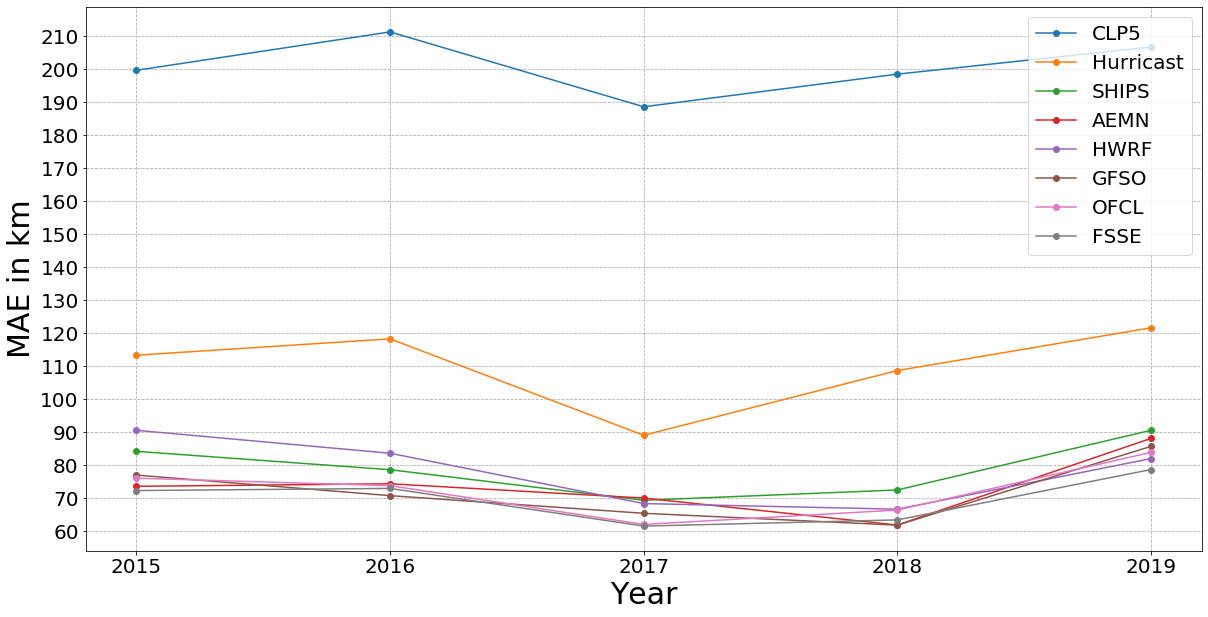

In [56]:
import matplotlib.pyplot as plt
years = [i for i in range(2015, 2020)]
plt.figure(figsize=(20,10))
plt.xticks(years, fontsize = 20)
plt.yticks([i for i in range(60, 220, 10)], fontsize = 20)
#plt.figtext(.5,.9,"Mean Average Error in km between 2015 and 2019 for different \n North Atlantic track forecast models with lead time 24h", fontsize=30, ha='center')
plt.plot(years, d1['MAES_CLP5'], label = 'CLP5', marker='o')
plt.plot(years, a, label = 'Hurricast', marker='o')
plt.plot(years, d1['MAES_SHIP'], label = 'SHIPS', marker='o')
plt.plot(years, d1['MAES_AEMN'], label = 'AEMN', marker='o')
plt.plot(years, d1['MAES_HWRF'], label = 'HWRF', marker='o')
plt.plot(years, d1['MAES_GFSO'], label = 'GFSO', marker='o')
plt.plot(years, d1['MAES_OFCL'], label = 'OFCL', marker='o')
plt.plot(years, d1['MAES_FSSE'], label = 'FSSE', marker='o')
plt.xlabel("Year", fontsize = 30)
plt.ylabel("MAE in km", fontsize = 30)
plt.legend(loc=1, prop={'size': 20})
plt.grid(linestyle='--')
plt.savefig("MAE_AN_track_24.jpg", dpi = 300)
#plt.title("Mean Average Error in km between 2015 and 2019 for each forecast model")
plt.show()

In [40]:
d2 = train_xgb_track_all_years(max_depth=5, learning_rate=0.03, n_estimators=300, subsample=0.8, basin = 'EP')

YEAR 2015
Number of timesteps: 255
EP Model | MAE | std | %age busts (>200km)
Hurricast 74.5 55.29 2.75
SHIP 72.68 44.07 0.78
HWRF 82.06 55.85 4.71
OFCL 69.07 43.77 1.18
FSSE 65.21 45.88 1.18
AEMN 73.39 44.35 1.96
GFSO 68.66 46.09 1.57
CLP5 139.5 77.24 17.25
Consensus OFCL only 63.58 40.15 0.39
Consensus OFCL + Hurricast 58.57 37.94 0.78


YEAR 2016
Number of timesteps: 315
EP Model | MAE | std | %age busts (>200km)
Hurricast 73.11 40.59 0.95
SHIP 57.85 34.92 0.32
HWRF 61.82 40.02 1.9
OFCL 54.09 34.1 0.0
FSSE 55.8 33.86 0.32
AEMN 56.33 37.91 0.63
GFSO 60.33 44.6 1.9
CLP5 113.55 58.53 7.62
Consensus OFCL only 50.84 33.91 0.0
Consensus OFCL + Hurricast 48.64 32.24 0.0


YEAR 2017
Number of timesteps: 167
EP Model | MAE | std | %age busts (>200km)
Hurricast 69.28 41.91 0.0
SHIP 59.96 35.47 0.6
HWRF 74.58 40.85 2.4
OFCL 55.2 33.37 0.0
FSSE 54.98 35.64 0.6
AEMN 68.34 40.13 1.2
GFSO 73.68 45.78 1.2
CLP5 108.57 61.48 8.38
Consensus OFCL only 57.64 34.02 0.6
Consensus OFCL + Hurricast 53.8 30.

[74.5, 73.11, 69.28, 73.46]

In [33]:
b = [72.32, 71.1, 67.85, 73.14]

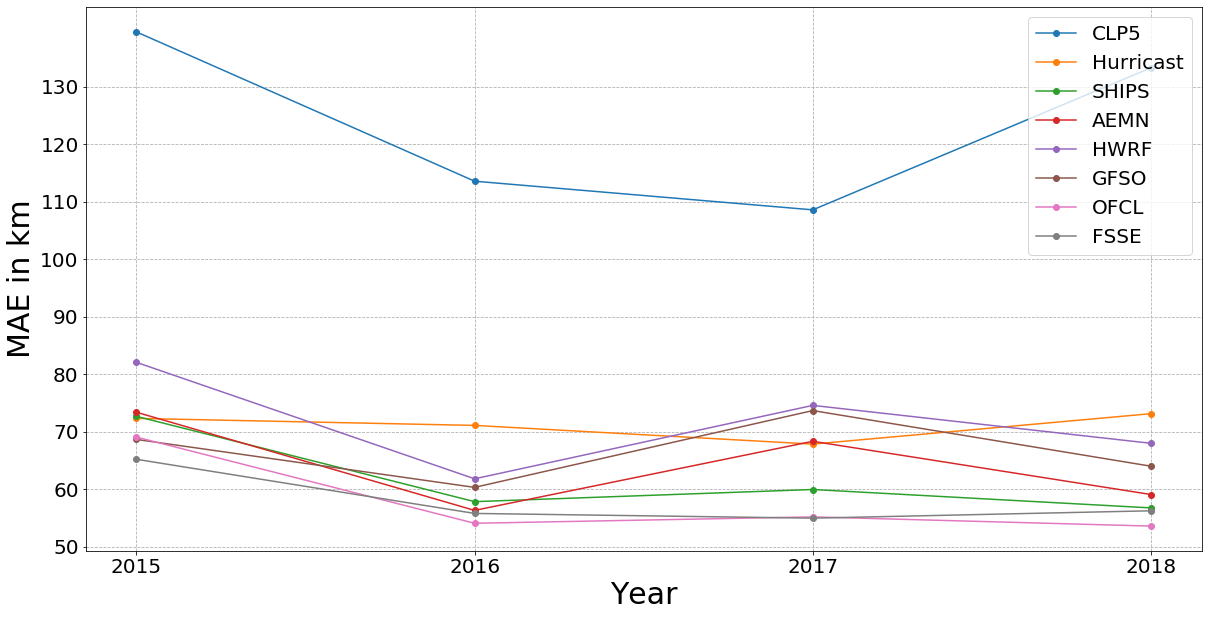

In [57]:
years = [i for i in range(2015, 2019)]
plt.figure(figsize=(20,10))
plt.xticks(years, fontsize = 20)
plt.yticks([i for i in range(50, 140, 10)], fontsize = 20)
#plt.figtext(.5,.9,"Mean Average Error in km between 2015 and 2018 for different \n East Pacific track forecast models with lead time 24h", fontsize=30, ha='center')

plt.plot(years, d2['MAES_CLP5'][:-1], label = 'CLP5', marker ='o')
plt.plot(years, b, label = 'Hurricast', marker ='o')
plt.plot(years, d2['MAES_SHIP'][:-1], label = 'SHIPS', marker ='o')
plt.plot(years, d2['MAES_AEMN'][:-1], label = 'AEMN', marker ='o')
plt.plot(years, d2['MAES_HWRF'][:-1], label = 'HWRF', marker ='o')
plt.plot(years, d2['MAES_GFSO'][:-1], label = 'GFSO', marker ='o')
plt.plot(years, d2['MAES_OFCL'][:-1], label = 'OFCL', marker ='o')
plt.plot(years, d2['MAES_FSSE'][:-1], label = 'FSSE', marker ='o')

plt.xlabel("Year", fontsize = 30)
plt.ylabel("MAE in km", fontsize = 30)
plt.legend(loc=1, prop={'size': 20})
plt.grid(linestyle='--')
plt.savefig("MAE_EP_track_24.jpg", dpi = 300)
plt.show()

# Get results old

In [450]:
#TRAIN TOTAL
max_depth = 7
n_estimators = 200
learning_rate = 0.03
subsample = 0.8
min_child_weight=5
#col_sample_by_tree = 0.7
train_x = X_train_total
train_y = X_train_total
test_x = X_test_total
test_y = X_test_total
tgt_train = tgt_displacement_train
    
xgb_x = XGBRegressor(max_depth=max_depth, n_estimators=n_estimators, learning_rate=learning_rate, subsample=subsample, min_child_weight=min_child_weight)
xgb_x.fit(train_x, tgt_train[:, 0])
xgb_y = XGBRegressor(max_depth=max_depth, n_estimators=n_estimators, learning_rate=learning_rate, subsample=subsample, min_child_weight=min_child_weight)
xgb_y.fit(train_y, tgt_train[:, 1])
DLATS_PRED = np.array(xgb_x.predict(test_x)) * std_dx + mean_dx
DLONS_PRED = np.array(xgb_y.predict(test_y)) * std_dy + mean_dy
LATS_PRED_ = X_test['LAT_7'] + DLATS_PRED
LONS_PRED_ = X_test['LON_7'] + DLONS_PRED
compare_perf_track_7cast(year = 2017, basin='AN', forecast='SHIP', forecast2 = 'HWRF', forecast3='OFCL', forecast4 = 'FSSE', forecast5='AEMN', forecast6 = 'GFSO', forecast7 = 'CLP5', LATS_PRED_= LATS_PRED_, LONS_PRED_=LONS_PRED_)
compare_perf_track_7cast(year = 2017, basin='EP', forecast='SHIP', forecast2 = 'HWRF', forecast3='OFCL', forecast4 = 'FSSE', forecast5='AEMN', forecast6 = 'GFSO', forecast7 = 'CLP5', LATS_PRED_= LATS_PRED_, LONS_PRED_=LONS_PRED_)

Number of timesteps: 669
AN Model | MAE | std | %age busts (>200km)
Hurricast 107.59 74.55 10.31
SHIP 77.06 64.11 4.04
HWRF 72.01 47.85 2.39
OFCL 70.36 57.78 2.84
FSSE 67.53 53.48 3.44
AEMN 72.81 57.98 2.54
GFSO 70.47 56.01 3.74
CLP5 197.76 142.19 36.17
Consensus OFCL only 62.67 50.49 2.09
Consensus OFCL + Hurricast 60.38 47.39 1.49
Number of timesteps: 522
EP Model | MAE | std | %age busts (>200km)
Hurricast 71.38 44.01 0.96
SHIP 57.78 33.53 0.38
HWRF 70.1 43.23 2.11
OFCL 54.11 31.63 0.19
FSSE 55.85 53.93 0.96
AEMN 62.05 36.83 0.57
GFSO 67.11 45.03 1.34
CLP5 125.37 70.95 15.13
Consensus OFCL only 53.04 33.46 0.38
Consensus OFCL + Hurricast 49.3 30.13 0.19


In [430]:
compare_perf_track_7cast(year = 2017, basin='AN', forecast='SHIP', forecast2 = 'HWRF', forecast3='OFCL', forecast4 = 'FSSE', forecast5='AEMN', forecast6 = 'GFSO', forecast7 = 'CLP5', LATS_PRED_= LATS_PRED_, LONS_PRED_=LONS_PRED_)
compare_perf_track_7cast(year = 2017, basin='EP', forecast='SHIP', forecast2 = 'HWRF', forecast3='OFCL', forecast4 = 'FSSE', forecast5='AEMN', forecast6 = 'GFSO', forecast7 = 'CLP5', LATS_PRED_= LATS_PRED_, LONS_PRED_=LONS_PRED_)

Number of timesteps: 669
AN Model | MAE | std | %age busts (>200km)
Hurricast 107.16 74.34 11.36
SHIP 77.06 64.11 4.04
HWRF 72.01 47.85 2.39
OFCL 70.36 57.78 2.84
FSSE 67.53 53.48 3.44
AEMN 72.81 57.98 2.54
GFSO 70.47 56.01 3.74
CLP5 197.76 142.19 36.17
Consensus OFCL only 62.67 50.49 2.09
Consensus OFCL + Hurricast 60.23 47.42 1.49
Number of timesteps: 522
EP Model | MAE | std | %age busts (>200km)
Hurricast 71.55 44.65 0.96
SHIP 57.78 33.53 0.38
HWRF 70.1 43.23 2.11
OFCL 54.11 31.63 0.19
FSSE 55.85 53.93 0.96
AEMN 62.05 36.83 0.57
GFSO 67.11 45.03 1.34
CLP5 125.37 70.95 15.13
Consensus OFCL only 53.04 33.46 0.38
Consensus OFCL + Hurricast 49.3 29.91 0.19


In [192]:
compare_perf_track_7cast(year = 2017, basin='AN', forecast='SHIP', forecast2 = 'HWRF', forecast3='OFCL', forecast4 = 'FSSE', forecast5='AEMN', forecast6 = 'GFSO', forecast7 = 'CLP5', LATS_PRED_=LATS_PRED_, LONS_PRED_=LONS_PRED_)
compare_perf_track_7cast(year = 2017, basin='EP', forecast='SHIP', forecast2 = 'HWRF', forecast3='OFCL', forecast4 = 'FSSE', forecast5='AEMN', forecast6 = 'GFSO', forecast7 = 'CLP5', LATS_PRED_=LATS_PRED_, LONS_PRED_=LONS_PRED_)

Number of timesteps: 669
AN Model | MAE | std | %age busts (>200km)
Hurricast 106.61 73.49 10.46
SHIP 77.06 64.11 4.04
HWRF 72.01 47.85 2.39
OFCL 70.36 57.78 2.84
FSSE 67.53 53.48 3.44
AEMN 72.81 57.98 2.54
GFSO 70.47 56.01 3.74
CLP5 197.76 142.19 36.17
Consensus OFCL only 62.67 50.49 2.09
Consensus OFCL + Hurricast 60.35 47.4 1.49


In [445]:
#TRAIN TABULAR ONLY
max_depth = 7
n_estimators = 150
learning_rate = 0.03
subsample = 0.7
min_child_weight=5
#col_sample_by_tree = 0.7
train_x = np.array(X_train)[:,1:]
train_y = train_x
test_x = np.array(X_test)
test_y = test_x
tgt_train = tgt_displacement_train
    
xgb_x = XGBRegressor(max_depth=max_depth, n_estimators=n_estimators, learning_rate=learning_rate, subsample=subsample, min_child_weight=min_child_weight)
xgb_x.fit(train_x, tgt_train[:, 0])
xgb_y = XGBRegressor(max_depth=max_depth, n_estimators=n_estimators, learning_rate=learning_rate, subsample=subsample, min_child_weight=min_child_weight)
xgb_y.fit(train_y, tgt_train[:, 1])
DLATS_PRED = np.array(xgb_x.predict(test_x)) * std_dx + mean_dx
DLONS_PRED = np.array(xgb_y.predict(test_y)) * std_dy + mean_dy
LATS_PRED_ = X_test['LAT_7'] + DLATS_PRED
LONS_PRED_ = X_test['LON_7'] + DLONS_PRED
compare_perf_track_7cast(year = 2017, basin='AN', forecast='SHIP', forecast2 = 'HWRF', forecast3='OFCL', forecast4 = 'FSSE', forecast5='AEMN', forecast6 = 'GFSO', forecast7 = 'CLP5', LATS_PRED_= LATS_PRED_, LONS_PRED_=LONS_PRED_)
compare_perf_track_7cast(year = 2017, basin='EP', forecast='SHIP', forecast2 = 'HWRF', forecast3='OFCL', forecast4 = 'FSSE', forecast5='AEMN', forecast6 = 'GFSO', forecast7 = 'CLP5', LATS_PRED_= LATS_PRED_, LONS_PRED_=LONS_PRED_)

Number of timesteps: 669
AN Model | MAE | std | %age busts (>200km)
Hurricast 173.49 120.58 29.45
SHIP 77.06 64.11 4.04
HWRF 72.01 47.85 2.39
OFCL 70.36 57.78 2.84
FSSE 67.53 53.48 3.44
AEMN 72.81 57.98 2.54
GFSO 70.47 56.01 3.74
CLP5 197.76 142.19 36.17
Consensus OFCL only 62.67 50.49 2.09
Consensus OFCL + Hurricast 67.65 49.37 2.54
Number of timesteps: 522
EP Model | MAE | std | %age busts (>200km)
Hurricast 125.54 78.41 14.18
SHIP 57.78 33.53 0.38
HWRF 70.1 43.23 2.11
OFCL 54.11 31.63 0.19
FSSE 55.85 53.93 0.96
AEMN 62.05 36.83 0.57
GFSO 67.11 45.03 1.34
CLP5 125.37 70.95 15.13
Consensus OFCL only 53.04 33.46 0.38
Consensus OFCL + Hurricast 52.92 31.36 0.19


In [457]:
#TRAIN EMBED ONLY
max_depth = 7
n_estimators = 150
learning_rate = 0.05
subsample = 0.7
min_child_weight=5
#col_sample_by_tree = 0.7
train_x = X_train_embed
train_y = train_x
test_x = X_test_embed
test_y = test_x
tgt_train = tgt_displacement_train
    
xgb_x = XGBRegressor(max_depth=max_depth, n_estimators=n_estimators, learning_rate=learning_rate, subsample=subsample, min_child_weight=min_child_weight)
xgb_x.fit(train_x, tgt_train[:, 0])
xgb_y = XGBRegressor(max_depth=max_depth, n_estimators=n_estimators, learning_rate=learning_rate, subsample=subsample, min_child_weight=min_child_weight)
xgb_y.fit(train_y, tgt_train[:, 1])
DLATS_PRED = np.array(xgb_x.predict(test_x)) * std_dx + mean_dx
DLONS_PRED = np.array(xgb_y.predict(test_y)) * std_dy + mean_dy
LATS_PRED_ = X_test['LAT_7'] + DLATS_PRED
LONS_PRED_ = X_test['LON_7'] + DLONS_PRED
compare_perf_track_7cast(year = 2017, basin='AN', forecast='SHIP', forecast2 = 'HWRF', forecast3='OFCL', forecast4 = 'FSSE', forecast5='AEMN', forecast6 = 'GFSO', forecast7 = 'CLP5', LATS_PRED_= LATS_PRED_, LONS_PRED_=LONS_PRED_)
compare_perf_track_7cast(year = 2017, basin='EP', forecast='SHIP', forecast2 = 'HWRF', forecast3='OFCL', forecast4 = 'FSSE', forecast5='AEMN', forecast6 = 'GFSO', forecast7 = 'CLP5', LATS_PRED_= LATS_PRED_, LONS_PRED_=LONS_PRED_)

Number of timesteps: 669
AN Model | MAE | std | %age busts (>200km)
Hurricast 110.88 79.15 11.51
SHIP 77.06 64.11 4.04
HWRF 72.01 47.85 2.39
OFCL 70.36 57.78 2.84
FSSE 67.53 53.48 3.44
AEMN 72.81 57.98 2.54
GFSO 70.47 56.01 3.74
CLP5 197.76 142.19 36.17
Consensus OFCL only 62.67 50.49 2.09
Consensus OFCL + Hurricast 60.8 47.42 1.49
Number of timesteps: 522
EP Model | MAE | std | %age busts (>200km)
Hurricast 71.69 43.7 0.57
SHIP 57.78 33.53 0.38
HWRF 70.1 43.23 2.11
OFCL 54.11 31.63 0.19
FSSE 55.85 53.93 0.96
AEMN 62.05 36.83 0.57
GFSO 67.11 45.03 1.34
CLP5 125.37 70.95 15.13
Consensus OFCL only 53.04 33.46 0.38
Consensus OFCL + Hurricast 49.44 30.22 0.19


In [461]:
#OFCL + TABULAR ONLY
max_depth = 6
n_estimators = 150
learning_rate = 0.05
subsample = 0.7
min_child_weight=5
#col_sample_by_tree = 0.7
train_x = X_test_baseline[:m]
train_y = train_x
test_x = X_test_baseline
test_y = test_x
tgt_train = tgt_displacement_test[:m]
    
xgb_x = XGBRegressor(max_depth=max_depth, n_estimators=n_estimators, learning_rate=learning_rate, subsample=subsample, min_child_weight=min_child_weight)
xgb_x.fit(train_x, tgt_train[:, 0])
xgb_y = XGBRegressor(max_depth=max_depth, n_estimators=n_estimators, learning_rate=learning_rate, subsample=subsample, min_child_weight=min_child_weight)
xgb_y.fit(train_y, tgt_train[:, 1])
DLATS_PRED = np.array(xgb_x.predict(test_x)) * std_dx + mean_dx
DLONS_PRED = np.array(xgb_y.predict(test_y)) * std_dy + mean_dy
LATS_PRED_ = X_test['LAT_7'] + DLATS_PRED
LONS_PRED_ = X_test['LON_7'] + DLONS_PRED
compare_perf_track_7cast(year = 2017, basin='AN', forecast='SHIP', forecast2 = 'HWRF', forecast3='OFCL', forecast4 = 'FSSE', forecast5='AEMN', forecast6 = 'GFSO', forecast7 = 'CLP5', LATS_PRED_= LATS_PRED_, LONS_PRED_=LONS_PRED_)
compare_perf_track_7cast(year = 2017, basin='EP', forecast='SHIP', forecast2 = 'HWRF', forecast3='OFCL', forecast4 = 'FSSE', forecast5='AEMN', forecast6 = 'GFSO', forecast7 = 'CLP5', LATS_PRED_= LATS_PRED_, LONS_PRED_=LONS_PRED_)

Number of timesteps: 669
AN Model | MAE | std | %age busts (>200km)
Hurricast 125.48 89.75 15.25
SHIP 77.06 64.11 4.04
HWRF 72.01 47.85 2.39
OFCL 70.36 57.78 2.84
FSSE 67.53 53.48 3.44
AEMN 72.81 57.98 2.54
GFSO 70.47 56.01 3.74
CLP5 197.76 142.19 36.17
Consensus OFCL only 62.67 50.49 2.09
Consensus OFCL + Hurricast 64.15 48.08 1.79
Number of timesteps: 522
EP Model | MAE | std | %age busts (>200km)
Hurricast 73.56 44.74 1.53
SHIP 57.78 33.53 0.38
HWRF 70.1 43.23 2.11
OFCL 54.11 31.63 0.19
FSSE 55.85 53.93 0.96
AEMN 62.05 36.83 0.57
GFSO 67.11 45.03 1.34
CLP5 125.37 70.95 15.13
Consensus OFCL only 53.04 33.46 0.38
Consensus OFCL + Hurricast 50.55 31.22 0.19


In [470]:
#OFCL + EMBED
max_depth = 7
n_estimators = 200
learning_rate = 0.05
subsample = 0.8
min_child_weight=5
#col_sample_by_tree = 0.7
train_x = np.concatenate((X_test_baseline[:m], X_test_embed[:m]), axis = 1)
train_y = train_x
test_x = np.concatenate((X_test_baseline, X_test_embed), axis = 1)
test_y = test_x
tgt_train = tgt_displacement_test[:m]
    
xgb_x = XGBRegressor(max_depth=max_depth, n_estimators=n_estimators, learning_rate=learning_rate, subsample=subsample, min_child_weight=min_child_weight)
xgb_x.fit(train_x, tgt_train[:, 0])
xgb_y = XGBRegressor(max_depth=max_depth, n_estimators=n_estimators, learning_rate=learning_rate, subsample=subsample, min_child_weight=min_child_weight)
xgb_y.fit(train_y, tgt_train[:, 1])
DLATS_PRED = np.array(xgb_x.predict(test_x)) * std_dx + mean_dx
DLONS_PRED = np.array(xgb_y.predict(test_y)) * std_dy + mean_dy
LATS_PRED_ = X_test['LAT_7'] + DLATS_PRED
LONS_PRED_ = X_test['LON_7'] + DLONS_PRED
compare_perf_track_7cast(year = 2017, basin='AN', forecast='SHIP', forecast2 = 'HWRF', forecast3='OFCL', forecast4 = 'FSSE', forecast5='AEMN', forecast6 = 'GFSO', forecast7 = 'CLP5', LATS_PRED_= LATS_PRED_, LONS_PRED_=LONS_PRED_)
compare_perf_track_7cast(year = 2017, basin='EP', forecast='SHIP', forecast2 = 'HWRF', forecast3='OFCL', forecast4 = 'FSSE', forecast5='AEMN', forecast6 = 'GFSO', forecast7 = 'CLP5', LATS_PRED_= LATS_PRED_, LONS_PRED_=LONS_PRED_)

Number of timesteps: 669
AN Model | MAE | std | %age busts (>200km)
Hurricast 94.98 65.2 7.03
SHIP 77.06 64.11 4.04
HWRF 72.01 47.85 2.39
OFCL 70.36 57.78 2.84
FSSE 67.53 53.48 3.44
AEMN 72.81 57.98 2.54
GFSO 70.47 56.01 3.74
CLP5 197.76 142.19 36.17
Consensus OFCL only 62.67 50.49 2.09
Consensus OFCL + Hurricast 60.85 47.9 1.49
Number of timesteps: 522
EP Model | MAE | std | %age busts (>200km)
Hurricast 62.99 37.23 0.38
SHIP 57.78 33.53 0.38
HWRF 70.1 43.23 2.11
OFCL 54.11 31.63 0.19
FSSE 55.85 53.93 0.96
AEMN 62.05 36.83 0.57
GFSO 67.11 45.03 1.34
CLP5 125.37 70.95 15.13
Consensus OFCL only 53.04 33.46 0.38
Consensus OFCL + Hurricast 49.97 30.82 0.19


In [490]:
x_viz_train = np.load('../data/X_train_vision_comp_1980_34_20_120.npy', allow_pickle=True).reshape(-1, 3*5*3*3)
x_viz_test = np.load('../data/X_test_vision_comp_1980_34_20_120.npy', allow_pickle=True).reshape(-1, 3*5*3*3)[-n:]
x_viz_train = np.concatenate((x_viz_train, x_viz_test[:m]), axis = 0)
X_train_total_comp = np.concatenate((X_train, x_viz_train), axis = 1)
X_test_total_comp = np.concatenate((X_test, x_viz_test), axis = 1)

In [498]:
#TRAIN TOTAL COMP
max_depth = 9
n_estimators = 150
learning_rate = 0.05
subsample = 0.8
min_child_weight=5
#col_sample_by_tree = 0.7
train_x = X_train_total_comp
train_y = train_x
test_x = X_test_total_comp
test_y = test_x
tgt_train = tgt_displacement_train
    
xgb_x = XGBRegressor(max_depth=max_depth, n_estimators=n_estimators, learning_rate=learning_rate, subsample=subsample, min_child_weight=min_child_weight)
xgb_x.fit(train_x, tgt_train[:, 0])
xgb_y = XGBRegressor(max_depth=max_depth, n_estimators=n_estimators, learning_rate=learning_rate, subsample=subsample, min_child_weight=min_child_weight)
xgb_y.fit(train_y, tgt_train[:, 1])
DLATS_PRED = np.array(xgb_x.predict(test_x)) * std_dx + mean_dx
DLONS_PRED = np.array(xgb_y.predict(test_y)) * std_dy + mean_dy
LATS_PRED_ = X_test['LAT_7'] + DLATS_PRED
LONS_PRED_ = X_test['LON_7'] + DLONS_PRED
compare_perf_track_7cast(year = 2017, basin='AN', forecast='SHIP', forecast2 = 'HWRF', forecast3='OFCL', forecast4 = 'FSSE', forecast5='AEMN', forecast6 = 'GFSO', forecast7 = 'CLP5', LATS_PRED_= LATS_PRED_, LONS_PRED_=LONS_PRED_)
compare_perf_track_7cast(year = 2017, basin='EP', forecast='SHIP', forecast2 = 'HWRF', forecast3='OFCL', forecast4 = 'FSSE', forecast5='AEMN', forecast6 = 'GFSO', forecast7 = 'CLP5', LATS_PRED_= LATS_PRED_, LONS_PRED_=LONS_PRED_)

Number of timesteps: 669
AN Model | MAE | std | %age busts (>200km)
Hurricast 134.37 96.2 17.64
SHIP 77.06 64.11 4.04
HWRF 72.01 47.85 2.39
OFCL 70.36 57.78 2.84
FSSE 67.53 53.48 3.44
AEMN 72.81 57.98 2.54
GFSO 70.47 56.01 3.74
CLP5 197.76 142.19 36.17
Consensus OFCL only 62.67 50.49 2.09
Consensus OFCL + Hurricast 63.73 47.34 2.24
Number of timesteps: 522
EP Model | MAE | std | %age busts (>200km)
Hurricast 83.35 47.74 1.53
SHIP 57.78 33.53 0.38
HWRF 70.1 43.23 2.11
OFCL 54.11 31.63 0.19
FSSE 55.85 53.93 0.96
AEMN 62.05 36.83 0.57
GFSO 67.11 45.03 1.34
CLP5 125.37 70.95 15.13
Consensus OFCL only 53.04 33.46 0.38
Consensus OFCL + Hurricast 49.45 30.4 0.19


In [193]:
compare_perf_track_7cast(year = 2017, basin='EP', forecast='SHIP', forecast2 = 'HWRF', forecast3='OFCL', forecast4 = 'FSSE', forecast5='AEMN', forecast6 = 'GFSO', forecast7 = 'CLP5', LATS_PRED_=LATS_PRED_, LONS_PRED_=LONS_PRED_)

Number of timesteps: 522
EP Model | MAE | std | %age busts (>200km)
Hurricast 71.63 45.09 1.15
SHIP 57.78 33.53 0.38
HWRF 70.1 43.23 2.11
OFCL 54.11 31.63 0.19
FSSE 55.85 53.93 0.96
AEMN 62.05 36.83 0.57
GFSO 67.11 45.03 1.34
CLP5 125.37 70.95 15.13
Consensus OFCL only 53.04 33.46 0.38
Consensus OFCL + Hurricast 49.34 30.18 0.19


In [171]:
compare_perf_track_7cast(year = 2017, basin='EP', forecast='SHIP', forecast2 = 'HWRF', forecast3='OFCL', forecast4 = 'FSSE', forecast5='AEMN', forecast6 = 'GFSO', forecast7 = 'CLP5', LATS_PRED_=LATS_PRED_, LONS_PRED_=LONS_PRED_)

Number of timesteps: 522
EP Model | MAE | std | %age busts (>200km)
Hurricast 72.12 44.77 1.15
SHIP 57.78 33.53 0.38
HWRF 70.1 43.23 2.11
OFCL 54.11 31.63 0.19
FSSE 55.85 53.93 0.96
AEMN 62.05 36.83 0.57
GFSO 67.11 45.03 1.34
CLP5 125.37 70.95 15.13
Consensus OFCL only 53.04 33.46 0.38
Consensus OFCL + Hurricast 49.34 30.08 0.19


# Consensus

In [101]:
max_depth = 7
n_estimators = 300
learning_rate = 0.03
subsample = 0.8
min_child_weight=5
#col_sample_by_tree = 0.7
train_x = X_train_total
train_y = X_train_total
test_x = X_test_total
test_y = test_x
tgt_train = tgt_displacement_train
    
xgb_x = XGBRegressor(max_depth=max_depth, n_estimators=n_estimators, learning_rate=learning_rate, subsample=subsample, min_child_weight=min_child_weight)
xgb_x.fit(train_x, tgt_train[:, 0])
xgb_y = XGBRegressor(max_depth=max_depth, n_estimators=n_estimators, learning_rate=learning_rate, subsample=subsample, min_child_weight=min_child_weight)
xgb_y.fit(train_y, tgt_train[:, 1])

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
       importance_type='gain', interaction_constraints='',
       learning_rate=0.03, max_delta_step=0, max_depth=7,
       min_child_weight=5, missing=nan, monotone_constraints='()',
       n_estimators=300, n_jobs=0, num_parallel_tree=1,
       objective='reg:squarederror', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, subsample=0.8,
       tree_method='exact', validate_parameters=1, verbosity=None)

In [169]:
year = 2016
forecast='SHIP'
forecast2 = 'HWRF'
forecast3 = 'OFCL'
forecast4 = 'FSSE'
forecast5 = 'GFSO'
forecast6 = 'AEMN'
forecast7 = 'CLP5'
mode = 'lat'
basin = 'EP'
test = X_test_total
DLATS_PRED = np.array(xgb_x.predict(test_x)) * std_dx + mean_dx
DLONS_PRED = np.array(xgb_y.predict(test_y)) * std_dy + mean_dy
LATS_PRED_ = X_test['LAT_7'] + DLATS_PRED
LONS_PRED_ = X_test['LON_7'] + DLONS_PRED

if forecast2 != None:
    if True: 
        baseline_ = X_test_baseline.loc[X_test_baseline['YEAR_0'] < year].loc[
            X_test_baseline[forecast7 + '_24_' + mode + '_7'] > -320].loc[
            X_test_baseline[forecast6 + '_24_' + mode + '_7'] > -320].loc[
            X_test_baseline[forecast5 + '_24_' + mode + '_7'] > -320].loc[
            X_test_baseline[forecast4 + '_24_' + mode + '_7'] > -320].loc[
            X_test_baseline[forecast3 + '_24_' + mode + '_7'] > -320].loc[
            X_test_baseline[forecast2 + '_24_' + mode + '_7'] > -320].loc[
            X_test_baseline[forecast + '_24_' + mode + '_7'] > -320].loc[X_test_baseline['cat_basin_' + basin + '_0'] == 1]  # .loc[#X_test_baseline['SHIP_24_'+mode+'_7'] > 0].index
        if basin == 'EP':
            baseline_ = baseline_.loc[X_test_baseline['YEAR_0'] < 2019]
        index = baseline_.index
        LATS_BASE_2 = np.array(baseline_[forecast2 + '_24_lat_7'])
        LONS_BASE_2 = np.array(baseline_[forecast2 + '_24_lon_7'])
        LATS_BASE_3 = np.array(baseline_[forecast3 + '_24_lat_7'])
        LONS_BASE_3 = np.array(baseline_[forecast3 + '_24_lon_7'])
        LATS_BASE_4 = np.array(baseline_[forecast4 + '_24_lat_7'])
        LONS_BASE_4 = np.array(baseline_[forecast4 + '_24_lon_7'])
        LATS_BASE_5 = np.array(baseline_[forecast5 + '_24_lat_7'])
        LONS_BASE_5 = np.array(baseline_[forecast5 + '_24_lon_7'])
        LATS_BASE_6 = np.array(baseline_[forecast6 + '_24_lat_7'])
        LONS_BASE_6 = np.array(baseline_[forecast6 + '_24_lon_7'])
        LATS_BASE_7 = np.array(baseline_[forecast7 + '_24_lat_7'])
        LONS_BASE_7 = np.array(baseline_[forecast7 + '_24_lon_7'])
        
    LATS_TEST_t = np.array(X_test['LAT_7'] + np.array(tgt_displacement_test[:, 0])*std_dx+mean_dx)[index]
    LONS_TEST_t = np.array(X_test['LON_7'] + np.array(tgt_displacement_test[:, 1])*std_dy+mean_dy)[index]
    tgt_x = (np.array(tgt_displacement_test[:, 0])*std_dx+mean_dx)[index]
    tgt_y = (np.array(tgt_displacement_test[:, 1])*std_dy+mean_dy)[index]
    baseline_1_x = np.array(baseline_[forecast + '_24_'+mode+'_7'])
    baseline_1_y = np.array(baseline_[forecast + '_24_lon_7'])
    baseline_2_x = np.array(baseline_[forecast2 + '_24_'+mode+'_7'])
    baseline_2_y = np.array(baseline_[forecast2 + '_24_lon_7'])
    baseline_3_x = np.array(baseline_[forecast3 + '_24_'+mode+'_7'])
    baseline_3_y = np.array(baseline_[forecast3 + '_24_lon_7'])
    baseline_4_x = np.array(baseline_[forecast4 + '_24_'+mode+'_7'])
    baseline_4_y = np.array(baseline_[forecast4 + '_24_lon_7'])
    baseline_5_x = np.array(baseline_[forecast5 + '_24_'+mode+'_7'])
    baseline_5_y = np.array(baseline_[forecast5 + '_24_lon_7'])
    baseline_6_x = np.array(baseline_[forecast6 + '_24_'+mode+'_7'])
    baseline_6_y = np.array(baseline_[forecast6 + '_24_lon_7'])
    baseline_7_x = np.array(baseline_[forecast7 + '_24_'+mode+'_7'])
    baseline_7_y = np.array(baseline_[forecast7 + '_24_lon_7'])
    LATS_PRED_t = np.array(LATS_PRED_)[index]
    LONS_PRED_t = np.array(LONS_PRED_)[index]
    
    for i in range(len(LATS_PRED_t)):
        if baseline_2_y[i] > 160:
            baseline_1_y[i] -= 360
            baseline_6_y[i] -= 360
            baseline_5_y[i] -= 360
            baseline_2_y[i] -= 360
            baseline_3_y[i] -= 360
        if LONS_PRED_t[i] > 160:
            LONS_PRED_t[i] -= 360
            
            
    train_consensus_x = np.stack((baseline_1_x, baseline_2_x, baseline_3_x, baseline_4_x, baseline_5_x, baseline_6_x), axis = 1)
    train_consensus_y = np.stack((baseline_1_y, baseline_2_y, baseline_3_y, baseline_4_y, baseline_5_y, baseline_6_y), axis = 1)
    train_consensus_hurr_x = np.stack((baseline_1_x, baseline_2_x, baseline_3_x, baseline_4_x, baseline_5_x, baseline_6_x, LATS_PRED_t), axis = 1)
    train_consensus_hurr_y = np.stack((baseline_1_y, baseline_2_y, baseline_3_y, baseline_4_y, baseline_5_y, baseline_6_y, LONS_PRED_t), axis = 1)

base = np.array(X_test['LAT_7'])[index]
for a in base:
    if a > 160:
        a-=360
base_x = np.stack((base, base, base, base, base, base), axis = 1)
train_consensus_x = train_consensus_x - base_x
base_x = np.stack((base, base, base, base, base, base, base), axis = 1)
train_consensus_hurr_x = train_consensus_hurr_x - base_x

base = np.array(X_test['LON_7'])[index]
for a in base:
    if a > 160:
        a-=360
base_y = np.stack((base, base, base, base, base, base), axis = 1)
train_consensus_y = train_consensus_y - base_y
base_y = np.stack((base, base, base, base, base, base, base), axis = 1)
train_consensus_hurr_y = train_consensus_hurr_y - base_y

if forecast2 != None:
    if True:
        baseline_ = X_test_baseline.loc[X_test_baseline['YEAR_0'] == year].loc[
            X_test_baseline[forecast7 + '_24_' + mode + '_7'] > -320].loc[
            X_test_baseline[forecast6 + '_24_' + mode + '_7'] > -320].loc[
            X_test_baseline[forecast5 + '_24_' + mode + '_7'] > -320].loc[
            X_test_baseline[forecast4 + '_24_' + mode + '_7'] > -320].loc[
            X_test_baseline[forecast3 + '_24_' + mode + '_7'] > -320].loc[
            X_test_baseline[forecast2 + '_24_' + mode + '_7'] > -320].loc[
            X_test_baseline[forecast + '_24_' + mode + '_7'] > -320].loc[X_test_baseline['cat_basin_' + basin + '_0'] == 1]  # .loc[#X_test_baseline['SHIP_24_'+mode+'_7'] > 0].index
        if basin == 'EP':
            baseline_ = baseline_.loc[X_test_baseline['YEAR_0'] < 2019]
        index = baseline_.index
        LATS_BASE_2 = np.array(baseline_[forecast2 + '_24_lat_7'])
        LONS_BASE_2 = np.array(baseline_[forecast2 + '_24_lon_7'])
        LATS_BASE_3 = np.array(baseline_[forecast3 + '_24_lat_7'])
        LONS_BASE_3 = np.array(baseline_[forecast3 + '_24_lon_7'])
        LATS_BASE_4 = np.array(baseline_[forecast4 + '_24_lat_7'])
        LONS_BASE_4 = np.array(baseline_[forecast4 + '_24_lon_7'])
        LATS_BASE_5 = np.array(baseline_[forecast5 + '_24_lat_7'])
        LONS_BASE_5 = np.array(baseline_[forecast5 + '_24_lon_7'])
        LATS_BASE_6 = np.array(baseline_[forecast6 + '_24_lat_7'])
        LONS_BASE_6 = np.array(baseline_[forecast6 + '_24_lon_7'])
        LATS_BASE_7 = np.array(baseline_[forecast7 + '_24_lat_7'])
        LONS_BASE_7 = np.array(baseline_[forecast7 + '_24_lon_7'])
        
    LATS_TEST_te = np.array(X_test['LAT_7'] + np.array(tgt_displacement_test[:, 0])*std_dx+mean_dx)[index]
    LONS_TEST_te = np.array(X_test['LON_7'] + np.array(tgt_displacement_test[:, 1])*std_dy+mean_dy)[index]
    or_te_x = np.array(X_test['LAT_7'])[index]
    or_te_y = np.array(X_test['LON_7'])[index]
    baseline_1_x = np.array(baseline_[forecast + '_24_'+mode+'_7'])
    baseline_1_y = np.array(baseline_[forecast + '_24_lon_7'])
    baseline_2_x = np.array(baseline_[forecast2 + '_24_'+mode+'_7'])
    baseline_2_y = np.array(baseline_[forecast2 + '_24_lon_7'])
    baseline_3_x = np.array(baseline_[forecast3 + '_24_'+mode+'_7'])
    baseline_3_y = np.array(baseline_[forecast3 + '_24_lon_7'])
    baseline_4_x = np.array(baseline_[forecast4 + '_24_'+mode+'_7'])
    baseline_4_y = np.array(baseline_[forecast4 + '_24_lon_7'])
    baseline_5_x = np.array(baseline_[forecast5 + '_24_'+mode+'_7'])
    baseline_5_y = np.array(baseline_[forecast5 + '_24_lon_7'])
    baseline_6_x = np.array(baseline_[forecast6 + '_24_'+mode+'_7'])
    baseline_6_y = np.array(baseline_[forecast6 + '_24_lon_7'])
    baseline_7_x = np.array(baseline_[forecast7 + '_24_'+mode+'_7'])
    baseline_7_y = np.array(baseline_[forecast7 + '_24_lon_7'])
    LATS_PRED_te = np.array(LATS_PRED_)[index]
    LONS_PRED_te = np.array(LONS_PRED_)[index]
    
    for i in range(len(LATS_PRED_te)):
        if baseline_2_y[i] > 160:
            baseline_1_y[i] -= 360
            baseline_6_y[i] -= 360
            baseline_5_y[i] -= 360
            baseline_2_y[i] -= 360
            baseline_3_y[i] -= 360
        if LONS_PRED_te[i] > 160:
            LONS_PRED_te[i] -= 360
            
            
    test_consensus_x = np.stack((baseline_1_x, baseline_2_x, baseline_3_x, baseline_4_x, baseline_5_x, baseline_6_x), axis = 1)
    test_consensus_y = np.stack((baseline_1_y, baseline_2_y, baseline_3_y, baseline_4_y, baseline_5_y, baseline_6_y), axis = 1)
    test_consensus_hurr_x = np.stack((baseline_1_x, baseline_2_x, baseline_3_x, baseline_4_x, baseline_5_x, baseline_6_x, LATS_PRED_te), axis = 1)
    test_consensus_hurr_y = np.stack((baseline_1_y, baseline_2_y, baseline_3_y, baseline_4_y, baseline_5_y, baseline_6_y, LONS_PRED_te), axis = 1)

In [170]:
base = np.array(X_test['LAT_7'])[index]
for a in base:
    if a > 160:
        a-=360
base_x = np.stack((base, base, base, base, base, base), axis = 1)
test_consensus_x = test_consensus_x - base_x
base_x = np.stack((base, base, base, base, base, base, base), axis = 1)
test_consensus_hurr_x = test_consensus_hurr_x - base_x

base = np.array(X_test['LON_7'])[index]
for i in range(len(base)):
    if base[i] > 160:
        base[i]-=360
base_y = np.stack((base, base, base, base, base, base), axis = 1)
test_consensus_y = test_consensus_y - base_y
base_y = np.stack((base, base, base, base, base, base, base), axis = 1)
test_consensus_hurr_y = test_consensus_hurr_y - base_y

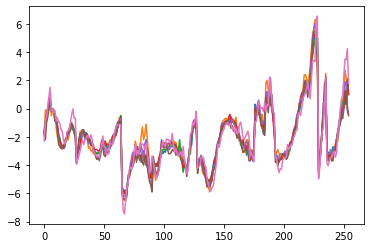

In [171]:
plt.plot(train_consensus_hurr_y)
plt.show()

In [172]:
ss = StandardScaler()
train_consensus_x = ss.fit_transform(train_consensus_x)
test_consensus_x = ss.transform(test_consensus_x)
ss2 = StandardScaler()
train_consensus_y = ss.fit_transform(train_consensus_y)
test_consensus_y = ss.transform(test_consensus_y)

ss3 = StandardScaler()
train_consensus_hurr_x = ss3.fit_transform(train_consensus_hurr_x)
test_consensus_hurr_x = ss3.transform(test_consensus_hurr_x)

ss4 = StandardScaler()
train_consensus_hurr_y = ss4.fit_transform(train_consensus_hurr_y)
test_consensus_hurr_y = ss4.transform(test_consensus_hurr_y)

In [173]:
#AN
m_x = Lasso(alpha = 1e-2)
m_x.fit(train_consensus_x, tgt_x)
preds_x = np.array(m_x.predict(test_consensus_x))+np.array(X_test['LAT_7'])[index]

m_y = Lasso(alpha = 1e-2)
m_y.fit(train_consensus_y, tgt_y)
preds_y = np.array(m_y.predict(test_consensus_y)) + base
d_km_pred = np.zeros(len(preds_y))
for i in range(len(LATS_PRED_te)):
    d_km_pred[i] = get_distance_km(preds_y[i], preds_x[i], LONS_TEST_te[i], LATS_TEST_te[i])
    
print("Number of timesteps:", len(LATS_PRED_te))
print(basin, 'Model | MAE | std | %age busts (>200km)')
print("Lasso consensus w/o hurricast", np.around(d_km_pred.mean(), decimals = 2), np.around(d_km_pred.std(), decimals = 2), np.around(sum(d_km_pred > 200)*100/len(LATS_PRED_te), decimals = 2))

Number of timesteps: 315
EP Model | MAE | std | %age busts (>200km)
Lasso consensus w/o hurricast 52.92 33.75 0.0


In [160]:
m_x.coef_

array([0.11675539, 0.12194418, 0.06753393, 0.04809728, 0.        ,
       0.4216699 , 0.42720285], dtype=float32)

In [176]:
#AN
m_x = Lasso(alpha = 1e-2)
m_x.fit(train_consensus_hurr_x, tgt_x)
preds_x = np.array(m_x.predict(test_consensus_hurr_x))+np.array(X_test['LAT_7'])[index]

m_y = Lasso(alpha = 1e-2)
m_y.fit(train_consensus_hurr_y, tgt_y)
preds_y = np.array(m_y.predict(test_consensus_hurr_y)) + base
d_km_pred = np.zeros(len(preds_y))
for i in range(len(LATS_PRED_te)):
    d_km_pred[i] = get_distance_km(preds_y[i], preds_x[i], LONS_TEST_te[i], LATS_TEST_te[i])
    
print("Number of timesteps:", len(LATS_PRED_te))
print(basin, 'Model | MAE | std | %age busts (>200km)')
print("Lasso consensus w/ hurricast", np.around(d_km_pred.mean(), decimals = 2), np.around(d_km_pred.std(), decimals = 2), np.around(sum(d_km_pred > 200)*100/len(LATS_PRED_te), decimals = 2))

Number of timesteps: 315
EP Model | MAE | std | %age busts (>200km)
Lasso consensus w/ hurricast 50.36 32.77 0.0


In [258]:
1 - 9.8/13.5

0.274074074074074

# Old again

In [510]:
index_t = X_train.loc[X_train['cat_basin_AN_0'] + X_train['cat_basin_EP_0'] == 1].index
index_te = X_test[:17094].loc[X_test['cat_basin_AN_0'] + X_test['cat_basin_EP_0'] == 1].index
train = np.concatenate((X_train_total[index_t], X_test_total[index_te]), axis = 0)
tgt_train_ = np.concatenate((tgt_displacement_train[index_t], tgt_displacement_test[index_te]), axis = 0)

In [514]:
#TRAIN TOTAL
max_depth = 7
n_estimators = 150
learning_rate = 0.05
subsample = 0.8
min_child_weight=5
#col_sample_by_tree = 0.7
train_x = train
train_y = train_x
test_x = X_test_total
test_y = X_test_total
tgt_train = tgt_train_
    
xgb_x = XGBRegressor(max_depth=max_depth, n_estimators=n_estimators, learning_rate=learning_rate, subsample=subsample, min_child_weight=min_child_weight)
xgb_x.fit(train_x, tgt_train[:, 0])
xgb_y = XGBRegressor(max_depth=max_depth, n_estimators=n_estimators, learning_rate=learning_rate, subsample=subsample, min_child_weight=min_child_weight)
xgb_y.fit(train_y, tgt_train[:, 1])
DLATS_PRED = np.array(xgb_x.predict(test_x)) * std_dx + mean_dx
DLONS_PRED = np.array(xgb_y.predict(test_y)) * std_dy + mean_dy
LATS_PRED_ = X_test['LAT_7'] + DLATS_PRED
LONS_PRED_ = X_test['LON_7'] + DLONS_PRED
compare_perf_track_7cast(year = 2017, basin='AN', forecast='SHIP', forecast2 = 'HWRF', forecast3='OFCL', forecast4 = 'FSSE', forecast5='AEMN', forecast6 = 'GFSO', forecast7 = 'CLP5', LATS_PRED_= LATS_PRED_, LONS_PRED_=LONS_PRED_)
compare_perf_track_7cast(year = 2017, basin='EP', forecast='SHIP', forecast2 = 'HWRF', forecast3='OFCL', forecast4 = 'FSSE', forecast5='AEMN', forecast6 = 'GFSO', forecast7 = 'CLP5', LATS_PRED_= LATS_PRED_, LONS_PRED_=LONS_PRED_)

Number of timesteps: 669
AN Model | MAE | std | %age busts (>200km)
Hurricast 109.44 75.91 11.36
SHIP 77.06 64.11 4.04
HWRF 72.01 47.85 2.39
OFCL 70.36 57.78 2.84
FSSE 67.53 53.48 3.44
AEMN 72.81 57.98 2.54
GFSO 70.47 56.01 3.74
CLP5 197.76 142.19 36.17
Consensus OFCL only 62.67 50.49 2.09
Consensus OFCL + Hurricast 60.48 47.27 1.49
Number of timesteps: 522
EP Model | MAE | std | %age busts (>200km)
Hurricast 71.31 43.96 0.77
SHIP 57.78 33.53 0.38
HWRF 70.1 43.23 2.11
OFCL 54.11 31.63 0.19
FSSE 55.85 53.93 0.96
AEMN 62.05 36.83 0.57
GFSO 67.11 45.03 1.34
CLP5 125.37 70.95 15.13
Consensus OFCL only 53.04 33.46 0.38
Consensus OFCL + Hurricast 49.29 30.13 0.19


In [518]:
index_t = X_test_baseline[:m].loc[X_test_baseline['cat_basin_AN_0'] + X_test_baseline['cat_basin_EP_0'] == 1].index
train = np.concatenate((np.array(X_test_baseline[:m])[index_t], X_test_embed[index_t]), axis = 1)
tgt_train_ = tgt_displacement_test[index_t]

In [555]:
#TRAIN TOTAL
max_depth = 8
n_estimators = 150
learning_rate = 0.07
subsample = 0.7
min_child_weight=1
#col_sample_by_tree = 0.7
train_x = train
train_y = train_x
test_x = np.concatenate((X_test_baseline, X_test_embed), axis = 1)
test_y = test_x
tgt_train = tgt_train_
    
xgb_x = XGBRegressor(max_depth=max_depth, n_estimators=n_estimators, learning_rate=learning_rate, subsample=subsample, min_child_weight=min_child_weight)
xgb_x.fit(train_x, tgt_train[:, 0])
xgb_y = XGBRegressor(max_depth=max_depth, n_estimators=n_estimators, learning_rate=learning_rate, subsample=subsample, min_child_weight=min_child_weight)
xgb_y.fit(train_y, tgt_train[:, 1])
DLATS_PRED = np.array(xgb_x.predict(test_x)) * std_dx + mean_dx
DLONS_PRED = np.array(xgb_y.predict(test_y)) * std_dy + mean_dy
LATS_PRED_ = X_test['LAT_7'] + DLATS_PRED
LONS_PRED_ = X_test['LON_7'] + DLONS_PRED
a, b = compare_perf_track_7cast(year = 2017, basin='AN', forecast='SHIP', forecast2 = 'HWRF', forecast3='OFCL', forecast4 = 'FSSE', forecast5='AEMN', forecast6 = 'GFSO', forecast7 = 'CLP5', LATS_PRED_= LATS_PRED_, LONS_PRED_=LONS_PRED_)
c, d = compare_perf_track_7cast(year = 2017, basin='EP', forecast='SHIP', forecast2 = 'HWRF', forecast3='OFCL', forecast4 = 'FSSE', forecast5='AEMN', forecast6 = 'GFSO', forecast7 = 'CLP5', LATS_PRED_= LATS_PRED_, LONS_PRED_=LONS_PRED_)

Number of timesteps: 669
AN Model | MAE | std | %age busts (>200km)
Hurricast 100.64 82.46 8.52
SHIP 77.06 64.11 4.04
HWRF 72.01 47.85 2.39
OFCL 70.36 57.78 2.84
FSSE 67.53 53.48 3.44
AEMN 72.81 57.98 2.54
GFSO 70.47 56.01 3.74
CLP5 197.76 142.19 36.17
Consensus OFCL only 62.67 50.49 2.09
Consensus OFCL + Hurricast 61.57 48.15 1.49
Number of timesteps: 522
EP Model | MAE | std | %age busts (>200km)
Hurricast 58.91 32.78 0.38
SHIP 57.78 33.53 0.38
HWRF 70.1 43.23 2.11
OFCL 54.11 31.63 0.19
FSSE 55.85 53.93 0.96
AEMN 62.05 36.83 0.57
GFSO 67.11 45.03 1.34
CLP5 125.37 70.95 15.13
Consensus OFCL only 53.04 33.46 0.38
Consensus OFCL + Hurricast 50.4 31.16 0.38


In [610]:
a[217:220] > 400

array([ True,  True,  True])

In [556]:
b = pd.DataFrame(b)
b.columns = cols

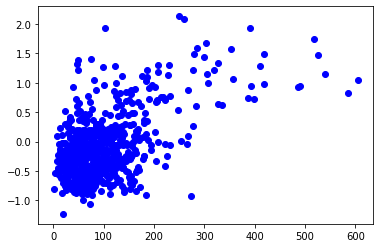

In [599]:
plt.plot(a, b['STORM_DISPLACEMENT_Y_7'], 'bo')

In [587]:
e = pd.DataFrame(a)
e.columns = ['Target']

,Target
0,29.570558
1,94.404688
2,144.106247
3,110.543451
4,30.600302
...,...
664,356.724132
665,81.134094
666,306.872005
667,303.261238


In [593]:
df = pd.concat((b, e), axis = 1)

In [616]:
df.iloc[217][-30:]

STORM_DISPLACEMENT_Y_5       0.566200
LAT_6                       32.985100
LON_6                      -30.674999
WMO_WIND_6                  90.000000
WMO_PRES_6                 966.500000
DIST2LAND_6               1425.000000
STORM_SPEED_6               17.000000
COS_STORM_DIR_6              0.469472
SIN_STORM_DIR_6              0.882948
COS_LAT_6                    0.838812
SIN_LAT_6                    0.544421
COS_LON_6                    0.860075
SIN_LON_6                   -0.510168
STORM_DISPLACEMENT_X_6       0.385100
STORM_DISPLACEMENT_Y_6       0.825000
LAT_7                       33.400002
LON_7                      -29.700001
WMO_WIND_7                  95.000000
WMO_PRES_7                 963.000000
DIST2LAND_7               1353.000000
STORM_SPEED_7               18.000000
COS_STORM_DIR_7              0.438371
SIN_STORM_DIR_7              0.898794
COS_LAT_7                    0.834848
SIN_LAT_7                    0.550481
COS_LON_7                    0.868632
SIN_LON_7   

In [598]:
df.corrwith(df['Target'])[-30:]

STORM_DISPLACEMENT_Y_5    0.528886
LAT_6                     0.361303
LON_6                     0.257946
WMO_WIND_6               -0.213017
WMO_PRES_6                0.156788
DIST2LAND_6               0.181879
STORM_SPEED_6             0.430201
COS_STORM_DIR_6           0.030040
SIN_STORM_DIR_6           0.443096
COS_LAT_6                -0.404716
SIN_LAT_6                 0.349151
COS_LON_6                 0.249357
SIN_LON_6                 0.263808
STORM_DISPLACEMENT_X_6    0.304211
STORM_DISPLACEMENT_Y_6    0.543905
LAT_7                     0.369798
LON_7                     0.274303
WMO_WIND_7               -0.215459
WMO_PRES_7                0.160926
DIST2LAND_7               0.183372
STORM_SPEED_7             0.450341
COS_STORM_DIR_7           0.029825
SIN_STORM_DIR_7           0.435316
COS_LAT_7                -0.414633
SIN_LAT_7                 0.356799
COS_LON_7                 0.263034
SIN_LON_7                 0.285186
STORM_DISPLACEMENT_X_7    0.318487
STORM_DISPLACEMENT_Y

# New results

## STAT ONLY

In [30]:
train_xgb_track_all_years(X_train, X_test, tgt_displacement_train, max_depth=6, learning_rate=0.03, n_estimators=200, subsample=0.8, min_child_weight = 5, basin = 'EP')

YEAR 2016
Number of timesteps: 315
EP Model | MAE | std | %age busts (>200km)
Hurricast 83.34 49.27 3.49
SHIP 57.85 34.92 0.32
HWRF 61.82 40.02 1.9
OFCL 54.09 34.1 0.0
FSSE 55.8 33.86 0.32
GFSO 60.33 44.6 1.9
AEMN 56.33 37.91 0.63
CLP5 113.55 58.53 7.62
Consensus OFCL only 50.84 33.91 0.0
Consensus OFCL + Hurricast 47.71 31.79 0.0


YEAR 2017
Number of timesteps: 167
EP Model | MAE | std | %age busts (>200km)
Hurricast 74.73 41.61 0.6
SHIP 59.96 35.47 0.6
HWRF 74.58 40.85 2.4
OFCL 55.2 33.37 0.0
FSSE 54.98 35.64 0.6
GFSO 73.68 45.78 1.2
AEMN 68.34 40.13 1.2
CLP5 108.57 61.48 8.38
Consensus OFCL only 57.64 34.02 0.6
Consensus OFCL + Hurricast 51.59 31.34 0.0


YEAR 2018
Number of timesteps: 355
EP Model | MAE | std | %age busts (>200km)
Hurricast 93.21 52.67 3.94
SHIP 56.76 32.53 0.28
HWRF 67.99 44.14 1.97
OFCL 53.6 30.77 0.28
FSSE 56.26 60.66 1.13
GFSO 64.01 44.34 1.41
AEMN 59.09 34.78 0.28
CLP5 133.27 73.69 18.31
Consensus OFCL only 50.88 32.97 0.28
Consensus OFCL + Hurricast 49.14 30

{'MAES_AEMN': [60.33, 73.68, 64.01],
 'MAES_CLP5': [113.55, 108.57, 133.27],
 'MAES_FSSE': [55.8, 54.98, 56.26],
 'MAES_GFSO': [56.33, 68.34, 59.09],
 'MAES_HWRF': [61.82, 74.58, 67.99],
 'MAES_OFCL': [54.09, 55.2, 53.6],
 'MAES_SHIP': [57.85, 59.96, 56.76],
 'MAEs_full': [83.34, 74.73, 93.21],
 'num_samples': [315, 167, 355],
 'std_AEMN': [44.6, 45.78, 44.34],
 'std_CLP5': [58.53, 61.48, 73.69],
 'std_FSSE': [33.86, 35.64, 60.66],
 'std_GFSO': [37.91, 40.13, 34.78],
 'std_HWRF': [40.02, 40.85, 44.14],
 'std_OFCL': [34.1, 33.37, 30.77],
 'std_SHIP': [34.92, 35.47, 32.53],
 'std_full': [49.27, 41.61, 52.67],
 'year': [2016, 2017, 2018]}

## TENSOR COMP

In [182]:
train_xgb_track_all_years(X_train_total_comp, X_test_total_comp, tgt_displacement_train, max_depth=9, learning_rate=0.03, n_estimators=200, subsample=0.8, min_child_weight = 5, basin = 'EP')

YEAR 2016
Number of timesteps: 315
EP Model | MAE | std | %age busts (>200km)
Hurricast 80.45 48.16 3.49
SHIP 57.85 34.92 0.32
HWRF 61.82 40.02 1.9
OFCL 54.09 34.1 0.0
FSSE 55.8 33.86 0.32
GFSO 60.33 44.6 1.9
AEMN 56.33 37.91 0.63
CLP5 113.55 58.53 7.62
Consensus OFCL only 50.84 33.91 0.0
Consensus OFCL + Hurricast 47.32 31.6 0.0


YEAR 2017
Number of timesteps: 167
EP Model | MAE | std | %age busts (>200km)
Hurricast 72.09 39.81 0.6
SHIP 59.96 35.47 0.6
HWRF 74.58 40.85 2.4
OFCL 55.2 33.37 0.0
FSSE 54.98 35.64 0.6
GFSO 73.68 45.78 1.2
AEMN 68.34 40.13 1.2
CLP5 108.57 61.48 8.38
Consensus OFCL only 57.64 34.02 0.6
Consensus OFCL + Hurricast 51.81 31.04 0.0


YEAR 2018
Number of timesteps: 355
EP Model | MAE | std | %age busts (>200km)
Hurricast 88.19 50.13 2.25
SHIP 56.76 32.53 0.28
HWRF 67.99 44.14 1.97
OFCL 53.6 30.77 0.28
FSSE 56.26 60.66 1.13
GFSO 64.01 44.34 1.41
AEMN 59.09 34.78 0.28
CLP5 133.27 73.69 18.31
Consensus OFCL only 50.88 32.97 0.28
Consensus OFCL + Hurricast 48.48 29.

{'MAES_AEMN': [60.33, 73.68, 64.01],
 'MAES_CLP5': [113.55, 108.57, 133.27],
 'MAES_FSSE': [55.8, 54.98, 56.26],
 'MAES_GFSO': [56.33, 68.34, 59.09],
 'MAES_HWRF': [61.82, 74.58, 67.99],
 'MAES_OFCL': [54.09, 55.2, 53.6],
 'MAES_SHIP': [57.85, 59.96, 56.76],
 'MAEs_full': [80.45, 72.09, 88.19],
 'num_samples': [315, 167, 355],
 'std_AEMN': [44.6, 45.78, 44.34],
 'std_CLP5': [58.53, 61.48, 73.69],
 'std_FSSE': [33.86, 35.64, 60.66],
 'std_GFSO': [37.91, 40.13, 34.78],
 'std_HWRF': [40.02, 40.85, 44.14],
 'std_OFCL': [34.1, 33.37, 30.77],
 'std_SHIP': [34.92, 35.47, 32.53],
 'std_full': [48.16, 39.81, 50.13],
 'year': [2016, 2017, 2018]}

## TOTAL

In [49]:
train_xgb_track_all_years(X_train_total, X_test_total, tgt_displacement_train, max_depth=9, learning_rate=0.03, n_estimators=200, subsample=0.8, min_child_weight = 5, basin = 'EP')

YEAR 2016
Number of timesteps: 315
EP Model | MAE | std | %age busts (>200km)
Hurricast 71.68 39.17 0.63
SHIP 57.85 34.92 0.32
HWRF 61.82 40.02 1.9
OFCL 54.09 34.1 0.0
FSSE 55.8 33.86 0.32
GFSO 60.33 44.6 1.9
AEMN 56.33 37.91 0.63
CLP5 113.55 58.53 7.62
Consensus OFCL only 50.84 33.91 0.0
Consensus OFCL + Hurricast 48.25 32.11 0.0


YEAR 2017
Number of timesteps: 167
EP Model | MAE | std | %age busts (>200km)
Hurricast 68.68 42.09 0.0
SHIP 59.96 35.47 0.6
HWRF 74.58 40.85 2.4
OFCL 55.2 33.37 0.0
FSSE 54.98 35.64 0.6
GFSO 73.68 45.78 1.2
AEMN 68.34 40.13 1.2
CLP5 108.57 61.48 8.38
Consensus OFCL only 57.64 34.02 0.6
Consensus OFCL + Hurricast 53.79 30.42 0.0


YEAR 2018
Number of timesteps: 355
EP Model | MAE | std | %age busts (>200km)
Hurricast 72.9 45.92 1.97
SHIP 56.76 32.53 0.28
HWRF 67.99 44.14 1.97
OFCL 53.6 30.77 0.28
FSSE 56.26 60.66 1.13
GFSO 64.01 44.34 1.41
AEMN 59.09 34.78 0.28
CLP5 133.27 73.69 18.31
Consensus OFCL only 50.88 32.97 0.28
Consensus OFCL + Hurricast 47.29 29.

{'MAES_AEMN': [60.33, 73.68, 64.01],
 'MAES_CLP5': [113.55, 108.57, 133.27],
 'MAES_FSSE': [55.8, 54.98, 56.26],
 'MAES_GFSO': [56.33, 68.34, 59.09],
 'MAES_HWRF': [61.82, 74.58, 67.99],
 'MAES_OFCL': [54.09, 55.2, 53.6],
 'MAES_SHIP': [57.85, 59.96, 56.76],
 'MAEs_full': [71.68, 68.68, 72.9],
 'num_samples': [315, 167, 355],
 'std_AEMN': [44.6, 45.78, 44.34],
 'std_CLP5': [58.53, 61.48, 73.69],
 'std_FSSE': [33.86, 35.64, 60.66],
 'std_GFSO': [37.91, 40.13, 34.78],
 'std_HWRF': [40.02, 40.85, 44.14],
 'std_OFCL': [34.1, 33.37, 30.77],
 'std_SHIP': [34.92, 35.47, 32.53],
 'std_full': [39.17, 42.09, 45.92],
 'year': [2016, 2017, 2018]}

In [37]:
#EMBED
train_xgb_track_all_years(X_train_embed, X_test_embed, tgt_displacement_train, max_depth=6, learning_rate=0.03, n_estimators=300, subsample=0.8, basin = 'EP')

YEAR 2016
Number of timesteps: 315
EP Model | MAE | std | %age busts (>200km)
Hurricast 74.88 40.81 0.95
SHIP 57.85 34.92 0.32
HWRF 61.82 40.02 1.9
OFCL 54.09 34.1 0.0
FSSE 55.8 33.86 0.32
GFSO 60.33 44.6 1.9
AEMN 56.33 37.91 0.63
CLP5 113.55 58.53 7.62
Consensus OFCL only 50.84 33.91 0.0
Consensus OFCL + Hurricast 48.88 32.6 0.0


YEAR 2017
Number of timesteps: 167
EP Model | MAE | std | %age busts (>200km)
Hurricast 69.6 41.85 0.0
SHIP 59.96 35.47 0.6
HWRF 74.58 40.85 2.4
OFCL 55.2 33.37 0.0
FSSE 54.98 35.64 0.6
GFSO 73.68 45.78 1.2
AEMN 68.34 40.13 1.2
CLP5 108.57 61.48 8.38
Consensus OFCL only 57.64 34.02 0.6
Consensus OFCL + Hurricast 54.17 30.51 0.0


YEAR 2018
Number of timesteps: 355
EP Model | MAE | std | %age busts (>200km)
Hurricast 72.77 44.06 0.56
SHIP 56.76 32.53 0.28
HWRF 67.99 44.14 1.97
OFCL 53.6 30.77 0.28
FSSE 56.26 60.66 1.13
GFSO 64.01 44.34 1.41
AEMN 59.09 34.78 0.28
CLP5 133.27 73.69 18.31
Consensus OFCL only 50.88 32.97 0.28
Consensus OFCL + Hurricast 47.31 29.8

{'MAES_AEMN': [60.33, 73.68, 64.01],
 'MAES_CLP5': [113.55, 108.57, 133.27],
 'MAES_FSSE': [55.8, 54.98, 56.26],
 'MAES_GFSO': [56.33, 68.34, 59.09],
 'MAES_HWRF': [61.82, 74.58, 67.99],
 'MAES_OFCL': [54.09, 55.2, 53.6],
 'MAES_SHIP': [57.85, 59.96, 56.76],
 'MAEs_full': [74.88, 69.6, 72.77],
 'num_samples': [315, 167, 355],
 'std_AEMN': [44.6, 45.78, 44.34],
 'std_CLP5': [58.53, 61.48, 73.69],
 'std_FSSE': [33.86, 35.64, 60.66],
 'std_GFSO': [37.91, 40.13, 34.78],
 'std_HWRF': [40.02, 40.85, 44.14],
 'std_OFCL': [34.1, 33.37, 30.77],
 'std_SHIP': [34.92, 35.47, 32.53],
 'std_full': [40.81, 41.85, 44.06],
 'year': [2016, 2017, 2018]}

In [38]:
train_xgb_track_all_years(X_train_embed, X_test_embed, tgt_displacement_train, max_depth=7, learning_rate=0.03, n_estimators=300, subsample=0.8, basin = 'EP')

YEAR 2016
Number of timesteps: 315
EP Model | MAE | std | %age busts (>200km)
Hurricast 74.33 40.68 0.95
SHIP 57.85 34.92 0.32
HWRF 61.82 40.02 1.9
OFCL 54.09 34.1 0.0
FSSE 55.8 33.86 0.32
GFSO 60.33 44.6 1.9
AEMN 56.33 37.91 0.63
CLP5 113.55 58.53 7.62
Consensus OFCL only 50.84 33.91 0.0
Consensus OFCL + Hurricast 48.79 32.58 0.0


YEAR 2017
Number of timesteps: 167
EP Model | MAE | std | %age busts (>200km)
Hurricast 69.69 41.88 0.0
SHIP 59.96 35.47 0.6
HWRF 74.58 40.85 2.4
OFCL 55.2 33.37 0.0
FSSE 54.98 35.64 0.6
GFSO 73.68 45.78 1.2
AEMN 68.34 40.13 1.2
CLP5 108.57 61.48 8.38
Consensus OFCL only 57.64 34.02 0.6
Consensus OFCL + Hurricast 54.14 30.56 0.0


YEAR 2018
Number of timesteps: 355
EP Model | MAE | std | %age busts (>200km)
Hurricast 72.93 44.42 0.85
SHIP 56.76 32.53 0.28
HWRF 67.99 44.14 1.97
OFCL 53.6 30.77 0.28
FSSE 56.26 60.66 1.13
GFSO 64.01 44.34 1.41
AEMN 59.09 34.78 0.28
CLP5 133.27 73.69 18.31
Consensus OFCL only 50.88 32.97 0.28
Consensus OFCL + Hurricast 47.28 29

{'MAES_AEMN': [60.33, 73.68, 64.01],
 'MAES_CLP5': [113.55, 108.57, 133.27],
 'MAES_FSSE': [55.8, 54.98, 56.26],
 'MAES_GFSO': [56.33, 68.34, 59.09],
 'MAES_HWRF': [61.82, 74.58, 67.99],
 'MAES_OFCL': [54.09, 55.2, 53.6],
 'MAES_SHIP': [57.85, 59.96, 56.76],
 'MAEs_full': [74.33, 69.69, 72.93],
 'num_samples': [315, 167, 355],
 'std_AEMN': [44.6, 45.78, 44.34],
 'std_CLP5': [58.53, 61.48, 73.69],
 'std_FSSE': [33.86, 35.64, 60.66],
 'std_GFSO': [37.91, 40.13, 34.78],
 'std_HWRF': [40.02, 40.85, 44.14],
 'std_OFCL': [34.1, 33.37, 30.77],
 'std_SHIP': [34.92, 35.47, 32.53],
 'std_full': [40.68, 41.88, 44.42],
 'year': [2016, 2017, 2018]}

In [39]:
train_xgb_track_all_years(X_train_embed, X_test_embed, tgt_displacement_train, max_depth=9, learning_rate=0.03, n_estimators=300, subsample=0.8, basin = 'EP')

YEAR 2016
Number of timesteps: 315
EP Model | MAE | std | %age busts (>200km)
Hurricast 74.32 40.44 0.95
SHIP 57.85 34.92 0.32
HWRF 61.82 40.02 1.9
OFCL 54.09 34.1 0.0
FSSE 55.8 33.86 0.32
GFSO 60.33 44.6 1.9
AEMN 56.33 37.91 0.63
CLP5 113.55 58.53 7.62
Consensus OFCL only 50.84 33.91 0.0
Consensus OFCL + Hurricast 48.74 32.58 0.0


YEAR 2017
Number of timesteps: 167
EP Model | MAE | std | %age busts (>200km)
Hurricast 69.34 41.96 0.0
SHIP 59.96 35.47 0.6
HWRF 74.58 40.85 2.4
OFCL 55.2 33.37 0.0
FSSE 54.98 35.64 0.6
GFSO 73.68 45.78 1.2
AEMN 68.34 40.13 1.2
CLP5 108.57 61.48 8.38
Consensus OFCL only 57.64 34.02 0.6
Consensus OFCL + Hurricast 54.13 30.56 0.0


YEAR 2018
Number of timesteps: 355
EP Model | MAE | std | %age busts (>200km)
Hurricast 72.71 44.64 0.85
SHIP 56.76 32.53 0.28
HWRF 67.99 44.14 1.97
OFCL 53.6 30.77 0.28
FSSE 56.26 60.66 1.13
GFSO 64.01 44.34 1.41
AEMN 59.09 34.78 0.28
CLP5 133.27 73.69 18.31
Consensus OFCL only 50.88 32.97 0.28
Consensus OFCL + Hurricast 47.29 29

{'MAES_AEMN': [60.33, 73.68, 64.01],
 'MAES_CLP5': [113.55, 108.57, 133.27],
 'MAES_FSSE': [55.8, 54.98, 56.26],
 'MAES_GFSO': [56.33, 68.34, 59.09],
 'MAES_HWRF': [61.82, 74.58, 67.99],
 'MAES_OFCL': [54.09, 55.2, 53.6],
 'MAES_SHIP': [57.85, 59.96, 56.76],
 'MAEs_full': [74.32, 69.34, 72.71],
 'num_samples': [315, 167, 355],
 'std_AEMN': [44.6, 45.78, 44.34],
 'std_CLP5': [58.53, 61.48, 73.69],
 'std_FSSE': [33.86, 35.64, 60.66],
 'std_GFSO': [37.91, 40.13, 34.78],
 'std_HWRF': [40.02, 40.85, 44.14],
 'std_OFCL': [34.1, 33.37, 30.77],
 'std_SHIP': [34.92, 35.47, 32.53],
 'std_full': [40.44, 41.96, 44.64],
 'year': [2016, 2017, 2018]}

## OPERATIONAL FORECASTS

### X_test_baseline only

In [40]:
train_xgb_track_all_years(X_test_baseline[:m], X_test_baseline, tgt_displacement_test[:m], max_depth=6, learning_rate=0.03, n_estimators=300, subsample=0.8, basin = 'AN')

YEAR 2017
Number of timesteps: 227
AN Model | MAE | std | %age busts (>200km)
Hurricast 110.27 78.78 12.78
SHIP 69.37 47.68 2.2
HWRF 68.37 43.9 1.32
OFCL 62.04 43.55 0.88
FSSE 61.54 40.54 0.88
GFSO 65.42 44.95 2.2
AEMN 70.04 42.93 0.44
CLP5 188.66 135.42 31.72
Consensus OFCL only 58.32 39.58 0.88
Consensus OFCL + Hurricast 57.84 39.01 0.44



 No forecasts for year  2017
YEAR 2018
Number of timesteps: 234
AN Model | MAE | std | %age busts (>200km)
Hurricast 121.96 73.26 11.11
SHIP 72.49 53.06 1.71
HWRF 66.66 47.18 2.56
OFCL 66.41 48.47 1.28
FSSE 63.42 44.21 2.14
GFSO 61.83 48.23 2.56
AEMN 61.86 47.43 0.85
CLP5 198.56 118.19 41.03
Consensus OFCL only 55.09 43.11 0.85
Consensus OFCL + Hurricast 59.1 41.51 1.28



 No forecasts for year  2018
YEAR 2019
Number of timesteps: 208
AN Model | MAE | std | %age busts (>200km)
Hurricast 108.12 83.21 10.1
SHIP 90.58 85.44 8.65
HWRF 82.0 51.08 3.37
OFCL 83.88 75.84 6.73
FSSE 78.68 70.89 7.69
GFSO 85.71 70.17 6.73
AEMN 88.13 76.76 6.73
CLP5 206.79 1

{'MAES_AEMN': [65.42, 61.83, 85.71],
 'MAES_CLP5': [188.66, 198.56, 206.79],
 'MAES_FSSE': [61.54, 63.42, 78.68],
 'MAES_GFSO': [70.04, 61.86, 88.13],
 'MAES_HWRF': [68.37, 66.66, 82.0],
 'MAES_OFCL': [62.04, 66.41, 83.88],
 'MAES_SHIP': [69.37, 72.49, 90.58],
 'MAEs_full': [110.27, 121.96, 108.12],
 'num_samples': [227, 234, 208],
 'std_AEMN': [44.95, 48.23, 70.17],
 'std_CLP5': [135.42, 118.19, 170.66],
 'std_FSSE': [40.54, 44.21, 70.89],
 'std_GFSO': [42.93, 47.43, 76.76],
 'std_HWRF': [43.9, 47.18, 51.08],
 'std_OFCL': [43.55, 48.47, 75.84],
 'std_SHIP': [47.68, 53.06, 85.44],
 'std_full': [78.78, 73.26, 83.21],
 'year': [2017, 2018, 2019]}

In [47]:
train = X_test_baseline[:m].loc[X_test_baseline['cat_basin_AN_0'] +  X_test_baseline['cat_basin_EP_0'] == 1]
tgt_train = tgt_displacement_test[:m][train.index]
train_xgb_track_all_years(train, X_test_baseline, tgt_train, max_depth=7, learning_rate=0.03, n_estimators=300, subsample=0.8, basin = 'AN')

YEAR 2017
Number of timesteps: 227
AN Model | MAE | std | %age busts (>200km)
Hurricast 104.05 78.06 9.25
SHIP 69.37 47.68 2.2
HWRF 68.37 43.9 1.32
OFCL 62.04 43.55 0.88
FSSE 61.54 40.54 0.88
GFSO 65.42 44.95 2.2
AEMN 70.04 42.93 0.44
CLP5 188.66 135.42 31.72
Consensus OFCL only 58.32 39.58 0.88
Consensus OFCL + Hurricast 58.12 39.22 0.44



 No forecasts for year  2017
YEAR 2018
Number of timesteps: 234
AN Model | MAE | std | %age busts (>200km)
Hurricast 115.79 79.58 11.54
SHIP 72.49 53.06 1.71
HWRF 66.66 47.18 2.56
OFCL 66.41 48.47 1.28
FSSE 63.42 44.21 2.14
GFSO 61.83 48.23 2.56
AEMN 61.86 47.43 0.85
CLP5 198.56 118.19 41.03
Consensus OFCL only 55.09 43.11 0.85
Consensus OFCL + Hurricast 58.63 41.64 1.28



 No forecasts for year  2018
YEAR 2019
Number of timesteps: 208
AN Model | MAE | std | %age busts (>200km)
Hurricast 102.44 88.96 10.1
SHIP 90.58 85.44 8.65
HWRF 82.0 51.08 3.37
OFCL 83.88 75.84 6.73
FSSE 78.68 70.89 7.69
GFSO 85.71 70.17 6.73
AEMN 88.13 76.76 6.73
CLP5 206.79 1

{'MAES_AEMN': [65.42, 61.83, 85.71],
 'MAES_CLP5': [188.66, 198.56, 206.79],
 'MAES_FSSE': [61.54, 63.42, 78.68],
 'MAES_GFSO': [70.04, 61.86, 88.13],
 'MAES_HWRF': [68.37, 66.66, 82.0],
 'MAES_OFCL': [62.04, 66.41, 83.88],
 'MAES_SHIP': [69.37, 72.49, 90.58],
 'MAEs_full': [104.05, 115.79, 102.44],
 'num_samples': [227, 234, 208],
 'std_AEMN': [44.95, 48.23, 70.17],
 'std_CLP5': [135.42, 118.19, 170.66],
 'std_FSSE': [40.54, 44.21, 70.89],
 'std_GFSO': [42.93, 47.43, 76.76],
 'std_HWRF': [43.9, 47.18, 51.08],
 'std_OFCL': [43.55, 48.47, 75.84],
 'std_SHIP': [47.68, 53.06, 85.44],
 'std_full': [78.06, 79.58, 88.96],
 'year': [2017, 2018, 2019]}

### X_test_baseline + Embeds

In [177]:
train_xgb_track_all_years(np.concatenate((X_test_baseline[:m], X_test_embed[:m]), axis =1), np.concatenate((X_test_baseline, X_test_embed), axis =1), tgt_displacement_test[:m], 
                          max_depth=9, learning_rate=0.03, n_estimators=300, subsample=0.9, min_child_weight = 5, basin = 'EP')

YEAR 2016
Number of timesteps: 315
EP Model | MAE | std | %age busts (>200km)
Hurricast 64.57 38.42 0.32
SHIP 57.85 34.92 0.32
HWRF 61.82 40.02 1.9
OFCL 54.09 34.1 0.0
FSSE 55.8 33.86 0.32
GFSO 60.33 44.6 1.9
AEMN 56.33 37.91 0.63
CLP5 113.55 58.53 7.62
Consensus OFCL only 50.84 33.91 0.0
Consensus OFCL + Hurricast 49.03 32.55 0.0


YEAR 2017
Number of timesteps: 167
EP Model | MAE | std | %age busts (>200km)
Hurricast 57.23 31.75 0.0
SHIP 59.96 35.47 0.6
HWRF 74.58 40.85 2.4
OFCL 55.2 33.37 0.0
FSSE 54.98 35.64 0.6
GFSO 73.68 45.78 1.2
AEMN 68.34 40.13 1.2
CLP5 108.57 61.48 8.38
Consensus OFCL only 57.64 34.02 0.6
Consensus OFCL + Hurricast 54.31 30.64 0.0


YEAR 2018
Number of timesteps: 355
EP Model | MAE | std | %age busts (>200km)
Hurricast 61.82 37.28 1.13
SHIP 56.76 32.53 0.28
HWRF 67.99 44.14 1.97
OFCL 53.6 30.77 0.28
FSSE 56.26 60.66 1.13
GFSO 64.01 44.34 1.41
AEMN 59.09 34.78 0.28
CLP5 133.27 73.69 18.31
Consensus OFCL only 50.88 32.97 0.28
Consensus OFCL + Hurricast 48.37 30

{'MAES_AEMN': [60.33, 73.68, 64.01],
 'MAES_CLP5': [113.55, 108.57, 133.27],
 'MAES_FSSE': [55.8, 54.98, 56.26],
 'MAES_GFSO': [56.33, 68.34, 59.09],
 'MAES_HWRF': [61.82, 74.58, 67.99],
 'MAES_OFCL': [54.09, 55.2, 53.6],
 'MAES_SHIP': [57.85, 59.96, 56.76],
 'MAEs_full': [64.57, 57.23, 61.82],
 'num_samples': [315, 167, 355],
 'std_AEMN': [44.6, 45.78, 44.34],
 'std_CLP5': [58.53, 61.48, 73.69],
 'std_FSSE': [33.86, 35.64, 60.66],
 'std_GFSO': [37.91, 40.13, 34.78],
 'std_HWRF': [40.02, 40.85, 44.14],
 'std_OFCL': [34.1, 33.37, 30.77],
 'std_SHIP': [34.92, 35.47, 32.53],
 'std_full': [38.42, 31.75, 37.28],
 'year': [2016, 2017, 2018]}

In [178]:
train_xgb_track_all_years(np.concatenate((X_test_baseline[:m], X_test_embed[:m]), axis =1), np.concatenate((X_test_baseline, X_test_embed), axis =1), tgt_displacement_test[:m], 
                          max_depth=9, learning_rate=0.05, n_estimators=300, subsample=0.9, min_child_weight = 5, basin = 'EP')

YEAR 2016
Number of timesteps: 315
EP Model | MAE | std | %age busts (>200km)
Hurricast 65.99 38.71 0.32
SHIP 57.85 34.92 0.32
HWRF 61.82 40.02 1.9
OFCL 54.09 34.1 0.0
FSSE 55.8 33.86 0.32
GFSO 60.33 44.6 1.9
AEMN 56.33 37.91 0.63
CLP5 113.55 58.53 7.62
Consensus OFCL only 50.84 33.91 0.0
Consensus OFCL + Hurricast 49.15 32.81 0.0


YEAR 2017
Number of timesteps: 167
EP Model | MAE | std | %age busts (>200km)
Hurricast 58.01 32.72 0.0
SHIP 59.96 35.47 0.6
HWRF 74.58 40.85 2.4
OFCL 55.2 33.37 0.0
FSSE 54.98 35.64 0.6
GFSO 73.68 45.78 1.2
AEMN 68.34 40.13 1.2
CLP5 108.57 61.48 8.38
Consensus OFCL only 57.64 34.02 0.6
Consensus OFCL + Hurricast 54.36 30.43 0.0


YEAR 2018
Number of timesteps: 355
EP Model | MAE | std | %age busts (>200km)
Hurricast 60.41 36.15 0.56
SHIP 56.76 32.53 0.28
HWRF 67.99 44.14 1.97
OFCL 53.6 30.77 0.28
FSSE 56.26 60.66 1.13
GFSO 64.01 44.34 1.41
AEMN 59.09 34.78 0.28
CLP5 133.27 73.69 18.31
Consensus OFCL only 50.88 32.97 0.28
Consensus OFCL + Hurricast 48.21 30

{'MAES_AEMN': [60.33, 73.68, 64.01],
 'MAES_CLP5': [113.55, 108.57, 133.27],
 'MAES_FSSE': [55.8, 54.98, 56.26],
 'MAES_GFSO': [56.33, 68.34, 59.09],
 'MAES_HWRF': [61.82, 74.58, 67.99],
 'MAES_OFCL': [54.09, 55.2, 53.6],
 'MAES_SHIP': [57.85, 59.96, 56.76],
 'MAEs_full': [65.99, 58.01, 60.41],
 'num_samples': [315, 167, 355],
 'std_AEMN': [44.6, 45.78, 44.34],
 'std_CLP5': [58.53, 61.48, 73.69],
 'std_FSSE': [33.86, 35.64, 60.66],
 'std_GFSO': [37.91, 40.13, 34.78],
 'std_HWRF': [40.02, 40.85, 44.14],
 'std_OFCL': [34.1, 33.37, 30.77],
 'std_SHIP': [34.92, 35.47, 32.53],
 'std_full': [38.71, 32.72, 36.15],
 'year': [2016, 2017, 2018]}

In [179]:
train = X_test_baseline[:m].loc[X_test_baseline['cat_basin_AN_0'] +  X_test_baseline['cat_basin_EP_0'] == 1]
tgt_train = tgt_displacement_test[:m][train.index]
train = np.concatenate((train, X_train_embed[train.index]), axis = 1)
train_xgb_track_all_years(train, np.concatenate((X_test_baseline, X_test_embed), axis =1), tgt_train, max_depth=9, learning_rate=0.03, n_estimators=300, subsample=0.8, basin = 'EP')

YEAR 2016
Number of timesteps: 315
EP Model | MAE | std | %age busts (>200km)
Hurricast 62.65 38.43 0.32
SHIP 57.85 34.92 0.32
HWRF 61.82 40.02 1.9
OFCL 54.09 34.1 0.0
FSSE 55.8 33.86 0.32
GFSO 60.33 44.6 1.9
AEMN 56.33 37.91 0.63
CLP5 113.55 58.53 7.62
Consensus OFCL only 50.84 33.91 0.0
Consensus OFCL + Hurricast 49.45 32.3 0.0


YEAR 2017
Number of timesteps: 167
EP Model | MAE | std | %age busts (>200km)
Hurricast 52.68 29.25 0.0
SHIP 59.96 35.47 0.6
HWRF 74.58 40.85 2.4
OFCL 55.2 33.37 0.0
FSSE 54.98 35.64 0.6
GFSO 73.68 45.78 1.2
AEMN 68.34 40.13 1.2
CLP5 108.57 61.48 8.38
Consensus OFCL only 57.64 34.02 0.6
Consensus OFCL + Hurricast 53.9 31.73 0.6


YEAR 2018
Number of timesteps: 355
EP Model | MAE | std | %age busts (>200km)
Hurricast 60.98 37.67 1.13
SHIP 56.76 32.53 0.28
HWRF 67.99 44.14 1.97
OFCL 53.6 30.77 0.28
FSSE 56.26 60.66 1.13
GFSO 64.01 44.34 1.41
AEMN 59.09 34.78 0.28
CLP5 133.27 73.69 18.31
Consensus OFCL only 50.88 32.97 0.28
Consensus OFCL + Hurricast 49.21 30.6

{'MAES_AEMN': [60.33, 73.68, 64.01],
 'MAES_CLP5': [113.55, 108.57, 133.27],
 'MAES_FSSE': [55.8, 54.98, 56.26],
 'MAES_GFSO': [56.33, 68.34, 59.09],
 'MAES_HWRF': [61.82, 74.58, 67.99],
 'MAES_OFCL': [54.09, 55.2, 53.6],
 'MAES_SHIP': [57.85, 59.96, 56.76],
 'MAEs_full': [62.65, 52.68, 60.98],
 'num_samples': [315, 167, 355],
 'std_AEMN': [44.6, 45.78, 44.34],
 'std_CLP5': [58.53, 61.48, 73.69],
 'std_FSSE': [33.86, 35.64, 60.66],
 'std_GFSO': [37.91, 40.13, 34.78],
 'std_HWRF': [40.02, 40.85, 44.14],
 'std_OFCL': [34.1, 33.37, 30.77],
 'std_SHIP': [34.92, 35.47, 32.53],
 'std_full': [38.43, 29.25, 37.67],
 'year': [2016, 2017, 2018]}

# Table intensity AN

In [10]:
from sklearn.feature_selection import SelectFromModel

n = X_test_baseline.shape[0]
X_test_total = X_test_total[-n:]
tgt_intensity_test = tgt_intensity_test[-n:]
X_test = X_test[-n:]
X_test_embed = X_test_embed[-n:]
tgt_displacement_test = tgt_displacement_test[-n:]

In [78]:
dict6 = {'year':[], 'num_samples':[], 'MAEs_full':[], 'std_full':[], 'MAES_2012':[], 'std_2012':[], 'MAES_SHIP':[], 'std_SHIP':[], 'MAES_HWRF':[], 'std_HWRF':[], 'MAES_OFCL':[], 'std_OFCL':[], 'MAES_FSSE':[], 'std_FSSE':[], 'MAES_GFSO':[], 'std_GFSO':[], 'MAES_DSHP':[], 'std_DSHP':[]}

In [79]:
tgt_train = np.concatenate((tgt_intensity_train, tgt_intensity_test[:17094]), axis = 0)
tgt_train5 = tgt_train*std_+mean_
mean_intensity2 = tgt_train5.mean()
std_intensity2 = tgt_train5.std()
tgt_train5 = (tgt_train5 - mean_intensity2)/std_intensity2
tgt_intensity_test = (tgt_intensity_test*std_+mean_ - mean_intensity2)/std_intensity2
std_ = float(std_intensity2)
mean_ = float(mean_intensity2)

In [62]:
#FULL TRAIN WITH CNN/GRU EMBEDS + ONLY AN EP in training + only more than. 40kn winds
index_t = X_train.loc[X_train['cat_basin_AN_0'] + X_train['cat_basin_EP_0'] == 1].loc[X_train['WMO_WIND_7'] > 34].index
index_te = X_test[:17094].loc[X_test['cat_basin_AN_0'] + X_test['cat_basin_EP_0'] == 1].loc[X_test['WMO_WIND_7'] > 34].index
train = np.concatenate((X_train_total[index_t], X_test_total[index_te]), axis = 0)
#tgt_train = np.concatenate((tgt_intensity_train[index_t], tgt_intensity_test[index_te]), axis = 0)

xgb_total = XGBRegressor(max_depth=6, n_estimators=150, learning_rate=0.03, subsample=0.8, min_child_weight=1)
xgb_total.fit(train, tgt_train)
compare_perf_intensity_per_year_6cast(X_test_total, dict6, xgb_total = xgb_total, xgb_tot = xgb_total, basin='AN', forecast='SHIP', forecast2 = 'HWRF', forecast3 = 'OFCL', forecast4 = 'FSSE', forecast5 = 'GFSO', forecast6 = 'DSHP', year = 2017)
compare_perf_intensity_per_year_6cast(X_test_total, dict6, xgb_total = xgb_total, xgb_tot = xgb_total, basin='EP', forecast='SHIP', forecast2 = 'HWRF', forecast3 = 'OFCL', forecast4 = 'FSSE', forecast5 = 'GFSO', forecast6 = 'DSHP', year = 2017)

Total number of steps for comparison:  669
Year 2017 Basin AN MAE intensity | std | busts > 20kn %
Hurr full:  10.93 14.14 14.65
Hurr until 2012:  10.93 14.14 14.65
SHIP 11.29 15.51 17.34
HWRF 9.59 12.59 11.21
OFCL 8.55 11.85 7.32
FSSE 8.44 11.29 7.32
GFSO 14.0 15.64 22.42
DSHP 10.28 13.59 14.8
Consensus ofcl 8.27
Consensus Hurr 10.09
Total number of steps for comparison:  522
Year 2017 Basin EP MAE intensity | std | busts > 20kn %
Hurr full:  11.36 15.31 18.01
Hurr until 2012:  11.36 15.31 18.01
SHIP 11.97 15.22 16.86
HWRF 9.95 14.02 14.18
OFCL 9.55 12.99 7.85
FSSE 9.22 12.38 9.96
GFSO 16.95 19.67 31.99
DSHP 11.85 15.13 16.86
Consensus ofcl 9.24
Consensus Hurr 10.98


In [63]:
index_t = X_train.loc[X_train['cat_basin_AN_0'] + X_train['cat_basin_EP_0'] == 1].loc[X_train['WMO_WIND_7'] > 34].index
index_te = X_test[:17094].loc[X_test['cat_basin_AN_0'] + X_test['cat_basin_EP_0'] == 1].loc[X_test['WMO_WIND_7'] > 34].index
train = np.concatenate((X_train_total[index_t], X_test_total[index_te]), axis = 0)
tgt_train = np.array(((np.concatenate((tgt_intensity_train[index_t], tgt_intensity_test[index_te]), axis = 0))*float(std_intensity)+float(mean_intensity)-mean_)/std_)
xgb_total = XGBRegressor(max_depth=8, n_estimators=150, learning_rate=0.03, subsample=0.8, min_child_weight=1)
xgb_total.fit(train, tgt_train)
compare_perf_intensity_per_year_6cast(X_test_total, dict6, xgb_total = xgb_total, xgb_tot = xgb_total, basin='AN', forecast='SHIP', forecast2 = 'HWRF', forecast3 = 'OFCL', forecast4 = 'FSSE', forecast5 = 'GFSO', forecast6 = 'DSHP', year = 2017)
compare_perf_intensity_per_year_6cast(X_test_total, dict6, xgb_total = xgb_total, xgb_tot = xgb_total, basin='EP', forecast='SHIP', forecast2 = 'HWRF', forecast3 = 'OFCL', forecast4 = 'FSSE', forecast5 = 'GFSO', forecast6 = 'DSHP', year = 2017)

Total number of steps for comparison:  669
Year 2017 Basin AN MAE intensity | std | busts > 20kn %
Hurr full:  10.8 13.98 14.5
Hurr until 2012:  10.8 13.98 14.5
SHIP 11.29 15.51 17.34
HWRF 9.59 12.59 11.21
OFCL 8.55 11.85 7.32
FSSE 8.44 11.29 7.32
GFSO 14.0 15.64 22.42
DSHP 10.28 13.59 14.8
Consensus ofcl 8.27
Consensus Hurr 10.3
Total number of steps for comparison:  522
Year 2017 Basin EP MAE intensity | std | busts > 20kn %
Hurr full:  11.13 15.08 16.09
Hurr until 2012:  11.13 15.08 16.09
SHIP 11.97 15.22 16.86
HWRF 9.95 14.02 14.18
OFCL 9.55 12.99 7.85
FSSE 9.22 12.38 9.96
GFSO 16.95 19.67 31.99
DSHP 11.85 15.13 16.86
Consensus ofcl 9.24
Consensus Hurr 11.18


In [64]:
#FULL TRAIN WITH CNN/GRU EMBEDS
index_t = X_train.loc[X_train['WMO_WIND_7'] > 40].index
index_te = X_test[:17094].loc[X_test['WMO_WIND_7'] > 40].index
train = np.concatenate((X_train_total[index_t], X_test_total[index_te]), axis = 0)
tgt_train = np.concatenate((tgt_intensity_train[index_t], tgt_intensity_test[index_te]), axis = 0)

xgb_total = XGBRegressor(max_depth=8, n_estimators=150, learning_rate=0.05, subsample=0.8, min_child_weight=5)
xgb_total.fit(train, tgt_train)
compare_perf_intensity_per_year_6cast(X_test_total, dict6, xgb_total = xgb_total, xgb_tot = xgb_total, basin='AN', forecast='SHIP', forecast2 = 'HWRF', forecast3 = 'OFCL', forecast4 = 'FSSE', forecast5 = 'GFSO', forecast6 = 'DSHP', year = 2017)
compare_perf_intensity_per_year_6cast(X_test_total, dict6, xgb_total = xgb_total, xgb_tot = xgb_total, basin='EP', forecast='SHIP', forecast2 = 'HWRF', forecast3 = 'OFCL', forecast4 = 'FSSE', forecast5 = 'GFSO', forecast6 = 'DSHP', year = 2017)

Total number of steps for comparison:  669
Year 2017 Basin AN MAE intensity | std | busts > 20kn %
Hurr full:  10.68 13.84 12.71
Hurr until 2012:  10.68 13.84 12.71
SHIP 11.29 15.51 17.34
HWRF 9.59 12.59 11.21
OFCL 8.55 11.85 7.32
FSSE 8.44 11.29 7.32
GFSO 14.0 15.64 22.42
DSHP 10.28 13.59 14.8
Consensus ofcl 8.27
Consensus Hurr 10.08
Total number of steps for comparison:  522
Year 2017 Basin EP MAE intensity | std | busts > 20kn %
Hurr full:  11.24 15.15 17.05
Hurr until 2012:  11.24 15.15 17.05
SHIP 11.97 15.22 16.86
HWRF 9.95 14.02 14.18
OFCL 9.55 12.99 7.85
FSSE 9.22 12.38 9.96
GFSO 16.95 19.67 31.99
DSHP 11.85 15.13 16.86
Consensus ofcl 9.24
Consensus Hurr 11.0


In [85]:
#FULL TRAIN WITH CNN/GRU EMBEDS
train = np.concatenate((X_train_total, X_test_total[:17094]), axis = 0)
#tgt_train = np.concatenate((tgt_intensity_train, tgt_intensity_test[:17094]), axis = 0)

xgb_total = XGBRegressor(max_depth=8, n_estimators=250, learning_rate=0.07, subsample=0.8, min_child_weight=1, colsample_bytree = 0.7)
xgb_total.fit(train, tgt_train5)
compare_perf_intensity_per_year_6cast(X_test_total, dict6, xgb_total = xgb_total, xgb_tot = xgb_total, basin='AN', forecast='SHIP', forecast2 = 'HWRF', forecast3 = 'OFCL', forecast4 = 'FSSE', forecast5 = 'GFSO', forecast6 = 'DSHP', year = 2017)
compare_perf_intensity_per_year_6cast(X_test_total, dict6, xgb_total = xgb_total, xgb_tot = xgb_total, basin='EP', forecast='SHIP', forecast2 = 'HWRF', forecast3 = 'OFCL', forecast4 = 'FSSE', forecast5 = 'GFSO', forecast6 = 'DSHP', year = 2017)

Total number of steps for comparison:  669
Year 2017 Basin AN MAE intensity | std | busts > 20kn %
Hurr full:  10.54 13.79 13.0
Hurr until 2012:  10.54 13.79 13.0
SHIP 11.29 15.51 17.34
HWRF 9.59 12.59 11.21
OFCL 8.55 11.85 7.32
FSSE 8.44 11.29 7.32
GFSO 14.0 15.64 22.42
DSHP 10.28 13.59 14.8
Consensus ofcl 8.39
Consensus Hurr 8.27
Total number of steps for comparison:  522
Year 2017 Basin EP MAE intensity | std | busts > 20kn %
Hurr full:  11.27 15.24 16.28
Hurr until 2012:  11.27 15.24 16.28
SHIP 11.97 15.22 16.86
HWRF 9.95 14.02 14.18
OFCL 9.55 12.99 7.85
FSSE 9.22 12.38 9.96
GFSO 16.95 19.67 31.99
DSHP 11.85 15.13 16.86
Consensus ofcl 9.79
Consensus Hurr 9.64


In [92]:
compare_perf_intensity_per_year_6cast(X_test_total, dict6, xgb_total = xgb_total, xgb_tot = xgb_total, basin='AN', forecast='SHIP', forecast2 = 'HWRF', forecast3 = 'OFCL', forecast4 = 'FSSE', forecast5 = 'GFSO', forecast6 = 'DSHP', year = 2017)
compare_perf_intensity_per_year_6cast(X_test_total, dict6, xgb_total = xgb_total, xgb_tot = xgb_total, basin='EP', forecast='SHIP', forecast2 = 'HWRF', forecast3 = 'OFCL', forecast4 = 'FSSE', forecast5 = 'GFSO', forecast6 = 'DSHP', year = 2017)

Total number of steps for comparison:  669
Year 2017 Basin AN MAE intensity | std | busts > 20kn %
Hurr full:  10.54 13.79 13.0
Hurr until 2012:  10.54 13.79 13.0
SHIP 11.29 15.51 17.34
HWRF 9.59 12.59 11.21
OFCL 8.55 11.85 7.32
FSSE 8.44 11.29 7.32
GFSO 14.0 15.64 22.42
DSHP 10.28 13.59 14.8
Consensus ofcl 8.44 11.35 8.52
Consensus Hurr 8.33 11.21 8.37
Total number of steps for comparison:  522
Year 2017 Basin EP MAE intensity | std | busts > 20kn %
Hurr full:  11.27 15.24 16.28
Hurr until 2012:  11.27 15.24 16.28
SHIP 11.97 15.22 16.86
HWRF 9.95 14.02 14.18
OFCL 9.55 12.99 7.85
FSSE 9.22 12.38 9.96
GFSO 16.95 19.67 31.99
DSHP 11.85 15.13 16.86
Consensus ofcl 9.39 12.52 10.73
Consensus Hurr 9.35 12.54 10.73


In [211]:
year = 2017
forecast='SHIP'
forecast2 = 'HWRF'
forecast3 = 'OFCL'
forecast4 = 'FSSE'
forecast5 = 'GFSO'
forecast6 = 'AEMN'
mode = 'vmax'
basin = 'AN'
test = X_test_total
if True:
    baseline_ = X_test_baseline.loc[X_test_baseline['YEAR_0'] < year].loc[
            X_test_baseline[forecast6 + '_24_' + mode + '_7'] > -320].loc[
            X_test_baseline[forecast5 + '_24_' + mode + '_7'] > -320].loc[
            X_test_baseline[forecast4 + '_24_' + mode + '_7'] > -320].loc[
            X_test_baseline[forecast3 + '_24_' + mode + '_7'] > -320].loc[
            X_test_baseline[forecast2 + '_24_' + mode + '_7'] > -320].loc[
            X_test_baseline[forecast + '_24_' + mode + '_7'] > -320].loc[X_test_baseline['cat_basin_' + basin + '_0'] == 1]  # .loc[#X_test_baseline['SHIP_24_'+mode+'_7'] > 0].index
    if basin == 'EP':
        baseline_ = X_test_baseline.loc[X_test_baseline['YEAR_0'] < year].loc[
            X_test_baseline[forecast6 + '_24_' + mode + '_7'] > -320].loc[
            X_test_baseline[forecast5 + '_24_' + mode + '_7'] > -320].loc[
            X_test_baseline[forecast4 + '_24_' + mode + '_7'] > -320].loc[
            X_test_baseline[forecast3 + '_24_' + mode + '_7'] > -320].loc[
            X_test_baseline[forecast2 + '_24_' + mode + '_7'] > -320].loc[
            X_test_baseline[forecast + '_24_' + mode + '_7'] > -320].loc[X_test_baseline['cat_basin_' + basin + '_0'] == 1]
    index = baseline_.index
    baseline_1 = baseline_[forecast + '_24_'+ mode + '_7']
    baseline_2 = baseline_[forecast2 + '_24_' + mode + '_7']
    baseline_3 = baseline_[forecast3 + '_24_' + mode + '_7']
    baseline_4 = baseline_[forecast4 + '_24_' + mode + '_7']
    baseline_5 = baseline_[forecast5 + '_24_' + mode + '_7']
    baseline_6 = baseline_[forecast6 + '_24_' + mode + '_7']
    X_test_withBASELINE_total = np.array(test)[index]
    
    tgt_ = np.array(tgt_intensity_test[index] * std_ + mean_)
    preds = xgb_total.predict(X_test_withBASELINE_total) * std_ + mean_
    train_consensus = np.stack((baseline_1, baseline_2, baseline_3, baseline_4, baseline_5, baseline_6), axis = 1)
    train_consensus_hurr = np.stack((baseline_1, baseline_2, baseline_3, baseline_4, baseline_5, baseline_6, preds), axis = 1)
   
if True:
    baseline_ = X_test_baseline.loc[X_test_baseline['YEAR_0'] >= year].loc[
            X_test_baseline[forecast6 + '_24_' + mode + '_7'] > -320].loc[
            X_test_baseline[forecast5 + '_24_' + mode + '_7'] > -320].loc[
            X_test_baseline[forecast4 + '_24_' + mode + '_7'] > -320].loc[
            X_test_baseline[forecast3 + '_24_' + mode + '_7'] > -320].loc[
            X_test_baseline[forecast2 + '_24_' + mode + '_7'] > -320].loc[
            X_test_baseline[forecast + '_24_' + mode + '_7'] > -320].loc[X_test_baseline['cat_basin_' + basin + '_0'] == 1]  # .loc[#X_test_baseline['SHIP_24_'+mode+'_7'] > 0].index
    if basin == 'EP':
        baseline_ = X_test_baseline.loc[X_test_baseline['YEAR_0'] < 2019].loc[X_test_baseline['YEAR_0'] >= year].loc[
            X_test_baseline[forecast6 + '_24_' + mode + '_7'] > -320].loc[
            X_test_baseline[forecast5 + '_24_' + mode + '_7'] > -320].loc[
            X_test_baseline[forecast4 + '_24_' + mode + '_7'] > -320].loc[
            X_test_baseline[forecast3 + '_24_' + mode + '_7'] > -320].loc[
            X_test_baseline[forecast2 + '_24_' + mode + '_7'] > -320].loc[
            X_test_baseline[forecast + '_24_' + mode + '_7'] > -320].loc[X_test_baseline['cat_basin_' + basin + '_0'] == 1]
    index = baseline_.index
    baseline_1 = baseline_[forecast + '_24_'+ mode + '_7']
    baseline_2 = baseline_[forecast2 + '_24_' + mode + '_7']
    baseline_3 = baseline_[forecast3 + '_24_' + mode + '_7']
    baseline_4 = baseline_[forecast4 + '_24_' + mode + '_7']
    baseline_5 = baseline_[forecast5 + '_24_' + mode + '_7']
    baseline_6 = baseline_[forecast6 + '_24_' + mode + '_7']
    X_test_withBASELINE_total = np.array(test)[index]
    
    tgt_test = np.array(tgt_intensity_test[index] * std_ + mean_)
    preds = xgb_total.predict(X_test_withBASELINE_total) * std_ + mean_
    test_consensus = np.stack((baseline_1, baseline_2, baseline_3, baseline_4, baseline_5, baseline_6), axis = 1)
    test_consensus_hurr = np.stack((baseline_1, baseline_2, baseline_3, baseline_4, baseline_5, baseline_6, preds), axis = 1)
        

In [63]:
from sklearn.linear_model import Lasso

In [184]:
#AN
m = Lasso(alpha = 10)
m.fit(train_consensus, tgt_)
preds = np.array(m.predict(test_consensus))

print("consensus without Hurricast",
                np.around(mean_absolute_error(np.array(tgt_test), preds), decimals=2),
                np.around(np.std(tgt_test - preds), decimals=2),
                np.around(sum(abs(tgt_test - preds) > 20)/len(preds) * 100, decimals = 2))print(m.coef_)

m = Lasso(alpha = 3)
m.fit(train_consensus_hurr, tgt_)
preds = np.array(m.predict(test_consensus_hurr))


print("consensus with Hurricast",
                np.around(mean_absolute_error(np.array(tgt_test), preds), decimals=2),
                np.around(np.std(tgt_test - preds), decimals=2),
                np.around(sum(abs(tgt_test - preds) > 20)/len(preds) * 100, decimals = 2))print(m.coef_)

MAE intensity:  8.195159
[ 0.          0.13361378  0.64414746  0.2184808   0.06403179 -0.        ]
MAE intensity:  8.025881
[-0.          0.11876066  0.5839296   0.28978214  0.11706416 -0.23846142
  0.25588316]


In [213]:
#AN
m = Lasso(alpha = 10)
m.fit(train_consensus, tgt_)
preds = np.array(m.predict(test_consensus))

print("consensus without Hurricast",
                np.around(mean_absolute_error(np.array(tgt_test), preds), decimals=2),
                np.around(np.std(tgt_test - preds), decimals=2),
                np.around(sum(abs(tgt_test - preds) > 20)/len(preds) * 100, decimals = 2))

m = Lasso(alpha = 3)
m.fit(train_consensus_hurr, tgt_)
preds = np.array(m.predict(test_consensus_hurr))


print("consensus with Hurricast",
                np.around(mean_absolute_error(np.array(tgt_test), preds), decimals=2),
                np.around(np.std(tgt_test - preds), decimals=2),
                np.around(sum(abs(tgt_test - preds) > 20)/len(preds) * 100, decimals = 2))

consensus without Hurricast 8.2 11.0 8.67
consensus with Hurricast 8.02 10.74 8.37


In [210]:
#EP
m = Lasso(alpha = 0.9)
m.fit(train_consensus, tgt_)
#print("MAE intensity: ", mean_absolute_error(np.array(tgt_test), np.array(m.predict(test_consensus))))
#print(m.coef_)
preds = np.array(m.predict(test_consensus))
print("consensus without Hurricast",
                np.around(mean_absolute_error(np.array(tgt_test), preds), decimals=2),
                np.around(np.std(tgt_test - preds), decimals=2),
                np.around(sum(abs(tgt_test - preds) > 20)/len(preds) * 100, decimals = 2))

m = Lasso(alpha = 2.)
m.fit(train_consensus_hurr, tgt_)
#print("MAE intensity: ", mean_absolute_error(np.array(tgt_test), np.array(m.predict(test_consensus_hurr))))
#print(m.coef_)
preds = np.array(m.predict(test_consensus_hurr))
print("consensus with Hurricast",
                np.around(mean_absolute_error(np.array(tgt_test), preds), decimals=2),
                np.around(np.std(tgt_test - preds), decimals=2),
                np.around(sum(abs(tgt_test - preds) > 20)/len(preds) * 100, decimals = 2))

consensus without Hurricast 8.6 11.93 10.73
consensus with Hurricast 8.56 11.76 10.34


In [46]:
xgb_total = RandomForestRegressor(max_depth=8, n_estimators=250, criterion = 'mae')
xgb_total.fit(train, tgt_train5)
compare_perf_intensity_per_year_6cast(X_test_total, dict6, xgb_total = xgb_total, xgb_tot = xgb_total, basin='AN', forecast='SHIP', forecast2 = 'HWRF', forecast3 = 'OFCL', forecast4 = 'FSSE', forecast5 = 'GFSO', forecast6 = 'DSHP', year = 2017)
compare_perf_intensity_per_year_6cast(X_test_total, dict6, xgb_total = xgb_total, xgb_tot = xgb_total, basin='EP', forecast='SHIP', forecast2 = 'HWRF', forecast3 = 'OFCL', forecast4 = 'FSSE', forecast5 = 'GFSO', forecast6 = 'DSHP', year = 2017)

KeyboardInterrupt: 

In [39]:
compare_perf_intensity_per_year_6cast(X_test_total, dict6, xgb_total = xgb_total, xgb_tot = xgb_total, basin='EP', forecast='SHIP', forecast2 = 'HWRF', forecast3 = 'OFCL', forecast4 = 'FSSE', forecast5 = 'GFDL', forecast6 = 'DSHP', year = 2017)

Total number of steps for comparison:  42
Year 2017 Basin EP MAE intensity | std | busts > 20kn %
Hurr full:  11.55 14.03 16.67
Hurr until 2012:  11.55 14.03 16.67
SHIP 10.74 12.94 11.9
HWRF 7.74 10.23 14.29
OFCL 8.45 10.79 2.38
FSSE 6.64 8.01 0.0
GFDL 17.38 18.83 33.33
DSHP 10.74 12.94 11.9


In [82]:
#TRAIN UNTIL 2012
#AN
#xgb_total = XGBRegressor(max_depth=8, n_estimators=150, learning_rate=0.07, subsample=0.8, min_child_weight=5, colsample_bytree = 0.7)
#EP
#xgb_total = XGBRegressor(max_depth=8, n_estimators=150, learning_rate=0.05, subsample=0.7, min_child_weight=5, colsample_bytree = 0.7)
xgb_total = XGBRegressor(max_depth=8, n_estimators=150, learning_rate=0.07, subsample=0.8, min_child_weight=5, colsample_bytree = 0.7)
xgb_total.fit(X_train_total, tgt_intensity_train)
compare_perf_intensity_per_year_6cast(X_test_total, dict6, xgb_total = xgb_total, xgb_tot = xgb_total, basin='AN', forecast='SHIP', forecast2 = 'HWRF', forecast3 = 'OFCL', forecast4 = 'FSSE', forecast5 = 'GFSO', forecast6 = 'DSHP', year = 2017)
compare_perf_intensity_per_year_6cast(X_test_total, dict6, xgb_total = xgb_total, xgb_tot = xgb_total, basin='EP', forecast='SHIP', forecast2 = 'HWRF', forecast3 = 'OFCL', forecast4 = 'FSSE', forecast5 = 'GFSO', forecast6 = 'DSHP', year = 2017)

Total number of steps for comparison:  669
Year 2017 Basin AN MAE intensity | std | busts > 20kn %
Hurr full:  10.8 13.91 14.5
Hurr until 2012:  10.8 13.91 14.5
SHIP 11.29 15.51 17.34
HWRF 9.59 12.59 11.21
OFCL 8.55 11.85 7.32
FSSE 8.44 11.29 7.32
GFSO 14.0 15.64 22.42
DSHP 10.28 13.59 14.8
Consensus ofcl 8.27
Consensus Hurr 10.03
Total number of steps for comparison:  522
Year 2017 Basin EP MAE intensity | std | busts > 20kn %
Hurr full:  11.59 15.67 19.16
Hurr until 2012:  11.59 15.67 19.16
SHIP 11.97 15.22 16.86
HWRF 9.95 14.02 14.18
OFCL 9.55 12.99 7.85
FSSE 9.22 12.38 9.96
GFSO 16.95 19.67 31.99
DSHP 11.85 15.13 16.86
Consensus ofcl 9.24
Consensus Hurr 11.0


In [161]:
#TABULAR ONLY
train2 = np.concatenate((X_train, X_test[:17094]), axis = 0)
#tgt_train = np.concatenate((tgt_intensity_train, tgt_intensity_test[:17094]), axis = 0)
xgb_total = XGBRegressor(max_depth=7, n_estimators=150, learning_rate=0.07, subsample=0.7, min_child_weight=5)
xgb_total.fit(train2, tgt_train5)
compare_perf_intensity_per_year_6cast(X_test, dict6, xgb_total = xgb_total, xgb_tot = xgb_total, basin='AN', forecast='SHIP', forecast2 = 'HWRF', forecast3 = 'OFCL', forecast4 = 'FSSE', forecast5 = 'GFSO', forecast6 = 'DSHP', year = 2017)
compare_perf_intensity_per_year_6cast(X_test, dict6, xgb_total = xgb_total, xgb_tot = xgb_total, basin='EP', forecast='SHIP', forecast2 = 'HWRF', forecast3 = 'OFCL', forecast4 = 'FSSE', forecast5 = 'GFSO', forecast6 = 'DSHP', year = 2017)

Total number of steps for comparison:  669
Year 2017 Basin AN MAE intensity | std | busts > 20kn %
Hurr full:  10.68 13.82 14.05
Hurr until 2012:  10.68 13.82 14.05
SHIP 11.29 15.51 17.34
HWRF 9.59 12.59 11.21
OFCL 8.55 11.85 7.32
FSSE 8.44 11.29 7.32
GFSO 14.0 15.64 22.42
DSHP 10.28 13.59 14.8
Total number of steps for comparison:  522
Year 2017 Basin EP MAE intensity | std | busts > 20kn %
Hurr full:  11.45 15.63 18.01
Hurr until 2012:  11.45 15.63 18.01
SHIP 11.97 15.22 16.86
HWRF 9.95 14.02 14.18
OFCL 9.55 12.99 7.85
FSSE 9.22 12.38 9.96
GFSO 16.95 19.67 31.99
DSHP 11.85 15.13 16.86


In [162]:
#EMBED ONLY
train2 = np.concatenate((X_train_embed, X_test_embed[:17094]), axis = 0)
#tgt_train = np.concatenate((tgt_intensity_train, tgt_intensity_test[:17094]), axis = 0)
xgb_total = XGBRegressor(max_depth=7, n_estimators=150, learning_rate=0.07, subsample=0.7, min_child_weight=5)
xgb_total.fit(train2, tgt_train5)
compare_perf_intensity_per_year_6cast(X_test_embed, dict6, xgb_total = xgb_total, xgb_tot = xgb_total, basin='AN', forecast='SHIP', forecast2 = 'HWRF', forecast3 = 'OFCL', forecast4 = 'FSSE', forecast5 = 'GFSO', forecast6 = 'DSHP', year = 2017)
compare_perf_intensity_per_year_6cast(X_test_embed, dict6, xgb_total = xgb_total, xgb_tot = xgb_total, basin='EP', forecast='SHIP', forecast2 = 'HWRF', forecast3 = 'OFCL', forecast4 = 'FSSE', forecast5 = 'GFSO', forecast6 = 'DSHP', year = 2017)

Total number of steps for comparison:  669
Year 2017 Basin AN MAE intensity | std | busts > 20kn %
Hurr full:  11.27 14.57 15.4
Hurr until 2012:  11.27 14.57 15.4
SHIP 11.29 15.51 17.34
HWRF 9.59 12.59 11.21
OFCL 8.55 11.85 7.32
FSSE 8.44 11.29 7.32
GFSO 14.0 15.64 22.42
DSHP 10.28 13.59 14.8
Total number of steps for comparison:  522
Year 2017 Basin EP MAE intensity | std | busts > 20kn %
Hurr full:  11.28 15.42 18.01
Hurr until 2012:  11.28 15.42 18.01
SHIP 11.97 15.22 16.86
HWRF 9.95 14.02 14.18
OFCL 9.55 12.99 7.85
FSSE 9.22 12.38 9.96
GFSO 16.95 19.67 31.99
DSHP 11.85 15.13 16.86


In [68]:
#USING OFCL
train = np.concatenate((X_test_baseline[:17094], X_test_total[:17094]), axis = 1)
tgt_train3 = tgt_intensity_test[:17094]
test = np.concatenate((X_test_baseline, X_test_total), axis = 1)
xgb_total = XGBRegressor(max_depth=8, n_estimators=150, learning_rate=0.07, subsample=0.8, min_child_weight=5)
xgb_total.fit(train, tgt_train3)
compare_perf_intensity_per_year_6cast(test, dict6, xgb_total = xgb_total, xgb_tot = xgb_total, basin='AN', forecast='SHIP', forecast2 = 'HWRF', forecast3 = 'OFCL', forecast4 = 'FSSE', forecast5 = 'GFSO', forecast6 = 'DSHP', year = 2017)
compare_perf_intensity_per_year_6cast(test, dict6, xgb_total = xgb_total, xgb_tot = xgb_total, basin='EP', forecast='SHIP', forecast2 = 'HWRF', forecast3 = 'OFCL', forecast4 = 'FSSE', forecast5 = 'GFSO', forecast6 = 'DSHP', year = 2017)

Total number of steps for comparison:  669
Year 2017 Basin AN MAE intensity | std | busts > 20kn %
Hurr full:  10.83 14.65 15.7
Hurr until 2012:  10.83 14.65 15.7
SHIP 11.29 15.51 17.34
HWRF 9.59 12.59 11.21
OFCL 8.55 11.85 7.32
FSSE 8.44 11.29 7.32
GFSO 14.0 15.64 22.42
DSHP 10.28 13.59 14.8
Total number of steps for comparison:  522
Year 2017 Basin EP MAE intensity | std | busts > 20kn %
Hurr full:  10.03 13.29 12.64
Hurr until 2012:  10.03 13.29 12.64
SHIP 11.97 15.22 16.86
HWRF 9.95 14.02 14.18
OFCL 9.55 12.99 7.85
FSSE 9.22 12.38 9.96
GFSO 16.95 19.67 31.99
DSHP 11.85 15.13 16.86


In [112]:
#OFCL ONLY
#train = np.array(X_test_baseline[:17094])
#tgt_train3 = tgt_intensity_test[:17094]
train = X_test_baseline[:17094].loc[X_test_baseline['cat_basin_AN_0'] + X_test_baseline['cat_basin_EP_0'] == 1]
tgt_train3 = tgt_intensity_test[train.index]
xgb_total = XGBRegressor(max_depth=7, n_estimators=300, learning_rate=0.03, subsample=0.55, min_child_weight=1)
xgb_total.fit(np.array(train), tgt_train3)
#xgb_total = XGBRegressor(max_depth=7, n_estimators=300, learning_rate=0.03, subsample=0.55, min_child_weight=1)
#xgb_total.fit(np.array(train), tgt_train3)
compare_perf_intensity_per_year_6cast(X_test_baseline, dict6, xgb_total = xgb_total, xgb_tot = xgb_total, basin='AN', forecast='SHIP', forecast2 = 'HWRF', forecast3 = 'OFCL', forecast4 = 'FSSE', forecast5 = 'GFSO', forecast6 = 'DSHP', year = 2017)
compare_perf_intensity_per_year_6cast(X_test_baseline, dict6, xgb_total = xgb_total, xgb_tot = xgb_total, basin='EP', forecast='SHIP', forecast2 = 'HWRF', forecast3 = 'OFCL', forecast4 = 'FSSE', forecast5 = 'GFSO', forecast6 = 'DSHP', year = 2017)
#compare_perf_intensity_per_year_4cast(X_test_baseline, dict = {'year':[], 'num_samples':[], 'MAEs_full':[], 'std_full':[], 'MAES_2012':[], 'std_2012':[], 'MAES_SHIP':[], 'std_SHIP':[], 'MAES_HWRF':[], 'std_HWRF':[], 'MAES_OFCL':[], 'std_OFCL':[], 'MAES_FSSE':[], 'std_FSSE':[]}, xgb_total = xgb_total, xgb_tot = xgb_total, basin='AN', forecast='SHIP', mode='vmax', forecast2 = 'HWRF', forecast3 = 'OFCL', forecast4 = 'FSSE', year = 2017)
#xgb_total = XGBRegressor(max_depth=9, n_estimators=150, learning_rate=0.05, subsample=0.7, min_child_weight=7)
#xgb_total.fit(train, tgt_train3)
#compare_perf_intensity_per_year_4cast(X_test_baseline, dict = {'year':[], 'num_samples':[], 'MAEs_full':[], 'std_full':[], 'MAES_2012':[], 'std_2012':[], 'MAES_SHIP':[], 'std_SHIP':[], 'MAES_HWRF':[], 'std_HWRF':[], 'MAES_OFCL':[], 'std_OFCL':[], 'MAES_FSSE':[], 'std_FSSE':[]}, xgb_total = xgb_total, xgb_tot = xgb_total, basin='EP', forecast='SHIP', mode='vmax', forecast2 = 'HWRF', forecast3 = 'OFCL', forecast4 = 'FSSE', year = 2017)

Total number of steps for comparison:  669
Year 2017 Basin AN MAE intensity | std | busts > 20kn %
Hurr full:  9.46 13.28 11.66
Hurr until 2012:  9.46 13.28 11.66
SHIP 11.29 15.51 17.34
HWRF 9.59 12.59 11.21
OFCL 8.55 11.85 7.32
FSSE 8.44 11.29 7.32
GFSO 14.0 15.64 22.42
DSHP 10.28 13.59 14.8
Total number of steps for comparison:  522
Year 2017 Basin EP MAE intensity | std | busts > 20kn %
Hurr full:  9.29 12.46 11.88
Hurr until 2012:  9.29 12.46 11.88
SHIP 11.97 15.22 16.86
HWRF 9.95 14.02 14.18
OFCL 9.55 12.99 7.85
FSSE 9.22 12.38 9.96
GFSO 16.95 19.67 31.99
DSHP 11.85 15.13 16.86


In [117]:
11.02/11.85*100

92.9957805907173

In [113]:
#OFCL with AN EP ONLY
train_0 = X_test_baseline[:17094].loc[X_test_baseline['cat_basin_AN_0'] + X_test_baseline['cat_basin_EP_0'] == 1]
train = np.concatenate((train_0, X_test_total[train_0.index]), axis = 1)
tgt_train3 = tgt_intensity_test[train_0.index]
test = np.concatenate((X_test_baseline, X_test_total), axis = 1)
#xgb_total = XGBRegressor(max_depth=5, n_estimators=150, learning_rate=0.05, subsample=0.8, min_child_weight=1, colsample_bytree = 0.7)
#xgb_total.fit(train, tgt_train3)
xgb_total = XGBRegressor(max_depth=7, n_estimators=300, learning_rate=0.03, subsample=0.55, min_child_weight=1)
xgb_total.fit(np.array(train), tgt_train3)
compare_perf_intensity_per_year_6cast(test, dict6, xgb_total = xgb_total, xgb_tot = xgb_total, basin='AN', forecast='SHIP', forecast2 = 'HWRF', forecast3 = 'OFCL', forecast4 = 'FSSE', forecast5 = 'GFSO', forecast6 = 'DSHP', year = 2017)
compare_perf_intensity_per_year_6cast(test, dict6, xgb_total = xgb_total, xgb_tot = xgb_total, basin='EP', forecast='SHIP', forecast2 = 'HWRF', forecast3 = 'OFCL', forecast4 = 'FSSE', forecast5 = 'GFSO', forecast6 = 'DSHP', year = 2017)

Total number of steps for comparison:  669
Year 2017 Basin AN MAE intensity | std | busts > 20kn %
Hurr full:  10.32 13.99 13.75
Hurr until 2012:  10.32 13.99 13.75
SHIP 11.29 15.51 17.34
HWRF 9.59 12.59 11.21
OFCL 8.55 11.85 7.32
FSSE 8.44 11.29 7.32
GFSO 14.0 15.64 22.42
DSHP 10.28 13.59 14.8
Total number of steps for comparison:  522
Year 2017 Basin EP MAE intensity | std | busts > 20kn %
Hurr full:  9.44 12.7 10.54
Hurr until 2012:  9.44 12.7 10.54
SHIP 11.97 15.22 16.86
HWRF 9.95 14.02 14.18
OFCL 9.55 12.99 7.85
FSSE 9.22 12.38 9.96
GFSO 16.95 19.67 31.99
DSHP 11.85 15.13 16.86


In [109]:
#OFCL with AN EP ONLY
train_0 = X_test_baseline[:17094].loc[X_test_baseline['cat_basin_AN_0'] + X_test_baseline['cat_basin_EP_0'] == 1]
train = np.concatenate((train_0, X_test_total[train_0.index]), axis = 1)
tgt_train3 = tgt_intensity_test[train_0.index]
test = np.concatenate((X_test_baseline, X_test_total), axis = 1)
#xgb_total = XGBRegressor(max_depth=5, n_estimators=150, learning_rate=0.05, subsample=0.8, min_child_weight=1, colsample_bytree = 0.7)
#xgb_total.fit(train, tgt_train3)
xgb_total = XGBRegressor(max_depth=6, n_estimators=200, learning_rate=0.03, subsample=0.8, min_child_weight=3, colsample_bytree = 1)
xgb_total.fit(train, tgt_train3)
compare_perf_intensity_per_year_6cast(test, dict6, xgb_total = xgb_total, xgb_tot = xgb_total, basin='AN', forecast='SHIP', forecast2 = 'HWRF', forecast3 = 'OFCL', forecast4 = 'FSSE', forecast5 = 'GFSO', forecast6 = 'DSHP', year = 2017)
#xgb_total = XGBRegressor(max_depth=7, n_estimators=200, learning_rate=0.03, subsample=0.8, min_child_weight=3, colsample_bytree = 1)
#xgb_total.fit(train, tgt_train3)
#reached 9.1§
compare_perf_intensity_per_year_6cast(test, dict6, xgb_total = xgb_total, xgb_tot = xgb_total, basin='EP', forecast='SHIP', forecast2 = 'HWRF', forecast3 = 'OFCL', forecast4 = 'FSSE', forecast5 = 'GFSO', forecast6 = 'DSHP', year = 2017)

Total number of steps for comparison:  669
Year 2017 Basin AN MAE intensity | std | busts > 20kn %
Hurr full:  10.27 13.92 13.9
Hurr until 2012:  10.27 13.92 13.9
SHIP 11.29 15.51 17.34
HWRF 9.59 12.59 11.21
OFCL 8.55 11.85 7.32
FSSE 8.44 11.29 7.32
GFSO 14.0 15.64 22.42
DSHP 10.28 13.59 14.8
Total number of steps for comparison:  522
Year 2017 Basin EP MAE intensity | std | busts > 20kn %
Hurr full:  9.25 12.56 10.73
Hurr until 2012:  9.25 12.56 10.73
SHIP 11.97 15.22 16.86
HWRF 9.95 14.02 14.18
OFCL 9.55 12.99 7.85
FSSE 9.22 12.38 9.96
GFSO 16.95 19.67 31.99
DSHP 11.85 15.13 16.86


In [116]:
#OFCL with AN EP ONLY
train_0 = X_test_baseline[:17094].loc[X_test_baseline['cat_basin_AN_0'] + X_test_baseline['cat_basin_EP_0'] == 1]
train = np.concatenate((train_0, X_test_embed[train_0.index]), axis = 1)
tgt_train3 = tgt_intensity_test[train_0.index]
test = np.concatenate((X_test_baseline, X_test_embed), axis = 1)
xgb_total = XGBRegressor(max_depth=6, n_estimators=300, learning_rate=0.03, subsample=0.55, min_child_weight=1)
xgb_total.fit(np.array(train), tgt_train3)
#xgb_total = XGBRegressor(max_depth=6, n_estimators=150, learning_rate=0.03, subsample=0.8, min_child_weight=2)
#xgb_total.fit(train, tgt_train3)
compare_perf_intensity_per_year_6cast(test, dict6, xgb_total = xgb_total, xgb_tot = xgb_total, basin='AN', forecast='SHIP', forecast2 = 'HWRF', forecast3 = 'OFCL', forecast4 = 'FSSE', forecast5 = 'GFSO', forecast6 = 'DSHP', year = 2017)
compare_perf_intensity_per_year_6cast(test, dict6, xgb_total = xgb_total, xgb_tot = xgb_total, basin='EP', forecast='SHIP', forecast2 = 'HWRF', forecast3 = 'OFCL', forecast4 = 'FSSE', forecast5 = 'GFSO', forecast6 = 'DSHP', year = 2017)

Total number of steps for comparison:  669
Year 2017 Basin AN MAE intensity | std | busts > 20kn %
Hurr full:  10.41 14.01 14.05
Hurr until 2012:  10.41 14.01 14.05
SHIP 11.29 15.51 17.34
HWRF 9.59 12.59 11.21
OFCL 8.55 11.85 7.32
FSSE 8.44 11.29 7.32
GFSO 14.0 15.64 22.42
DSHP 10.28 13.59 14.8
Total number of steps for comparison:  522
Year 2017 Basin EP MAE intensity | std | busts > 20kn %
Hurr full:  9.64 13.04 11.88
Hurr until 2012:  9.64 13.04 11.88
SHIP 11.97 15.22 16.86
HWRF 9.95 14.02 14.18
OFCL 9.55 12.99 7.85
FSSE 9.22 12.38 9.96
GFSO 16.95 19.67 31.99
DSHP 11.85 15.13 16.86


In [75]:
#problem with NaN
#xgb2 = XGBRegressor(max_depth=8, n_estimators=140, learning_rate = 0.07, subsample = 0.7, min_child_weight = 5)
#xgb2.fit(train, tgt_train3)
#select = SelectFromModel(xgb2, prefit=True)
#X_train_sparse = select.transform(train)
#X_test_sparse = select.transform(test)
#xgb_sparse2 = XGBRegressor(max_depth=3, n_estimators=150, learning_rate=0.07, subsample=0.8, min_child_weight=2, colsample_bytree = 0.7)
#xgb_sparse2.fit(X_train_sparse, tgt_train3)
#compare_perf_intensity_per_year_4cast(X_test_sparse, dict = {'year':[], 'num_samples':[], 'MAEs_full':[], 'std_full':[], 'MAES_2012':[], 'std_2012':[], 'MAES_SHIP':[], 'std_SHIP':[], 'MAES_HWRF':[], 'std_HWRF':[], 'MAES_OFCL':[], 'std_OFCL':[], 'MAES_FSSE':[], 'std_FSSE':[]}, xgb_total = xgb_sparse2, xgb_tot = xgb_sparse2, basin='AN', forecast='SHIP', mode='vmax', forecast2 = 'HWRF', forecast3 = 'OFCL', forecast4 = 'FSSE', year = 2017)

In [76]:
#FULL TRAIN WITH CNN/GRU EMBEDS
train = np.concatenate((X_test_baseline[:17094], X_test_embed[:17094]), axis = 1)
tgt_train3 = tgt_intensity_test[:17094]
test = np.concatenate((X_test_baseline, X_test_embed), axis = 1)
xgb_total = XGBRegressor(max_depth=9, n_estimators=150, learning_rate=0.05, subsample=0.7, min_child_weight=7)
xgb_total.fit(train, tgt_train3)
compare_perf_intensity_per_year_6cast(test, dict6, xgb_total = xgb_total, xgb_tot = xgb_total, basin='AN', forecast='SHIP', forecast2 = 'HWRF', forecast3 = 'OFCL', forecast4 = 'FSSE', forecast5 = 'GFSO', forecast6 = 'DSHP', year = 2017)
compare_perf_intensity_per_year_6cast(test, dict6, xgb_total = xgb_total, xgb_tot = xgb_total, basin='EP', forecast='SHIP', forecast2 = 'HWRF', forecast3 = 'OFCL', forecast4 = 'FSSE', forecast5 = 'GFSO', forecast6 = 'DSHP', year = 2017)

Total number of steps for comparison:  669
Year 2017 Basin AN MAE intensity | std | busts > 20kn %
Hurr full:  10.88 14.64 15.25
Hurr until 2012:  10.88 14.64 15.25
SHIP 11.29 15.51 17.34
HWRF 9.59 12.59 11.21
OFCL 8.55 11.85 7.32
FSSE 8.44 11.29 7.32
GFSO 14.0 15.64 22.42
DSHP 10.28 13.59 14.8
Total number of steps for comparison:  522
Year 2017 Basin EP MAE intensity | std | busts > 20kn %
Hurr full:  9.93 13.43 12.45
Hurr until 2012:  9.93 13.43 12.45
SHIP 11.97 15.22 16.86
HWRF 9.95 14.02 14.18
OFCL 9.55 12.99 7.85
FSSE 9.22 12.38 9.96
GFSO 16.95 19.67 31.99
DSHP 11.85 15.13 16.86


In [32]:
train_xgb_intensity_all_years_full_train_4cast(forecast = 'SHIP', basin_only = False, sparse = False, max_depth = 8, n_estimators = 100, learning_rate = 0.07, subsample = 0.7, min_child_weight=5, basin = 'AN', forecast2 = 'HWRF', forecast3 = 'OFCL', forecast4 = 'FSSE')

Total number of steps for comparison:  41
Year  2012  MAE intensity basin AN Hurricast trained full:  9.13 with std  11.62
Year  2012  MAE intensity basin AN Hurricast trained until 2012:  9.19 with std  11.32
Year  2012  MAE intensity basin AN Official Forecast SHIP :  9.56 with std  10.79
Year  2012  MAE intensity basin AN Official Forecast HWRF :  8.1 with std  11.14
Year  2012  MAE intensity basin AN Official Forecast OFCL :  9.02 with std  11.36
Year  2012  MAE intensity basin AN Official Forecast FSSE :  10.37 with std  11.62


Total number of steps for comparison:  8
Year  2013  MAE intensity basin AN Hurricast trained full:  12.06 with std  11.75
Year  2013  MAE intensity basin AN Hurricast trained until 2012:  11.28 with std  10.57
Year  2013  MAE intensity basin AN Official Forecast SHIP :  19.31 with std  12.82
Year  2013  MAE intensity basin AN Official Forecast HWRF :  9.31 with std  9.22
Year  2013  MAE intensity basin AN Official Forecast OFCL :  14.06 with std  5.44
Yea

{'MAES_2012': [9.19, 11.28, 6.36, 8.48, 11.36, 12.42, 9.89, 10.52],
 'MAES_FSSE': [10.37, 8.56, 8.16, 8.0, 8.87, 7.72, 8.82, 8.73],
 'MAES_HWRF': [8.1, 9.31, 12.13, 9.44, 10.11, 10.05, 8.8, 9.89],
 'MAES_OFCL': [9.02, 14.06, 6.7, 7.93, 8.42, 8.59, 8.53, 8.55],
 'MAES_SHIP': [9.56, 19.31, 7.02, 9.52, 10.38, 12.32, 10.79, 10.89],
 'MAEs_full': [9.13, 12.06, 6.73, 8.29, 11.42, 12.37, 9.78, 10.36],
 'num_samples': [41, 8, 72, 122, 231, 228, 236, 208],
 'std_2012': [11.32, 10.57, 8.0, 11.76, 14.99, 15.8, 12.82, 13.46],
 'std_FSSE': [11.62, 8.28, 8.09, 11.84, 12.22, 10.07, 12.16, 11.42],
 'std_HWRF': [11.14, 9.22, 13.58, 13.77, 14.34, 12.65, 12.37, 12.68],
 'std_OFCL': [11.36, 5.44, 8.39, 11.75, 11.4, 11.83, 12.1, 11.53],
 'std_SHIP': [10.79, 12.82, 8.36, 12.95, 14.57, 17.27, 14.97, 14.22],
 'std_full': [11.62, 11.75, 8.32, 11.25, 14.84, 15.73, 12.7, 13.38],
 'year': [2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]}

In [88]:
train_xgb_intensity_all_years_full_train_6cast(forecast = 'SHIP', max_depth = 8, n_estimators = 150, learning_rate = 0.07, subsample = 0.7, min_child_weight=5, basin = 'AN', forecast2 = 'HWRF', forecast3 = 'OFCL', forecast4 = 'FSSE', forecast5 = 'GFSO', forecast6 = 'DSHP')

Total number of steps for comparison:  0
Year 2012 Basin AN MAE intensity | std | busts > 20kn %

 No forecasts for year  2012
Total number of steps for comparison:  0
Year 2013 Basin AN MAE intensity | std | busts > 20kn %

 No forecasts for year  2013
Total number of steps for comparison:  0
Year 2014 Basin AN MAE intensity | std | busts > 20kn %

 No forecasts for year  2014
Total number of steps for comparison:  113
Year 2015 Basin AN MAE intensity | std | busts > 20kn %
Hurr full:  8.25 11.46 11.5
Hurr until 2012:  8.48 11.83 11.5
SHIP 9.88 13.33 11.5
HWRF 9.86 14.21 9.73
OFCL 8.5 12.2 8.85
FSSE 8.35 12.25 10.62
GFSO 13.36 16.04 22.12
DSHP 9.87 13.33 11.5


Total number of steps for comparison:  230
Year 2016 Basin AN MAE intensity | std | busts > 20kn %
Hurr full:  11.49 15.0 16.09
Hurr until 2012:  11.41 15.03 15.65
SHIP 10.36 14.57 11.74
HWRF 10.06 14.32 13.48
OFCL 8.37 11.36 4.78
FSSE 8.83 12.2 7.83
GFSO 14.74 18.35 23.48
DSHP 10.1 13.78 10.87


Total number of steps for compa

{'MAES_2012': [8.48, 11.41, 12.3, 9.82, 10.42],
 'MAES_DSHP': [9.87, 10.1, 10.02, 10.24, 10.6],
 'MAES_FSSE': [8.35, 8.83, 7.74, 8.87, 8.73],
 'MAES_GFSO': [13.36, 14.74, 17.29, 11.21, 13.54],
 'MAES_HWRF': [9.86, 10.06, 10.06, 8.85, 9.89],
 'MAES_OFCL': [8.5, 8.37, 8.56, 8.56, 8.55],
 'MAES_SHIP': [9.88, 10.36, 12.13, 10.84, 10.89],
 'MAEs_full': [8.25, 11.49, 12.17, 9.8, 10.35],
 'num_samples': [113, 230, 227, 234, 208],
 'std_2012': [11.83, 15.03, 15.56, 12.8, 13.34],
 'std_DSHP': [13.33, 13.78, 13.38, 13.42, 13.9],
 'std_FSSE': [12.25, 12.2, 10.09, 12.21, 11.42],
 'std_GFSO': [16.04, 18.35, 17.77, 12.87, 15.47],
 'std_HWRF': [14.21, 14.32, 12.67, 12.42, 12.68],
 'std_OFCL': [12.2, 11.36, 11.82, 12.13, 11.53],
 'std_SHIP': [13.33, 14.57, 16.94, 15.02, 14.22],
 'std_full': [11.46, 15.0, 15.41, 12.75, 13.28],
 'year': [2015, 2016, 2017, 2018, 2019]}

In [89]:
train_xgb_intensity_all_years_full_train_6cast(forecast = 'SHIP', max_depth = 8, n_estimators = 150, learning_rate = 0.07, subsample = 0.7, min_child_weight=5, basin = 'EP', forecast2 = 'HWRF', forecast3 = 'OFCL', forecast4 = 'FSSE', forecast5 = 'GFSO', forecast6 = 'DSHP')

Total number of steps for comparison:  0
Year 2012 Basin EP MAE intensity | std | busts > 20kn %

 No forecasts for year  2012
Total number of steps for comparison:  0
Year 2013 Basin EP MAE intensity | std | busts > 20kn %

 No forecasts for year  2013
Total number of steps for comparison:  0
Year 2014 Basin EP MAE intensity | std | busts > 20kn %

 No forecasts for year  2014
Total number of steps for comparison:  255
Year 2015 Basin EP MAE intensity | std | busts > 20kn %
Hurr full:  11.65 16.07 17.65
Hurr until 2012:  11.83 16.22 17.65
SHIP 12.75 17.89 17.65
HWRF 11.79 17.29 16.86
OFCL 10.42 15.35 11.37
FSSE 9.93 13.96 11.76
GFSO 15.62 20.14 25.49
DSHP 12.41 16.99 17.65


Total number of steps for comparison:  315
Year 2016 Basin EP MAE intensity | std | busts > 20kn %
Hurr full:  9.64 13.24 13.97
Hurr until 2012:  9.95 13.44 14.29
SHIP 9.87 12.84 10.79
HWRF 10.38 13.74 11.75
OFCL 8.72 11.89 6.67
FSSE 8.51 11.53 8.57
GFSO 13.02 16.38 21.27
DSHP 9.69 12.58 10.16


Total number of st

{'MAES_2012': [11.83, 9.95, 9.1, 12.4],
 'MAES_DSHP': [12.41, 9.69, 9.49, 12.96],
 'MAES_FSSE': [9.93, 8.51, 7.92, 9.83],
 'MAES_GFSO': [15.62, 13.02, 11.93, 19.32],
 'MAES_HWRF': [11.79, 10.38, 7.87, 10.94],
 'MAES_OFCL': [10.42, 8.72, 8.14, 10.22],
 'MAES_SHIP': [12.75, 9.87, 9.97, 12.91],
 'MAEs_full': [11.65, 9.64, 9.02, 12.09],
 'num_samples': [255, 315, 167, 355],
 'std_2012': [16.22, 13.44, 13.04, 16.1],
 'std_DSHP': [16.99, 12.58, 12.71, 15.85],
 'std_FSSE': [13.96, 11.53, 10.67, 12.64],
 'std_GFSO': [20.14, 16.38, 16.27, 20.45],
 'std_HWRF': [17.29, 13.74, 11.61, 14.86],
 'std_OFCL': [15.35, 11.89, 11.67, 13.48],
 'std_SHIP': [17.89, 12.84, 13.0, 15.83],
 'std_full': [16.07, 13.24, 12.96, 15.73],
 'year': [2015, 2016, 2017, 2018]}

In [68]:
baseline_1 = X_test_baseline.loc[X_test_baseline['YEAR_0'] <= 2016].loc[X_test_baseline['cat_basin_' + 'AN' + '_0'] == 1].loc[
            X_test_baseline['SHIP' + '_24_' + 'lat' + '_7'] > -320]

# NEW RESULTS